# Plot Cleaned Data and Estimated Occupancy
This note shows cleaned data.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

import pandas as pd
import numpy as np
from datetime import datetime
import csv
import cv2

import os
import glob

import pdb

In [2]:

raw_sensor_data_files = glob.glob('raw_sensor_data_from_master_script_clean/*.csv')
raw_sensor_data_files.sort()
raw_sensor_data = {}
for file in raw_sensor_data_files:
    print('Loading: {}'.format(file))
    # 1. load sensro data
    raw_sensor_data[file] = pd.read_csv(file)
    

Loading: raw_sensor_data_from_master_script_clean/01_sensor_data__September_14_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/02_sensor_data__September_17_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/03_sensor_data__September_18_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/04_sensor_data__September_19_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/05_sensor_data__September_20_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/06_sensor_data__September_21_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/07_sensor_data__September_24_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/08_sensor_data__September_25_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/09_sensor_data__September_26_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/10_sensor_data__September_27_201

# Plot Data For Each Day

In [3]:
def separate_data_from_different_behavior(raw_sensor_data, date,
                                          experiment_schedule_table = 'experiment_schedule_table.csv'):
    """
    Args:
        raw_sensor_data (pd.DataFrame): sensor data collect in one day
        experiment_schedule_table (string): file name of experiment schedule table which contains schedule of 
            each day's experiments in where:
                0: Prescribed_Behavior
                1: Parameterized_Learning_Agent
                2: Single_Agent_Raw_Act
                3: Agent_Community_Raw_Act
    Return:
        separated_data (dict): key is the phase name, and value is the data.
        phase_code (dict): key is the phase name, and value is the phase code.
    """
    # read experiment schedule file and retrive the schedule of date
    experiment_schedule = pd.read_csv(experiment_schedule_table)
    phaseschedule = experiment_schedule.loc[experiment_schedule['Date'] == date]
    # read schedule code in each interaction phase
    phase_1pm_2pm_code = phaseschedule['1pm-2pm'].values
    phase_2pm_2_30pm_code = phaseschedule['2pm-2:30pm'].values
    phase_2_30pm_3pm_code = phaseschedule['2:30pm-3pm'].values
    phase_3pm_4pm_code = phaseschedule['3pm-4pm'].values
    # separate data
    date, time = raw_sensor_data['timestamp'][0].split(' ')
    
    phase_1pm_2pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'13:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'14:00:00')]
    phase_2pm_2_30pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'14:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'14:30:00')]
    phase_2_30pm_3pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'14:30:00') & (raw_sensor_data['timestamp'] <= date+' '+'15:00:00')]
    phase_3pm_4pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'15:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'16:00:00')]
    
    phase_data = {}
    phase_code = {}
    # combine phase with the same phase_code
    if (phase_1pm_2pm_code == phase_2pm_2_30pm_code) and (phase_2_30pm_3pm_code == phase_3pm_4pm_code):
        phase_data['phase_1pm_2_30pm'] = pd.concat([phase_1pm_2pm_data, phase_2pm_2_30pm_data])
        phase_data['phase_2_30pm_4pm'] = pd.concat([phase_2_30pm_3pm_data, phase_3pm_4pm_data])
        
        phase_code['phase_1pm_2_30pm'] = phase_1pm_2pm_code
        phase_code['phase_2_30pm_4pm'] = phase_2_30pm_3pm_code
    elif (phase_2pm_2_30pm_code == phase_2_30pm_3pm_code) and (phase_1pm_2pm_code != phase_2pm_2_30pm_code):
        phase_data['phase_2pm_3pm'] = pd.concat([phase_2pm_2_30pm_data, phase_2_30pm_3pm_data])
        phase_data['phase_1pm_2pm'] = phase_1pm_2pm_data
        phase_data['phase_3pm_4pm'] = phase_3pm_4pm_data
        
        phase_code['phase_2pm_3pm'] = phase_2pm_2_30pm_code
        phase_code['phase_1pm_2pm'] = phase_1pm_2pm_code
        phase_code['phase_3pm_4pm'] = phase_3pm_4pm_code
    elif (phase_1pm_2pm_code == phase_2pm_2_30pm_code) and (phase_2pm_2_30pm_code == phase_2_30pm_3pm_code):
        phase_data['phase_1pm_3pm'] = pd.concat([phase_1pm_2pm_data, phase_2pm_2_30pm_data, phase_2_30pm_3pm_data])
        phase_data['phase_3pm_4pm'] = phase_3pm_4pm_data
        
        phase_code['phase_1pm_3pm'] = phase_1pm_2pm_code
        phase_code['phase_3pm_4pm'] = phase_3pm_4pm_code
    else:
        print('phase_1pm_2pm_code:{} phase_2pm_2_30pm_code:{}  phase_2_30pm_3pm_code: {} phase_3pm_4pm_code:{}'.format(phase_1pm_2pm_code,phase_2pm_2_30pm_code,phase_2_30pm_3pm_code,phase_3pm_4pm_code))
        raise Exception('Check {} to spot the error.'.format(experiment_schedule_table))
    
    return phase_data, phase_code

def estimated_occupancy_of_date(date):
    """
    Args:
        date (string): 'Sep_xx' or 'Oct_xx'
    Returns:
        camera1_occupancy (pd.DataFrame): estimated occupancy from camera1 on date
        camera2_occupancy (pd.DataFrame): estimated occupancy from camera2 on date
    """
    occupancy_dir_camera1 = 'occupancy_estimation/occupancy_estimation_camera1_combined'
    occupancy_dir_camera2 = 'occupancy_estimation/occupancy_estimation_camera2_combined'
    files_camera1 = glob.glob(os.path.join(occupancy_dir_camera1, date, '*.csv'))
    files_camera2 = glob.glob(os.path.join(occupancy_dir_camera2, date, '*.csv'))
    camera1_occupancy = pd.DataFrame()
    camera2_occupancy = pd.DataFrame()
    camera1_temp = {}
    camera2_temp = {}
    for f_camera1 in files_camera1:
        if '1300_1400' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1300_1400'] = pd.read_csv(f_camera1)
        if '1400_1430' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1400_1430'] = pd.read_csv(f_camera1)
        if '1430_1500' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1430_1500'] = pd.read_csv(f_camera1)
        if '1400_1500' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1400_1500'] = pd.read_csv(f_camera1)
        if '1500_1600' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1500_1600'] = pd.read_csv(f_camera1)
    for f_camera2 in files_camera2:
        if '1300_1400' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1300_1400'] = pd.read_csv(f_camera2)
        if '1400_1430' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1400_1430'] = pd.read_csv(f_camera2)
        if '1430_1500' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1430_1500'] = pd.read_csv(f_camera2)
        if '1400_1500' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1400_1500'] = pd.read_csv(f_camera2)
        if '1500_1600' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1500_1600'] = pd.read_csv(f_camera2)
    if not camera1_temp:
        print('Camera1 on {}: empty'.format(date))
    else:
        keys = list(camera1_temp.keys())
        keys.sort()
        time_shift = 0
        for i, key in enumerate(keys):
            if i != 0:
                time_shift = camera1_temp[keys[i-1]]['Time'][-1:].values[0]
            camera1_temp[key]['Time'] = camera1_temp[key]['Time']+time_shift
        camera1_occupancy = pd.concat([camera1_temp[k] for k in keys], ignore_index=True)
        
    if not camera2_temp:
        print('Camera2 on {}: empty'.format(date))
    else:
        keys = list(camera2_temp.keys())
        keys.sort()
        time_shift = 0
        for i, key in enumerate(keys):
            if i != 0:
                time_shift = camera2_temp[keys[i-1]]['Time'][-1:].values[0]
            camera2_temp[key]['Time'] = camera2_temp[key]['Time']+time_shift
        camera2_occupancy = pd.concat([camera2_temp[k] for k in keys], ignore_index=True)
        
    return camera1_occupancy, camera2_occupancy

def plot_reward_signal_and_estimated_occupancy(raw_sensor_data, filename):
    """
    Args:
        raw_sensor_data (pd.DataFrame): the data
        filename (string): the name of the date file
    """
    
    
    # Separate data from different behavior
    _, date = filename.split('_2018')[0].split('sensor_data__')
    print(date)
    phase_data, phase_code = separate_data_from_different_behavior(raw_sensor_data, date,
                                                                   experiment_schedule_table = 'experiment_schedule_table.csv')
    print('Separate data done!')
    
    # plot reward data
    fig = plt.figure()
    fig.suptitle('Reward and Estimated Occupancy on {}'.format(date))
    grid = plt.GridSpec(6, 1, hspace=0, wspace=0.2)
    main_ax = fig.add_subplot(grid[0:2, :])
    occupancy_ax_camera1 = fig.add_subplot(grid[4:5, :])
    occupancy_ax_camera2 = fig.add_subplot(grid[5:6, :], sharey=occupancy_ax_camera1)
    legend_label = []
    for phase_name in phase_data.keys():
        if phase_code[phase_name] == 0:   # Prescribed_Behavior
            color = 'k'
            legend_label.append('Prescribed_Behavior')
        elif phase_code[phase_name] == 1: # Parameterized_Learning_Agent
            color = 'r'
            legend_label.append('Parameterized_Learning_Agent')
        elif phase_code[phase_name] == 2: # Single_Agent_Raw_Act
            color = 'b'
            legend_label.append('Single_Agent_Raw_Act')
        else:                             # Agent_Community_Raw_Act
            color = 'g'
            legend_label.append('Agent_Community_Raw_Act')
        time_series = pd.to_datetime(phase_data[phase_name]['timestamp'])
        main_ax.plot(time_series, phase_data[phase_name]['reward_IR_distance'], color = color, lw=1, alpha=0.8)
    main_ax.legend(legend_label)
    main_ax.set_xlabel('time')
    main_ax.set_ylabel('reward')
    main_ax.set_ylim(0, 3)
    main_ax.set_yticks(np.arange(0, 3.1, 0.5))
    #main_ax.set_title('Reward and Estimated Occupancy on {}'.format(date))
    main_ax.grid(True, linestyle=':')
    main_ax.tick_params(axis='x', rotation=10)
    # Set scond x-axis
    ax2 = main_ax.twiny()
    ax2.plot(np.arange(len(raw_sensor_data)), np.zeros(len(raw_sensor_data)))
    ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax2.spines['bottom'].set_position(('outward', 40))
    ax2.set_xticks(np.arange(0,len(raw_sensor_data), 10000))
    ax2.tick_params(axis='x', rotation=10)
    ax2.set_xlabel('step')
    
    # TODO: plot estimated occupancy
    legend_label.append('Estimated_Occupancy')
    subdir = date.replace('September', 'Sep')
    subdir = subdir.replace('October', 'Oct')
    camera1_occupancy, camera2_occupancy = estimated_occupancy_of_date(subdir)    
    occupancy_legend_label = []
    if not camera1_occupancy.empty:
        occupancy_ax_camera1.plot(camera1_occupancy['Time']/(1000*60), camera1_occupancy['Occupancy'], color='fuchsia')
    else:
        occupancy_ax_camera1.plot(np.zeros(180))
    
    if not camera2_occupancy.empty:
        occupancy_ax_camera2.plot(camera2_occupancy['Time']/(1000*60), camera2_occupancy['Occupancy'], color='aqua')
    else:
        occupancy_ax_camera2.plot(np.zeros(180))
    occupancy_ax_camera1.set_xticks(np.arange(0,181,15))
    occupancy_ax_camera1.tick_params(bottom='off',labelbottom='off')
    occupancy_ax_camera1.legend(['Occupancy_Camera1'])
    occupancy_ax_camera2.legend(['Occupancy_Camera2'])
    occupancy_ax_camera2.set_xlabel('time [m]')
    occupancy_ax_camera2.set_xticks(np.arange(0,181,15))
    occupancy_ax_camera2.set_ylabel('Occupancy',position=(0,1))
    occupancy_ax_camera1.set_yticks(np.arange(0,25,5))
    occupancy_ax_camera1.set_ylim(0,25)
    #occupancy_ax_camera1.set_ylabel('Occupancy')
    #occupancy_ax_camera1.set_title('Occupancy Estimated from Camera1 and Camera2')
    occupancy_ax_camera1.grid(True)
    occupancy_ax_camera2.grid(True)
    #pdb.set_trace()

    plt.tight_layout()

September_14
Separate data done!


<IPython.core.display.Javascript object>


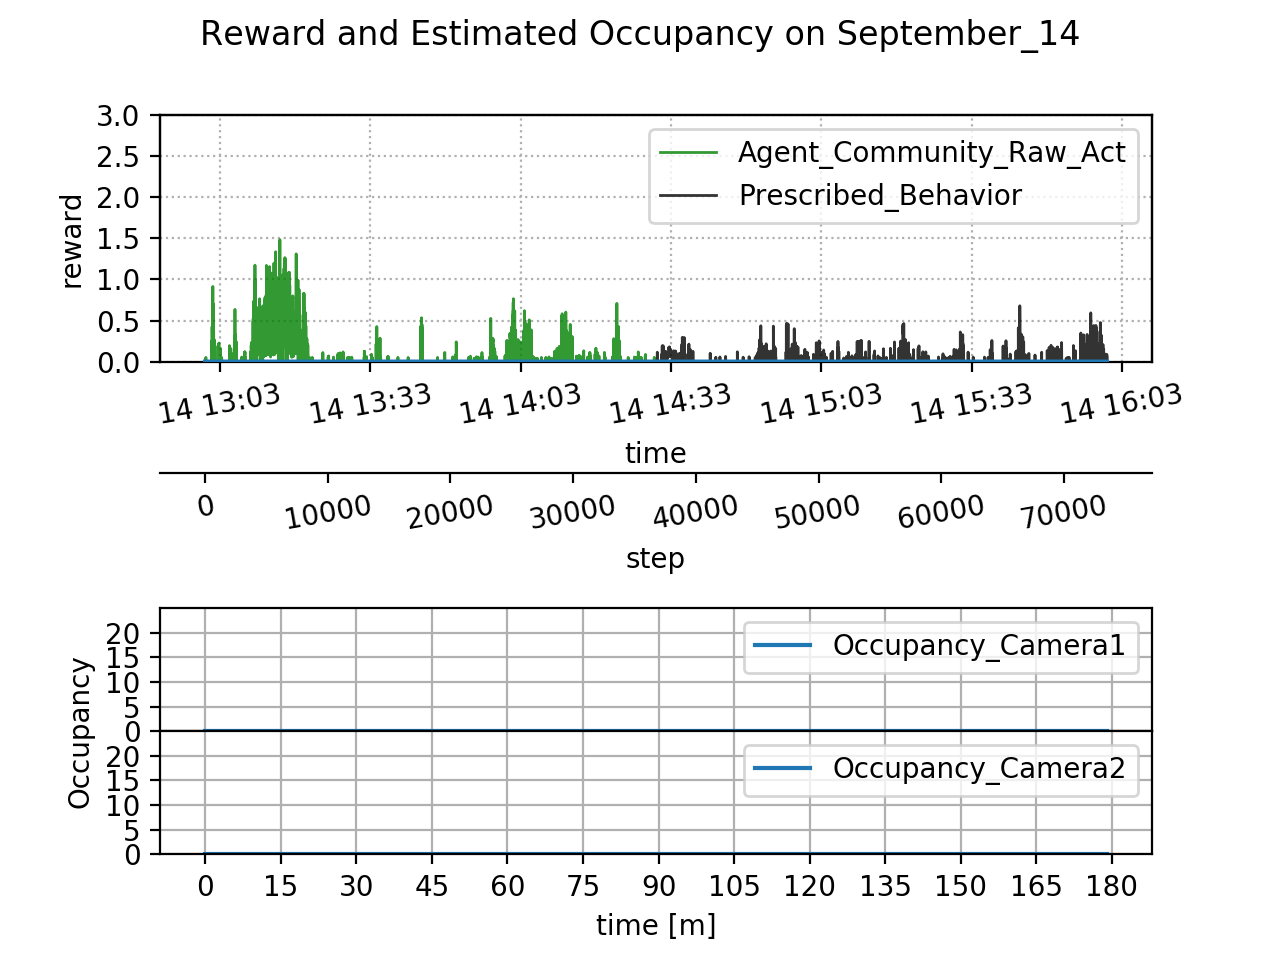

Camera1 on Sep_14: empty
Camera2 on Sep_14: empty
September_17
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


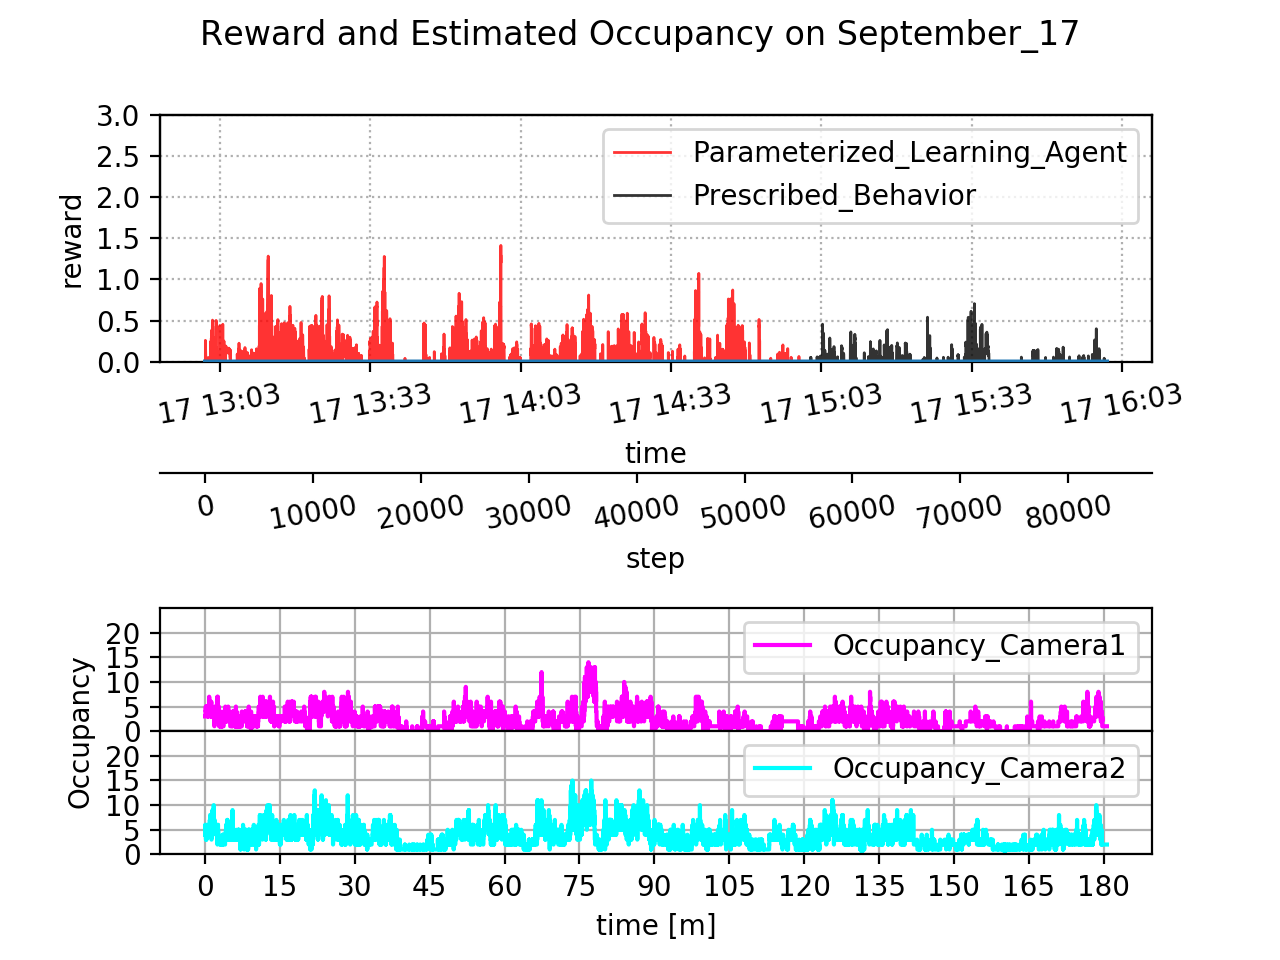

September_18
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


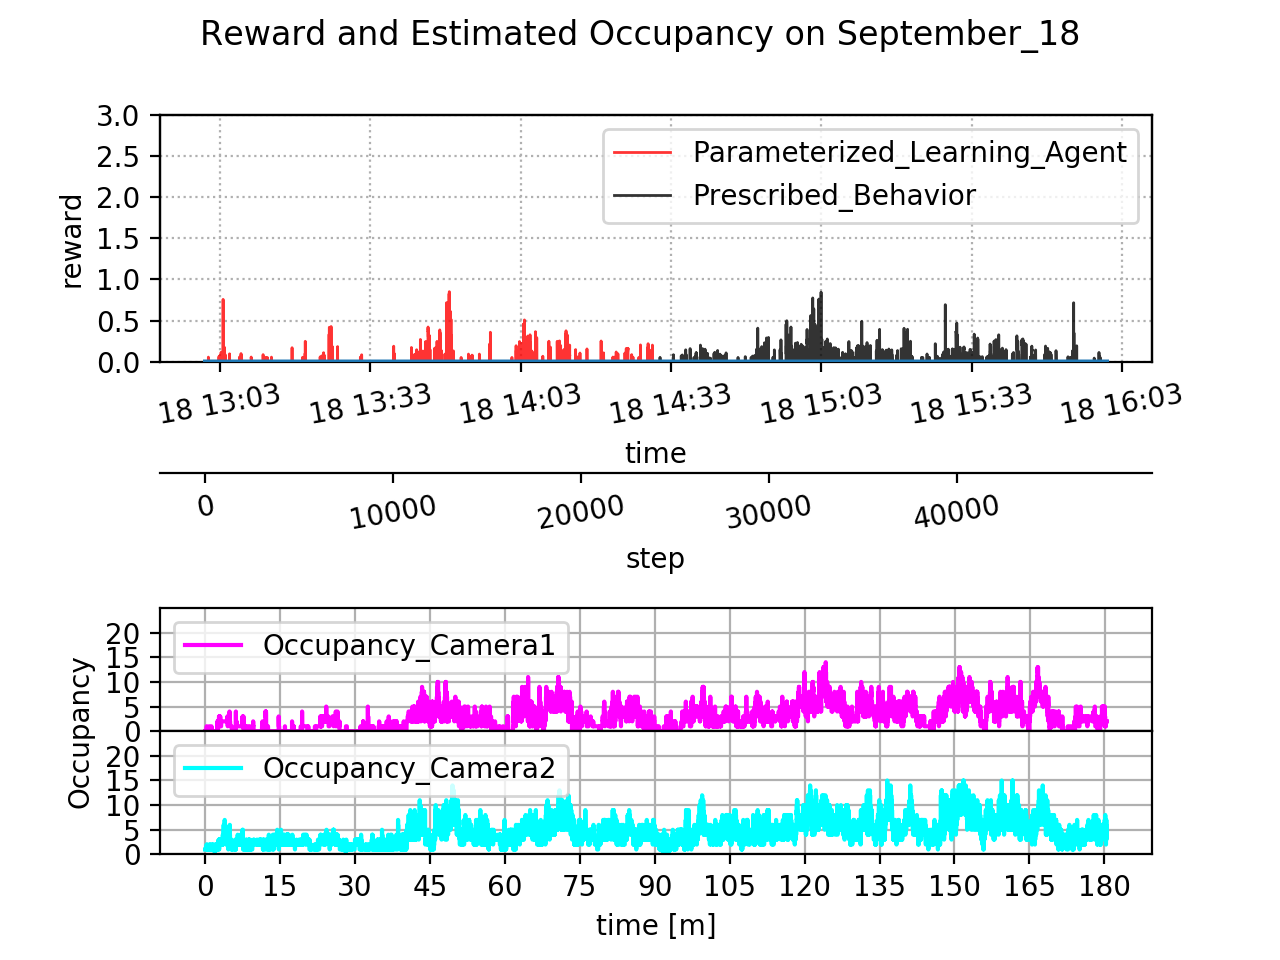

September_19
Separate data done!


<IPython.core.display.Javascript object>


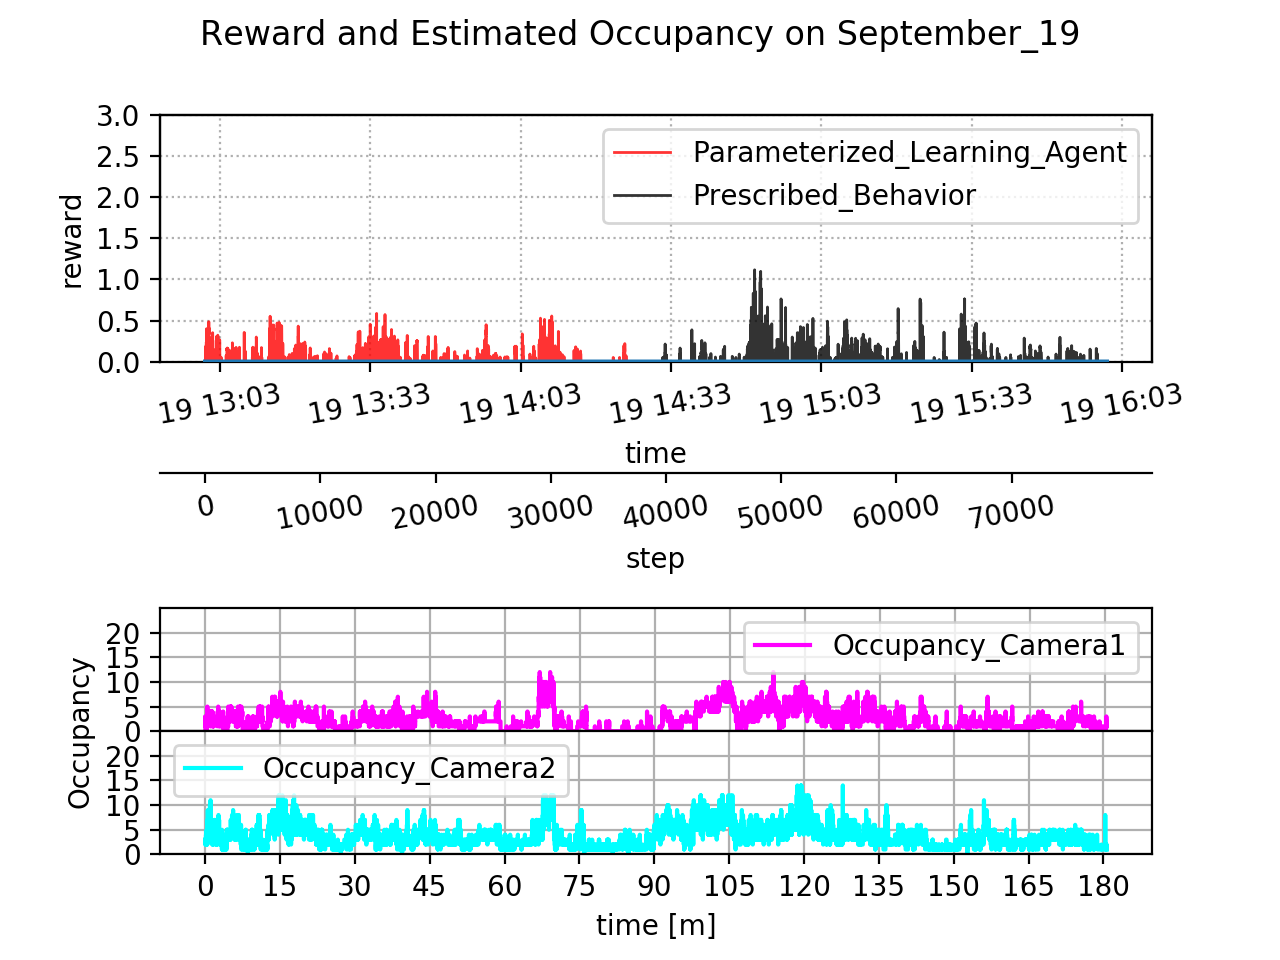

September_20
Separate data done!


<IPython.core.display.Javascript object>


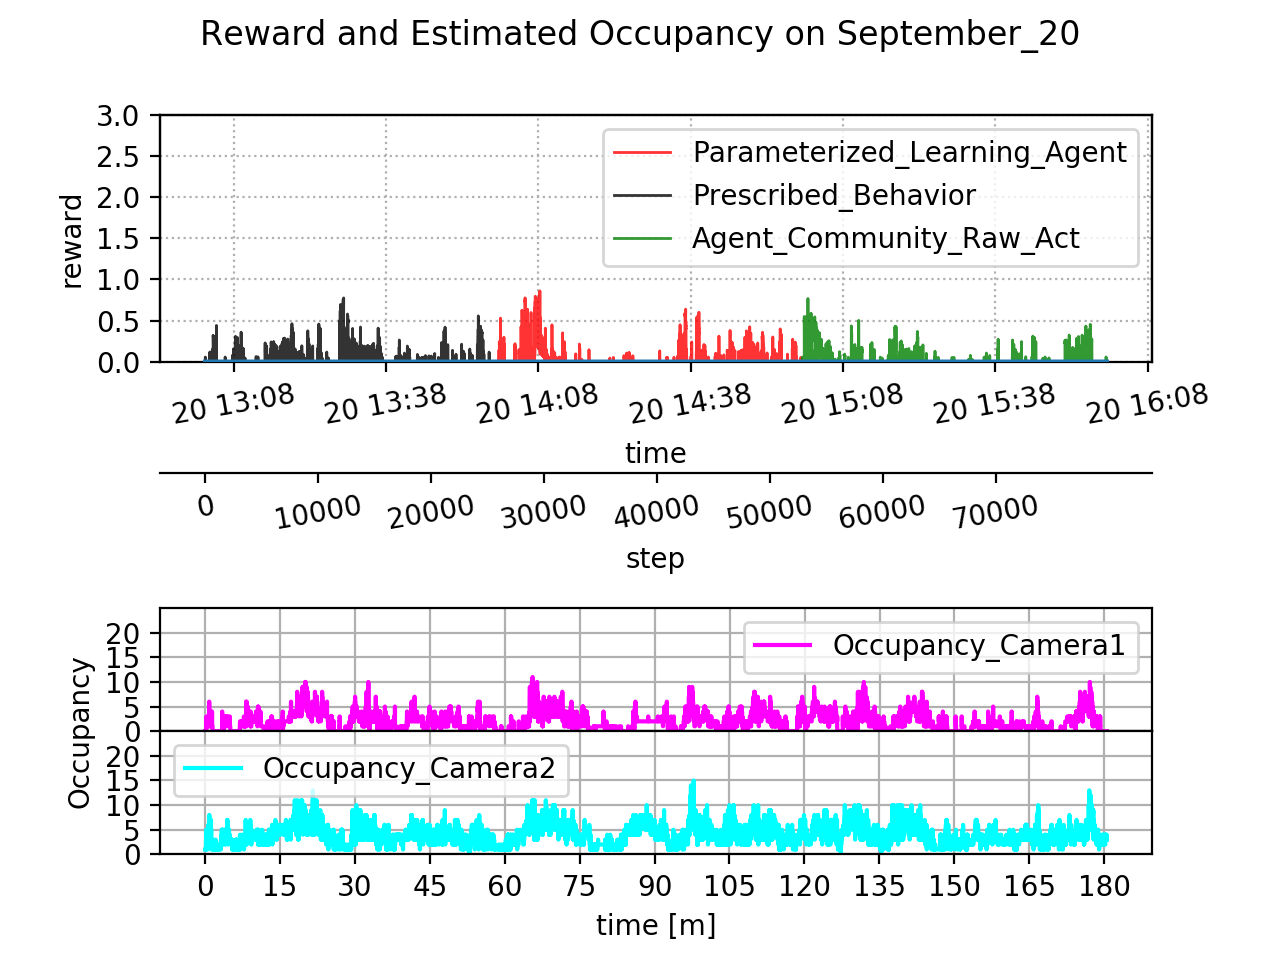

September_21
Separate data done!


<IPython.core.display.Javascript object>


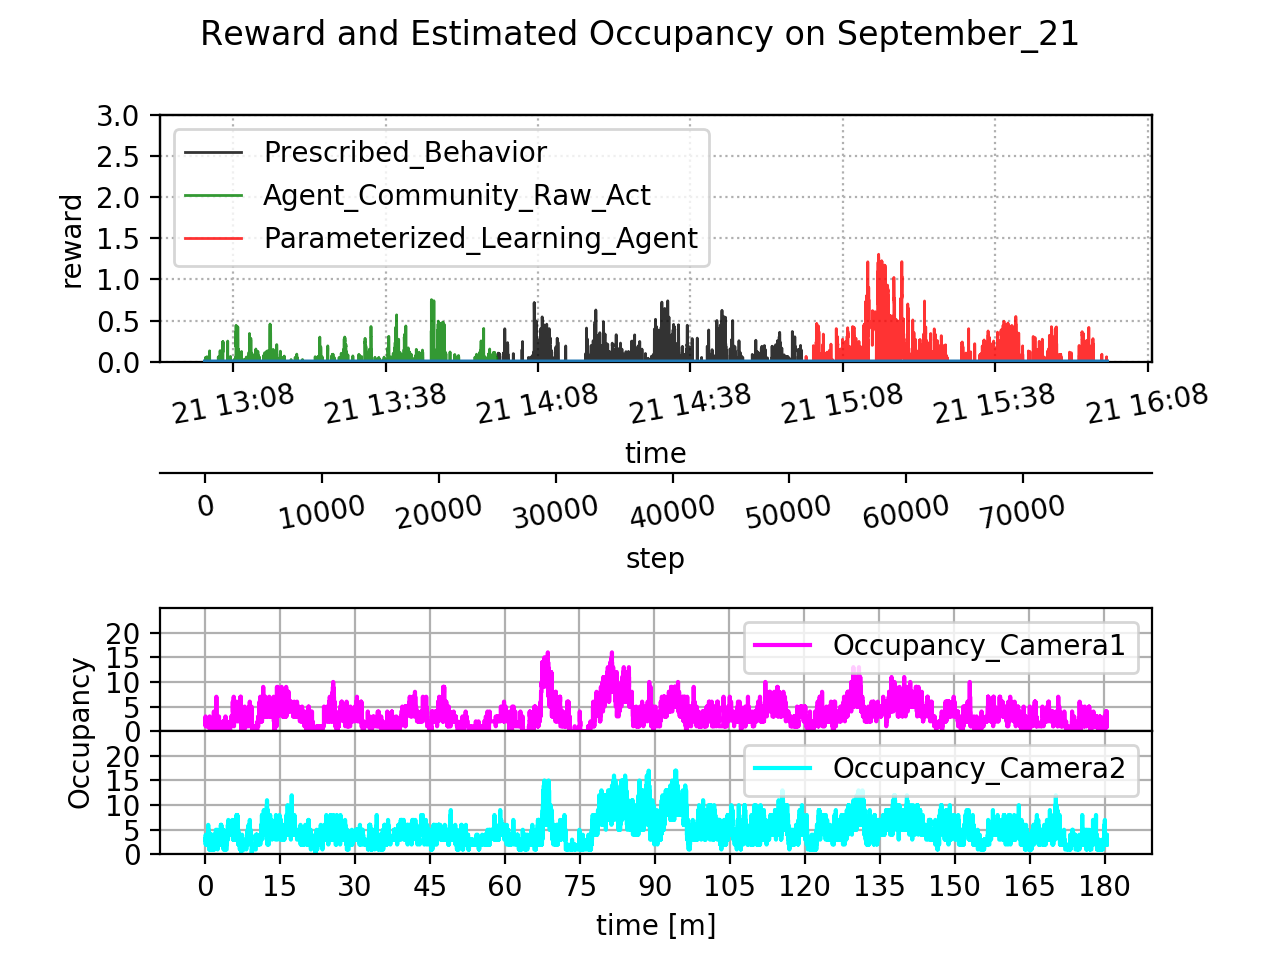

September_24
Separate data done!


<IPython.core.display.Javascript object>


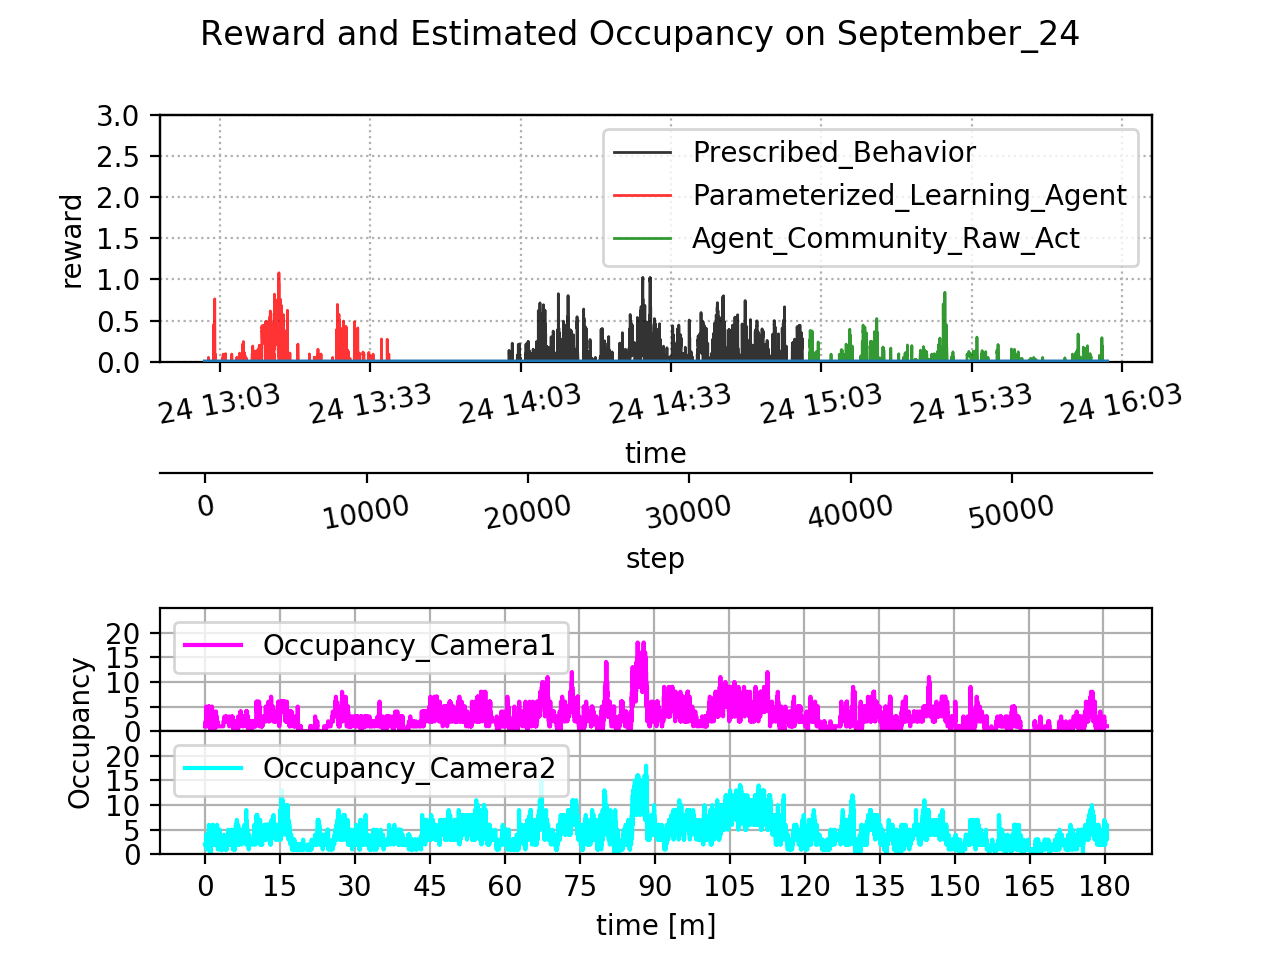

September_25
Separate data done!


<IPython.core.display.Javascript object>


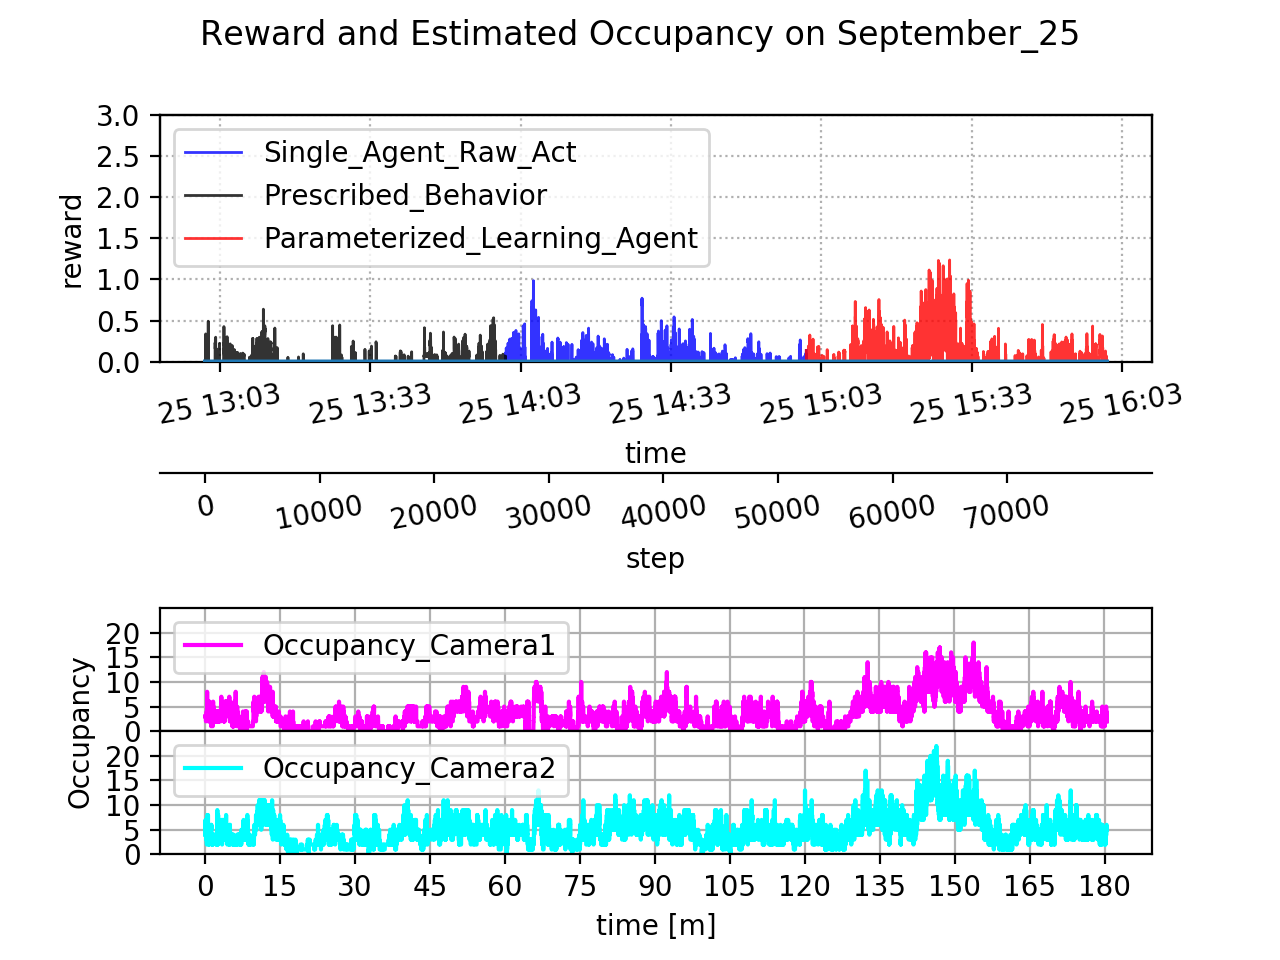

September_26
Separate data done!


<IPython.core.display.Javascript object>


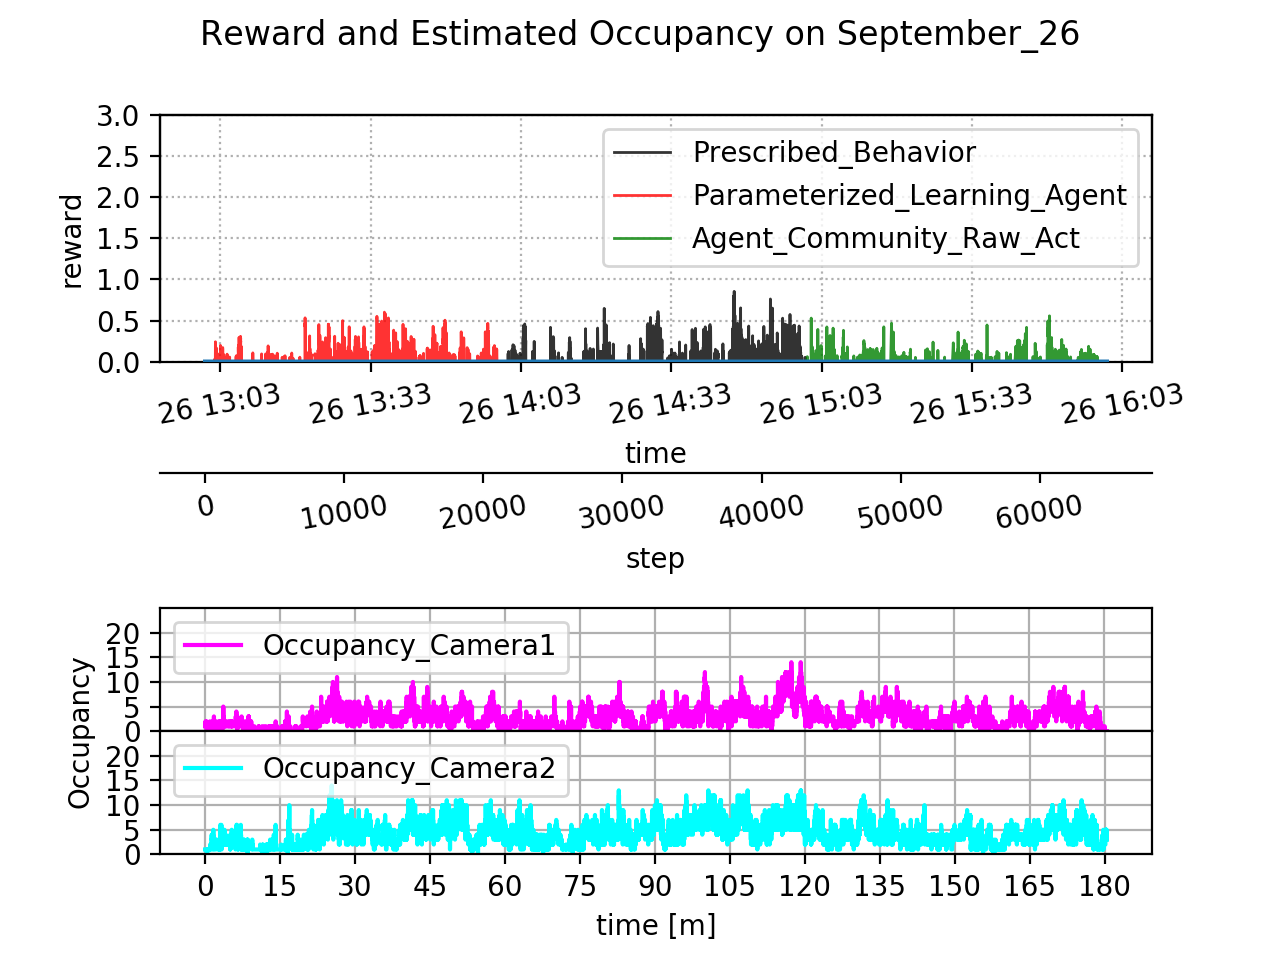

September_27
Separate data done!


<IPython.core.display.Javascript object>


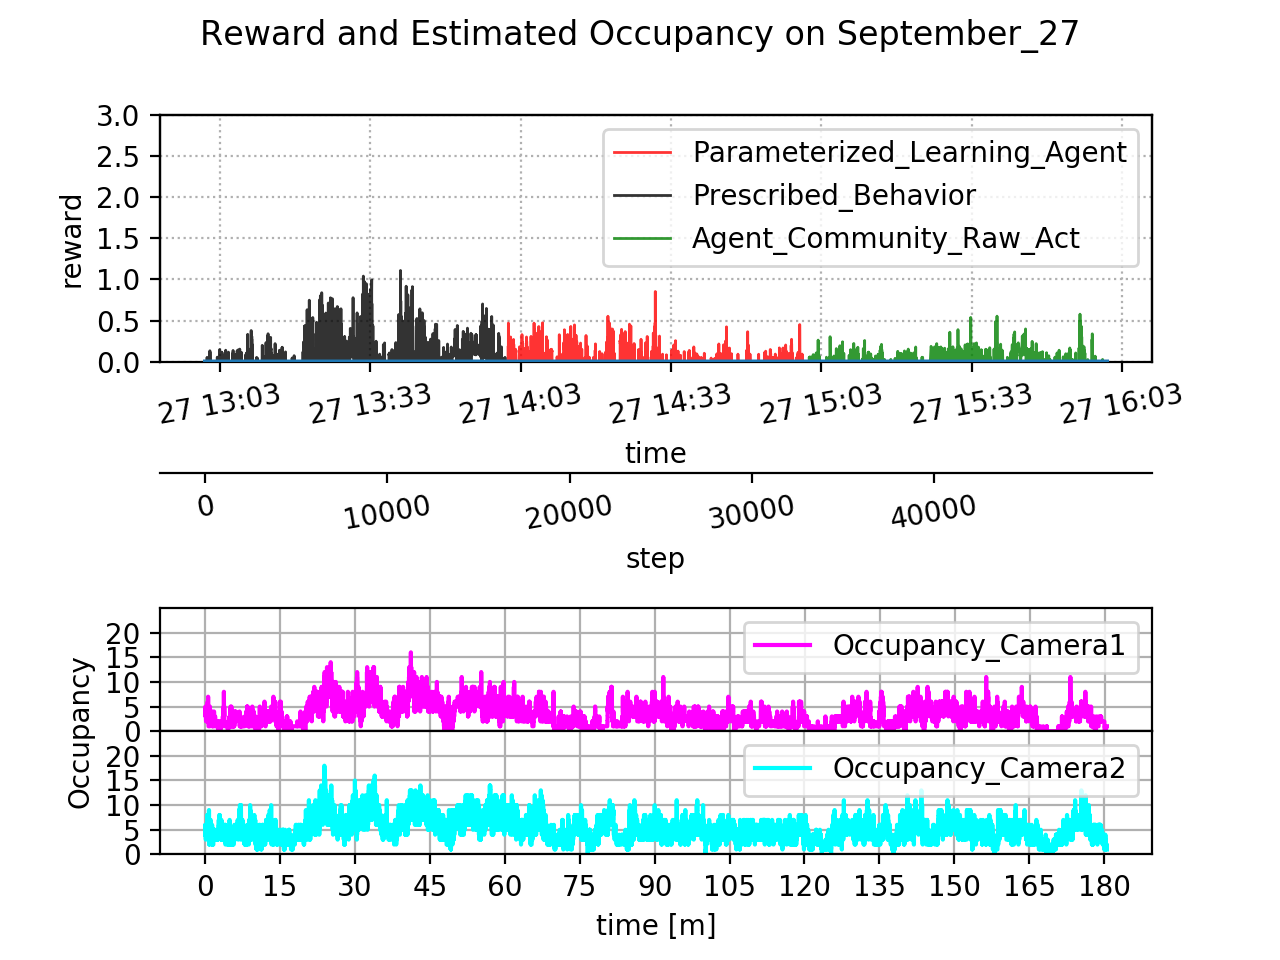

September_28
Separate data done!


<IPython.core.display.Javascript object>


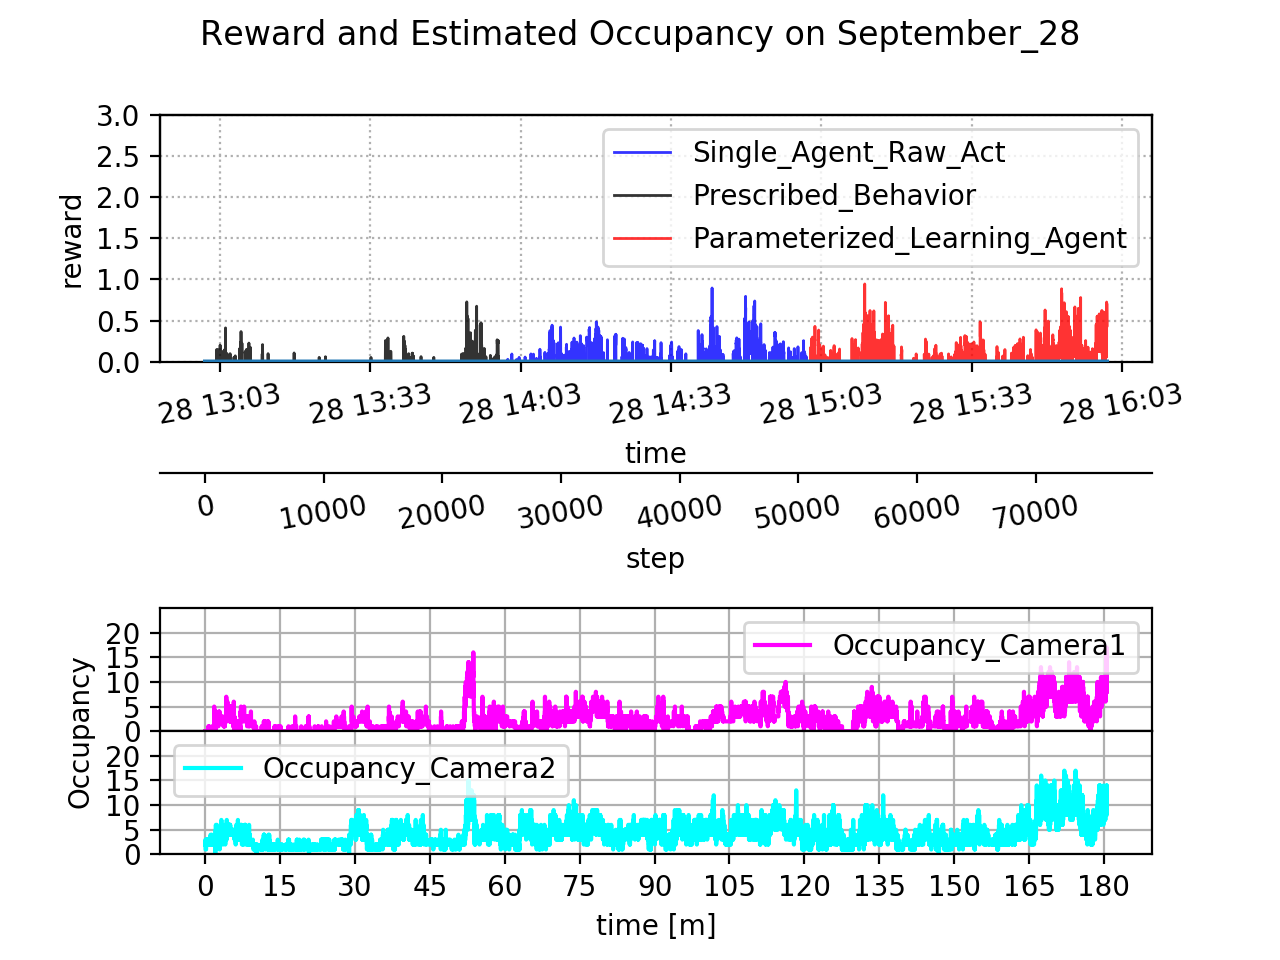

October_02
Separate data done!


<IPython.core.display.Javascript object>


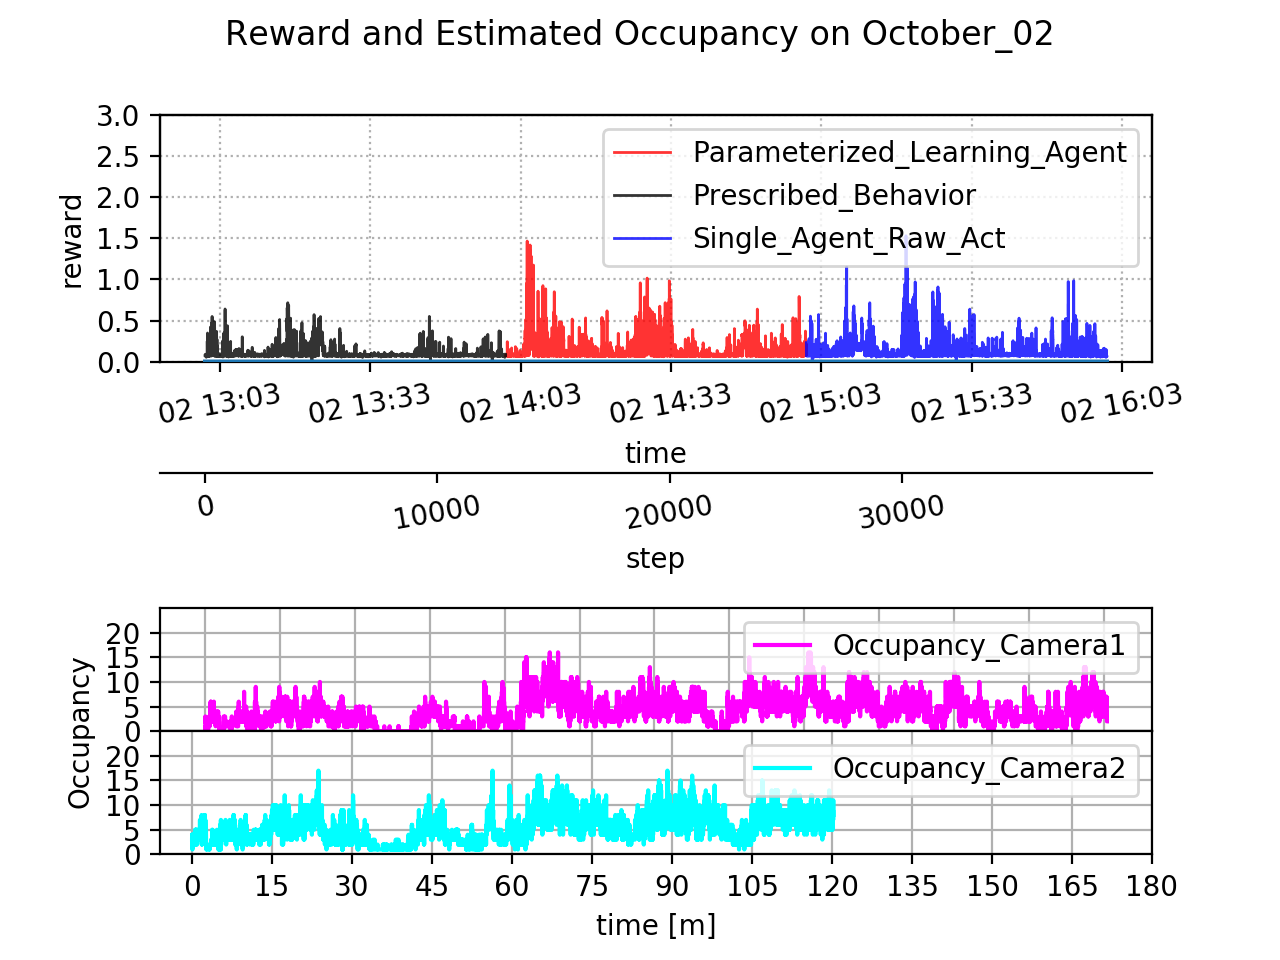

October_03
Separate data done!


<IPython.core.display.Javascript object>


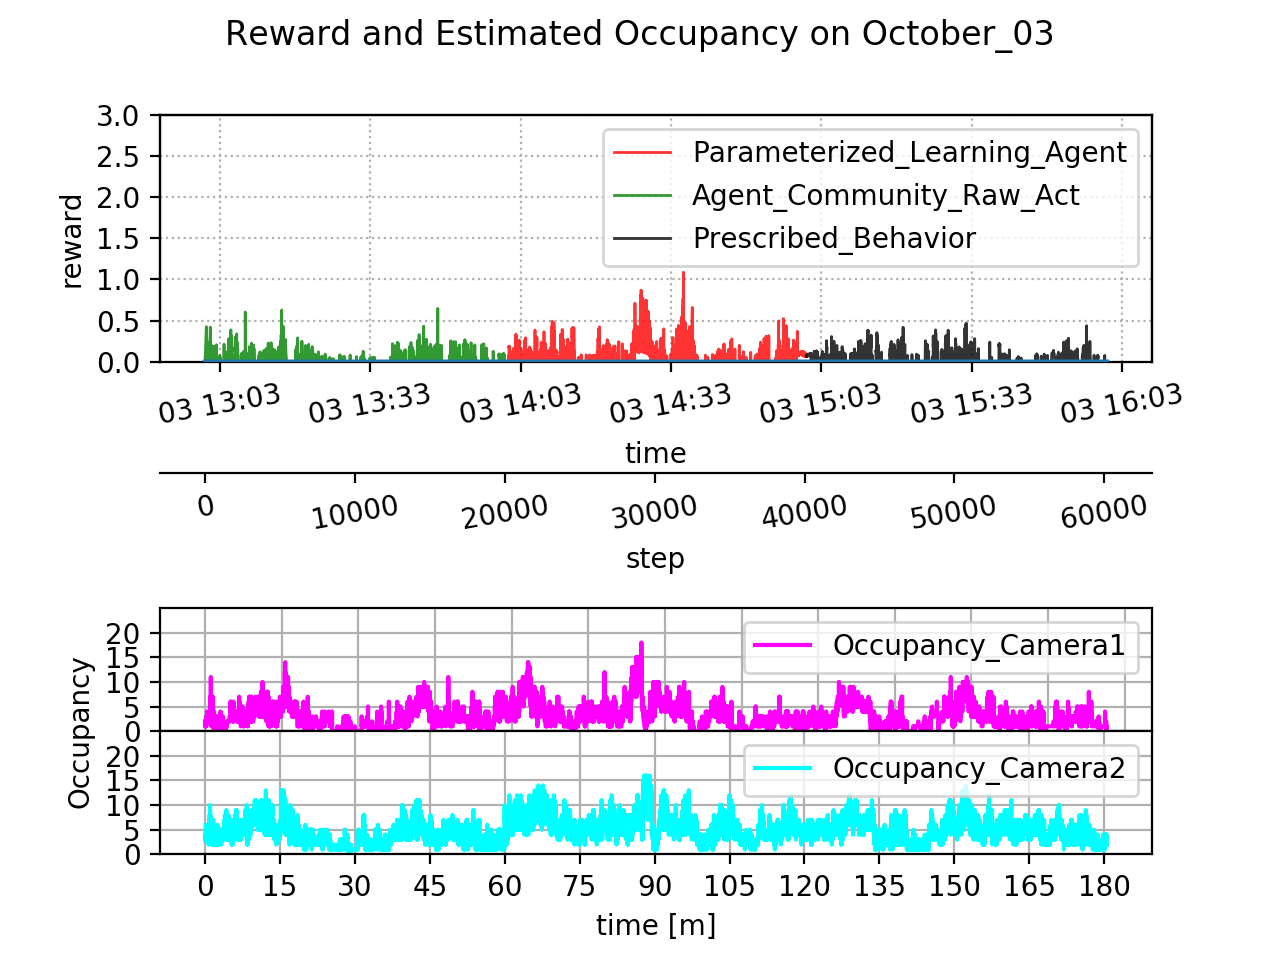

October_05
Separate data done!


<IPython.core.display.Javascript object>


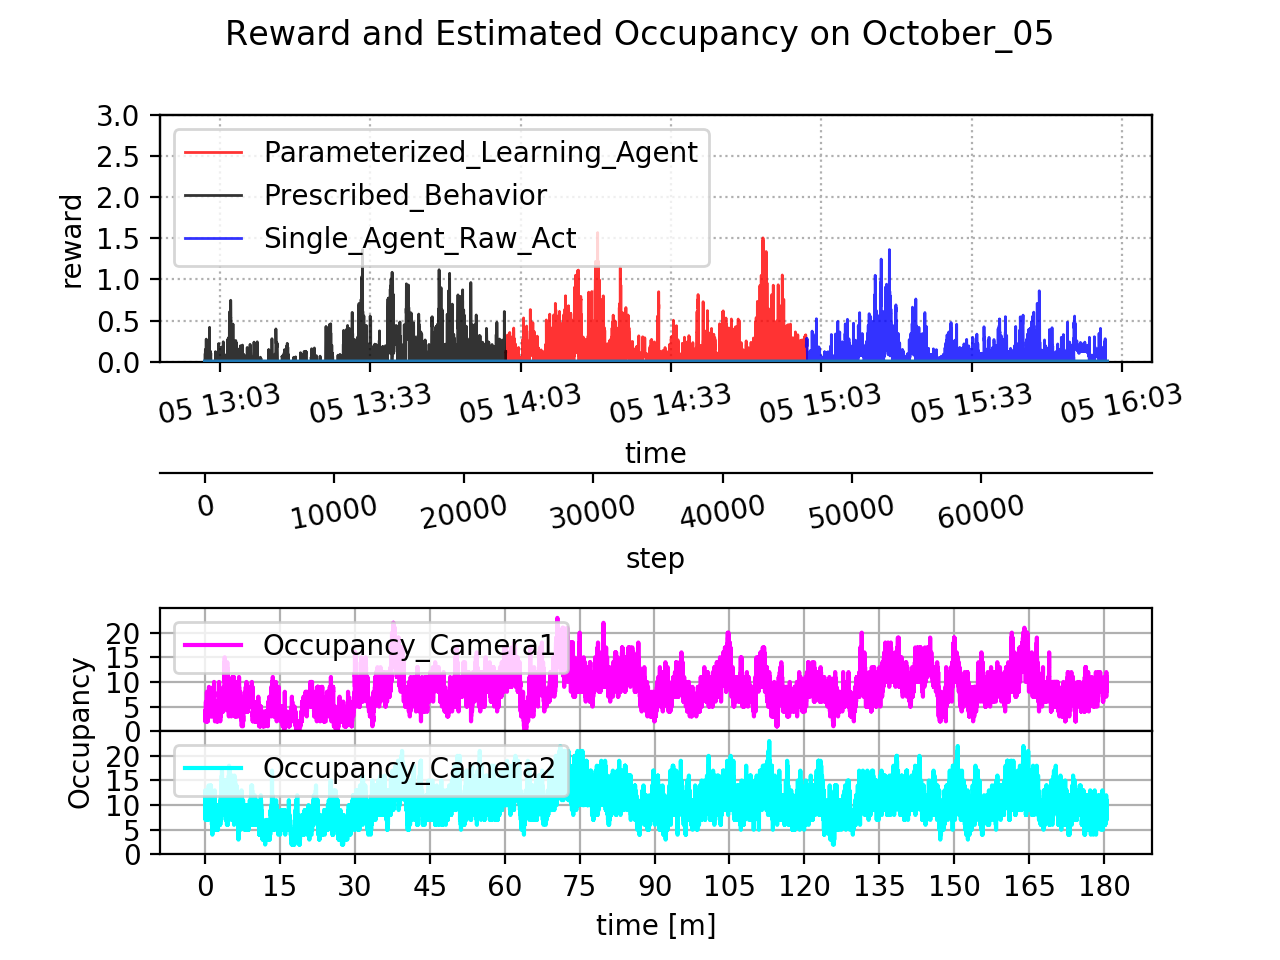

In [4]:
for file in raw_sensor_data.keys():
    _, filename = file.split('/')
    plot_reward_signal_and_estimated_occupancy(raw_sensor_data[file], filename)

## Concate Data from the Same Behavior Mode

In [5]:
prescribed_behavior = {}
prescribed_behavior['data'] = pd.DataFrame()
prescribed_behavior['separate_line'] = []
prescribed_behavior['date'] = []

para_learning_agent = {}
para_learning_agent['data'] = pd.DataFrame()
para_learning_agent['separate_line'] = []
para_learning_agent['date'] = []

single_agent_raw_act = {}
single_agent_raw_act['data'] = pd.DataFrame()
single_agent_raw_act['separate_line'] = []
single_agent_raw_act['date'] = []

agent_coummunity_raw_act = {}
agent_coummunity_raw_act['data'] = pd.DataFrame()
agent_coummunity_raw_act['separate_line'] = []
agent_coummunity_raw_act['date'] = []

for file in raw_sensor_data.keys():
    _, filename = file.split('/')
    _, date = filename.split('_2018')[0].split('sensor_data__')
    
    phase_data, phase_code = separate_data_from_different_behavior(raw_sensor_data[file], date,
                                                                   experiment_schedule_table = 'experiment_schedule_table.csv')
    if 'September'in date:
        date = date.replace('September','Sep')
    elif 'October' in date:
        date = date.replace('October','Oct')
    else:
        pass
    for phase_name in phase_data.keys():
        if phase_code[phase_name] == 0:   # Prescribed_Behavior
            prescribed_behavior['data'] = pd.concat([prescribed_behavior['data'], phase_data[phase_name]])
            prescribed_behavior['separate_line'].append(len(prescribed_behavior['data']))
            prescribed_behavior['date'].append(date)
        
        elif phase_code[phase_name] == 1: # Parameterized_Learning_Agent
            para_learning_agent['data'] = pd.concat([para_learning_agent['data'], phase_data[phase_name]])
            para_learning_agent['separate_line'].append(len(para_learning_agent['data']))
            para_learning_agent['date'].append(date)
        
        elif phase_code[phase_name] == 2: # Single_Agent_Raw_Act
            single_agent_raw_act['data'] = pd.concat([single_agent_raw_act['data'], phase_data[phase_name]])
            single_agent_raw_act['separate_line'].append(len(single_agent_raw_act['data']))
            single_agent_raw_act['date'].append(date)
        
        elif phase_code[phase_name] == 3: # Agent_Community_Raw_Act
            agent_coummunity_raw_act['data'] = pd.concat([agent_coummunity_raw_act['data'], phase_data[phase_name]])
            agent_coummunity_raw_act['separate_line'].append(len(agent_coummunity_raw_act['data']))
            agent_coummunity_raw_act['date'].append(date)
        else:                             # Dirty data
            pass

## Concate Estimated Occupancy from the Same Behavior Mode

In [6]:
date_sequence = ['Sep_14', 'Sep_17', 'Sep_18', 'Sep_19', 'Sep_20', 'Sep_21', 'Sep_24', 
                 'Sep_25', 'Sep_26', 'Sep_27', 'Sep_28', 'Oct_02', 'Oct_03', 'Oct_05']
date_sequence

['Sep_14',
 'Sep_17',
 'Sep_18',
 'Sep_19',
 'Sep_20',
 'Sep_21',
 'Sep_24',
 'Sep_25',
 'Sep_26',
 'Sep_27',
 'Sep_28',
 'Oct_02',
 'Oct_03',
 'Oct_05']

In [7]:
def concate_occupancy_from_the_same_behavior_mode(occupancy_dir, date_sequence):
    """
    Args:
        occupancy_dir (string):
        date_sequence (list):
    Returns:
        prescribed_behavior (dict):
        para_learning_agent (dict):
        single_agent_raw_act (dict):
        agent_coummunity_raw_act (dict):
    """
    occupancy_dir = 'occupancy_estimation/occupancy_estimation_camera1_combined'
    
    prescribed_behavior = {}
    prescribed_behavior['data'] = pd.DataFrame()
    prescribed_behavior['separate_line'] = []
    prescribed_behavior['date'] = []

    para_learning_agent = {}
    para_learning_agent['data'] = pd.DataFrame()
    para_learning_agent['separate_line'] = []
    para_learning_agent['date'] = []

    single_agent_raw_act = {}
    single_agent_raw_act['data'] = pd.DataFrame()
    single_agent_raw_act['separate_line'] = []
    single_agent_raw_act['date'] = []

    agent_coummunity_raw_act = {}
    agent_coummunity_raw_act['data'] = pd.DataFrame()
    agent_coummunity_raw_act['separate_line'] = []
    agent_coummunity_raw_act['date'] = []
    
    for date in date_sequence:
        files = glob.glob(os.path.join(occupancy_dir_camera1, date, '*.csv'))
        files.sort()
        if not files:
            print('Empty: {}'.format(date))
        else:
            for f in files:
                date_info = f.split('/')[-1][8:24]
                if 'Prescribed' in f and 'whole' in f:
                    prescribed_behavior['data'] = pd.concat([prescribed_behavior['data'], pd.read_csv(f)])
                    prescribed_behavior['separate_line'].append(len(prescribed_behavior['data']))
                    prescribed_behavior['date'].append(date_info)
                    
                if 'Parameterized_Learning_Agent' in f and 'whole' in f:
                    para_learning_agent['data'] = pd.concat([para_learning_agent['data'], pd.read_csv(f)])
                    para_learning_agent['separate_line'].append(len(para_learning_agent['data']))
                    para_learning_agent['date'].append(date_info)
                    
                if 'Single' in f and 'whole' in f:
                    if date in ['Sep_25', 'Sep_28', 'Oct_02', 'Oct_05']:
                        single_agent_raw_act['data'] = pd.concat([single_agent_raw_act['data'], pd.read_csv(f)])
                        single_agent_raw_act['separate_line'].append(len(single_agent_raw_act['data']))
                        single_agent_raw_act['date'].append(date_info)
                    
                if 'Agent_Community' in f and 'whole' in f:
                    if date in ['Sep_24', 'Sep_26', 'Sep_27', 'Oct_03']:
                        agent_coummunity_raw_act['data'] = pd.concat([agent_coummunity_raw_act['data'], pd.read_csv(f)])
                        agent_coummunity_raw_act['separate_line'].append(len(agent_coummunity_raw_act['data']))
                        agent_coummunity_raw_act['date'].append(date_info)
    
    return prescribed_behavior, para_learning_agent, single_agent_raw_act, agent_coummunity_raw_act
            
occupancy_dir_camera1 = 'occupancy_estimation/occupancy_estimation_camera1_combined'
occupancy_dir_camera2 = 'occupancy_estimation/occupancy_estimation_camera2_combined'
occupancy_camera1_prescribed_behavior,\
occupancy_camera1_para_learning_agent,\
occupancy_camera1_single_agent_raw_act,\
occupancy_camera1_agent_coummunity_raw_act = concate_occupancy_from_the_same_behavior_mode(occupancy_dir_camera1, date_sequence)

occupancy_camera2_prescribed_behavior,\
occupancy_camera2_para_learning_agent,\
occupancy_camera2_single_agent_raw_act,\
occupancy_camera2_agent_coummunity_raw_act = concate_occupancy_from_the_same_behavior_mode(occupancy_dir_camera2, date_sequence)


Empty: Sep_14
Empty: Sep_14


## Plot Reward, Distribution of Reward Greater than 0.5 and Estimated Occupancy

In [8]:
def plot_reward_from_one_behavior_mode(data, occupancy_camera1, occupancy_camera2, behavior_mode):
        reward_data = data['data']['reward_IR_distance'].astype(float).values
        
        fig = plt.figure(figsize=(8, 6))
        grid = plt.GridSpec(1, 3, hspace=0.6, wspace=0.2)
        main_ax = fig.add_subplot(grid[:, 1:3])
        y_hist = fig.add_subplot(grid[:, 0:1], sharey=main_ax)
#         x_occupancy = fig.add_subplot(grid[2:3, 1:3])
        
        # plot reward
        main_ax.plot(np.arange(len(reward_data)), reward_data)
        for i, separate_line in enumerate(data['separate_line']):
            main_ax.axvline(x = separate_line, color = 'k', linestyle=':')
            if i == 0:
                middle = data['separate_line'][i]*0.35
                main_ax.text(middle, 2, data['date'][i], rotation=90, verticalalignment='center')
            else:
                middle = data['separate_line'][i-1]+(data['separate_line'][i]-data['separate_line'][i-1])*0.35
                main_ax.text(middle, 2, data['date'][i], rotation=90, verticalalignment='center')
        rect = patches.Rectangle((0,0.5), len(reward_data), 1.25, fill = False, color = 'r', linestyle='--',linewidth = 2)
        main_ax.add_patch(rect)
        main_ax.set_xlabel('Step')
        for label in main_ax.get_xticklabels():
            label.set_rotation(20) 
        main_ax.set_ylabel('Reward')
        main_ax.set_ylim(0,2.5,0.25)
        main_ax.set_title('Reward: {}'.format(behavior_mode))
        
        # plot hist
        hist_reward_threshold = 0.5#1.0#0.75
        hist_data = reward_data[reward_data>=hist_reward_threshold]
        results, edges = np.histogram(hist_data, bins = 100)
        percentage = (results / sum(results)) * 100
        binWidth = 0.05
        y_hist.barh(edges[:-1], percentage, binWidth)
        ellipse = patches.Ellipse((0, 1.3), 2, 0.4, fill = False, color='r', linestyle='--', linewidth=2)
        y_hist.add_patch(ellipse)
        y_hist.annotate('active interaction',
                        xy=(1, 1.3), xycoords='data',
                        xytext=(0.8, 0.65), textcoords='axes fraction',
                        arrowprops=dict(facecolor='black', shrink=0.05, fill=False),
                        horizontalalignment='right', verticalalignment='top')
        from matplotlib.ticker import FuncFormatter
        formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
        y_hist.xaxis.set_major_formatter(formatter)
        y_hist.set_xlim(0,10)
        y_hist.set_xlabel('Percentage')
        y_hist.invert_xaxis()
        y_hist.set_title('Hist of reward >={}'.format(hist_reward_threshold))
        y_hist.grid(True, linestyle=':')
        
#         # plot occupancy
#         x_occupancy.plot(np.arange(len(occupancy_camera1['data'])), occupancy_camera1['data']['Occupancy'])
#         for i, separate_line in enumerate(occupancy_camera1['separate_line']):
#             x_occupancy.axvline(x = separate_line, color = 'k', linestyle=':')
#             if i == 0:
#                 middle = occupancy_camera1['separate_line'][i]*0
#                 x_occupancy.text(middle, -10, occupancy_camera1['date'][i], rotation=-20, verticalalignment='center')
#             else:
#                 middle = occupancy_camera1['separate_line'][i-1]#+(occupancy_camera1['separate_line'][i]-occupancy_camera1['separate_line'][i-1])*0.35
#                 x_occupancy.text(middle, -10, occupancy_camera1['date'][i], rotation=-20, verticalalignment='center')
#         x_occupancy.set_yticks(np.arange(0,25,5))
#         x_occupancy.set_ylim(0,25)
        

**Comparing the following 4 figures, if we regard reward greater than 0.5 as reaching hand, it seems prescribed behavior and learning agent acting on parameterized action space are more interactive than the two algorithms working on raw actuators.**

<IPython.core.display.Javascript object>


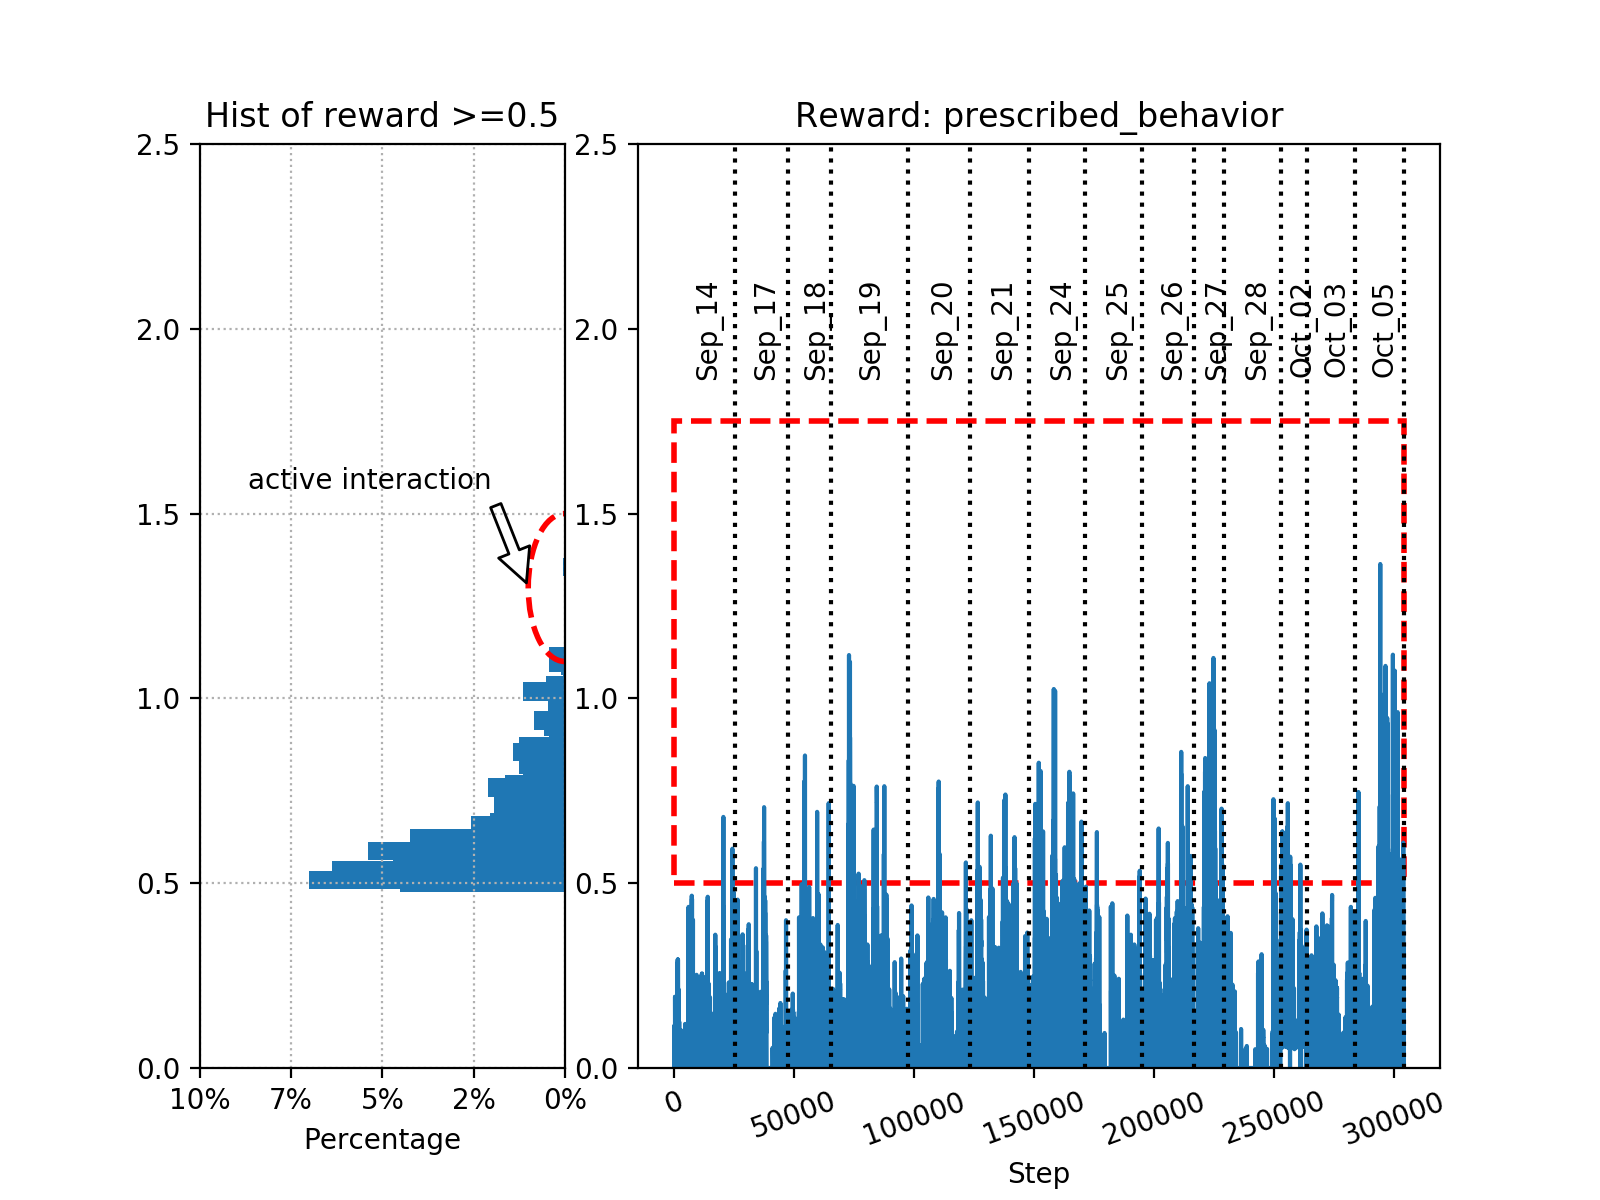

<IPython.core.display.Javascript object>


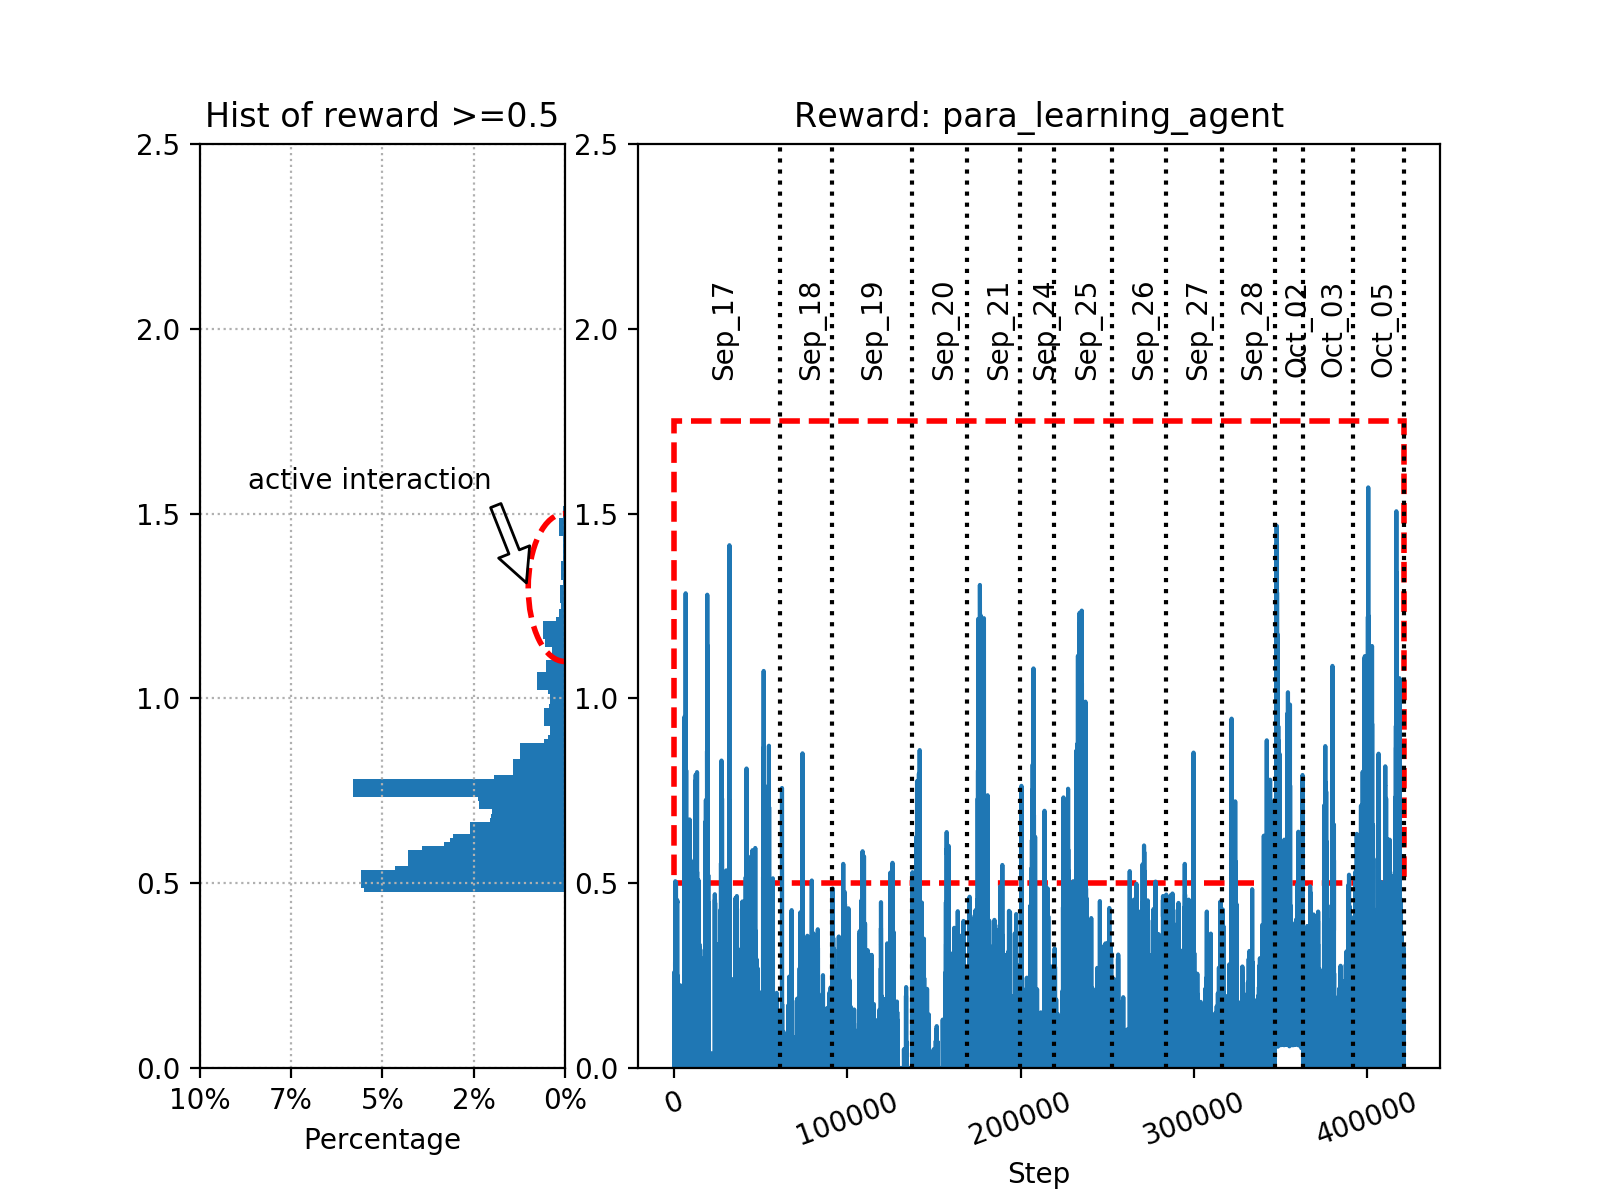

<IPython.core.display.Javascript object>


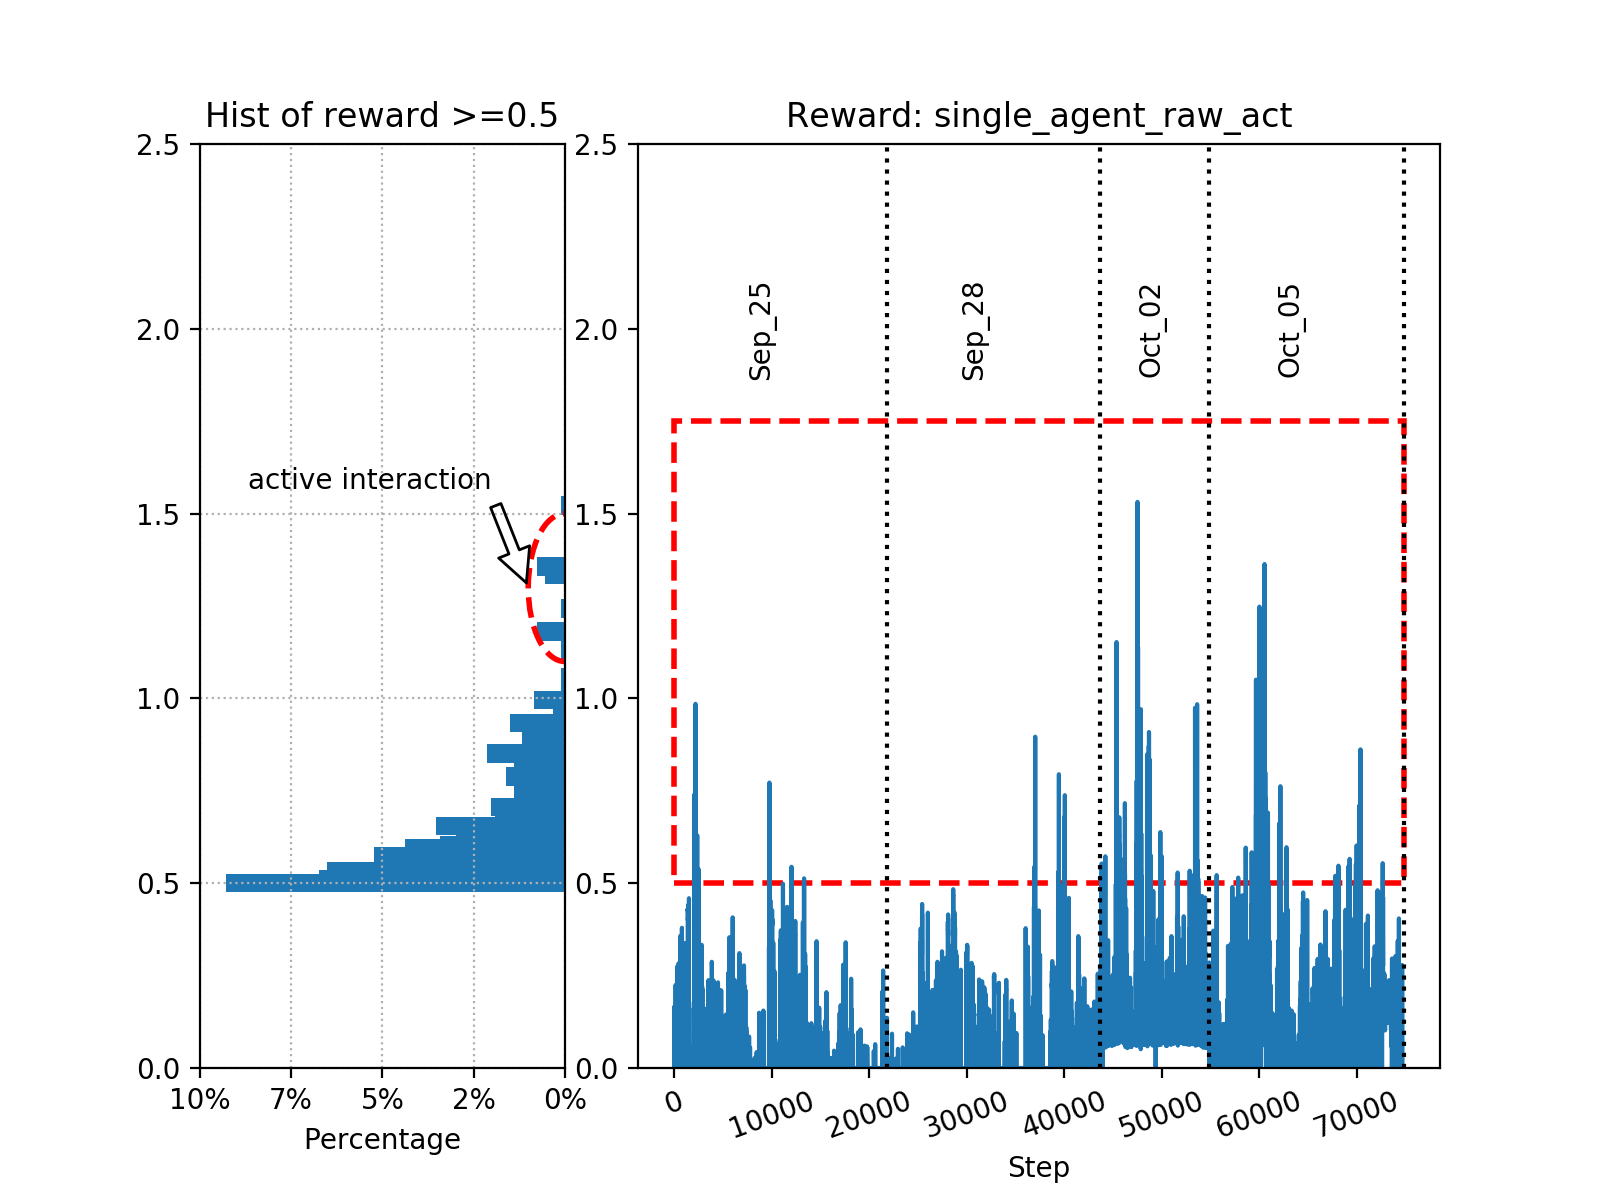

<IPython.core.display.Javascript object>


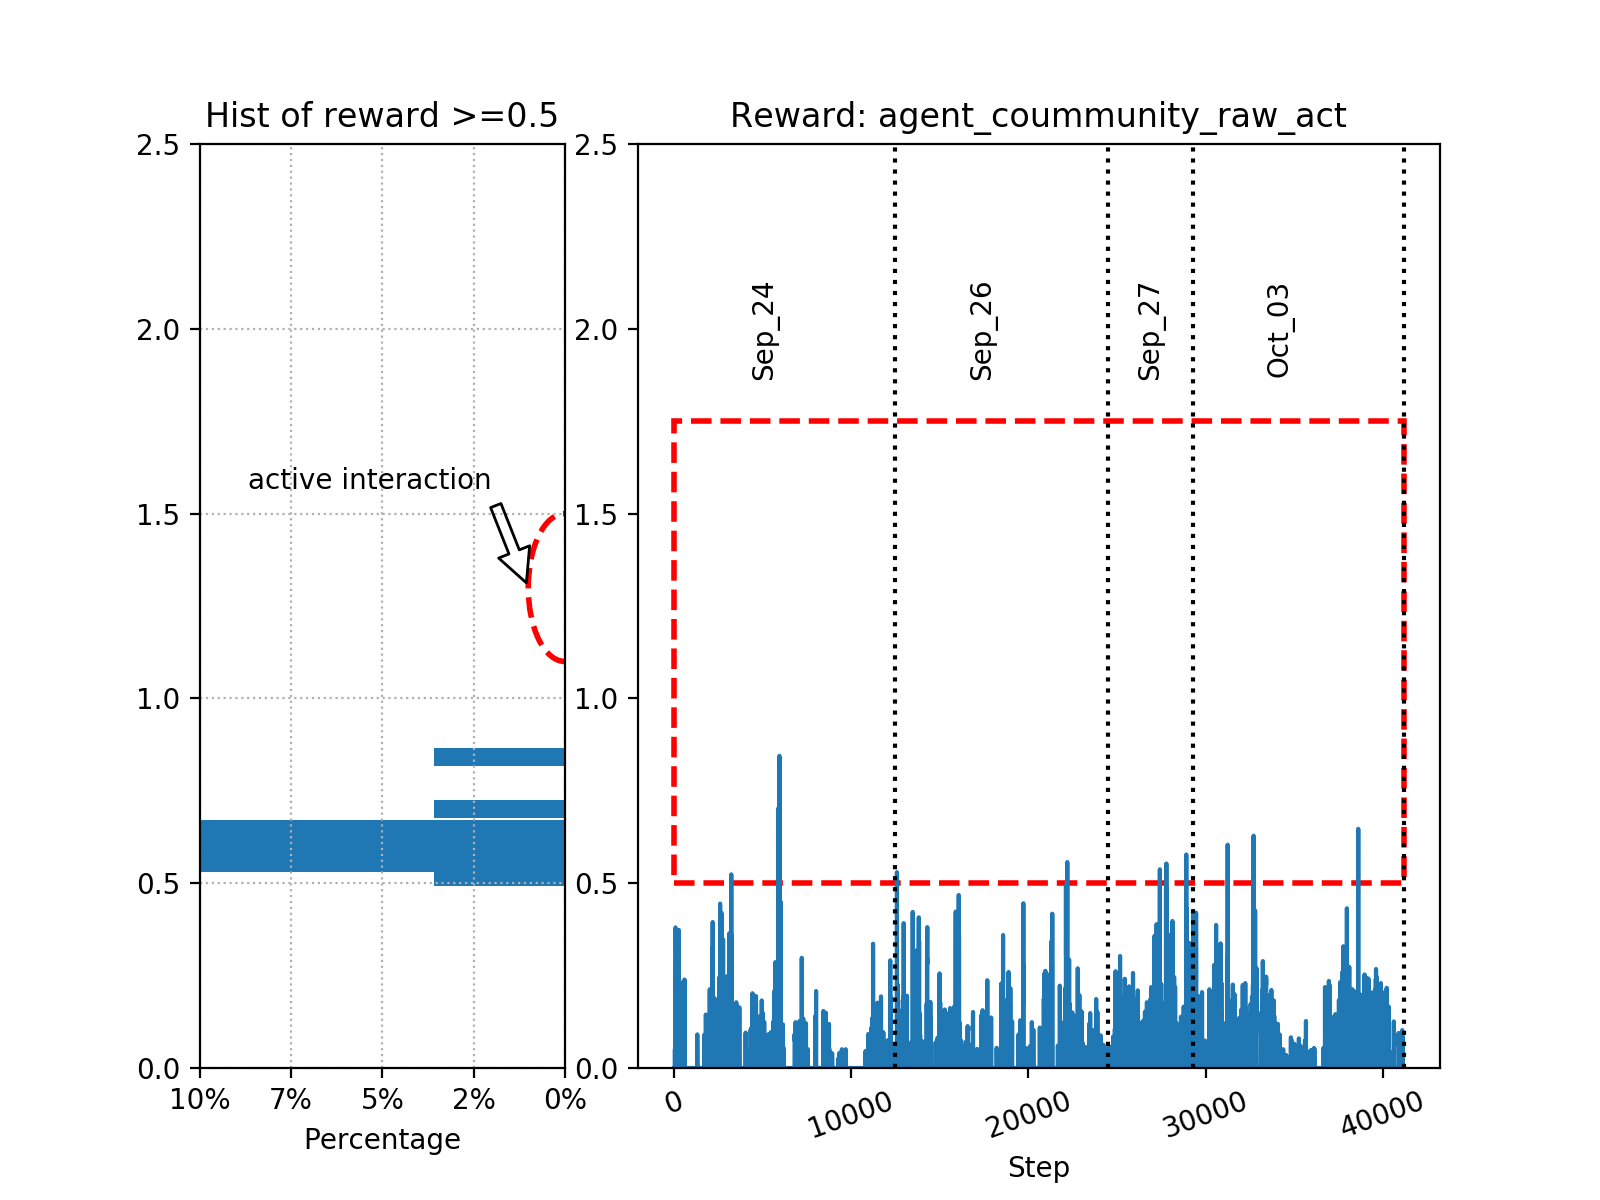

In [9]:
plot_reward_from_one_behavior_mode(prescribed_behavior,
                                   occupancy_camera1_prescribed_behavior,
                                   occupancy_camera2_prescribed_behavior,
                                   'prescribed_behavior')
plot_reward_from_one_behavior_mode(para_learning_agent, 
                                   occupancy_camera1_para_learning_agent,
                                   occupancy_camera2_para_learning_agent,
                                   'para_learning_agent')
plot_reward_from_one_behavior_mode(single_agent_raw_act, 
                                   occupancy_camera1_single_agent_raw_act,
                                   occupancy_camera2_single_agent_raw_act,
                                   'single_agent_raw_act')
plot_reward_from_one_behavior_mode(agent_coummunity_raw_act, 
                                   occupancy_camera1_agent_coummunity_raw_act,
                                   occupancy_camera2_agent_coummunity_raw_act,
                                   'agent_coummunity_raw_act')

In [10]:
def combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_data):
    new_occupancy_data = occupancy_data
    for i, date in enumerate(occupancy_data['date']):
        d = date[0:6]
        t_start = date[7:11]
        t_end = date[12:]
        if i == 0:
            pass
        else:
            if d == last_d:
                print('Combine {} and {}'.format(i, i-1))
                combined_d = '{}_{}_{}'.format(d, last_t_start, t_end)
                print(combined_d)
                new_occupancy_data['date'][i] = combined_d
                new_occupancy_data['date'].pop(i-1)
                new_occupancy_data['separate_line'].pop(i-1)
        last_d = d
        last_t_start = t_start
        last_t_end = t_end
        #print('d:{}, t_start:{}, t_end:{}'.format(d,t_start,t_end))
    return new_occupancy_data

occupancy_camera1_prescribed_behavior = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_prescribed_behavior)
occupancy_camera1_para_learning_agent = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_para_learning_agent)
occupancy_camera1_single_agent_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_single_agent_raw_act)
occupancy_camera1_agent_coummunity_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_agent_coummunity_raw_act)

occupancy_camera2_prescribed_behavior = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_prescribed_behavior)
occupancy_camera2_para_learning_agent = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_para_learning_agent)
occupancy_camera2_single_agent_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_single_agent_raw_act)
occupancy_camera2_agent_coummunity_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_agent_coummunity_raw_act)


Combine 2 and 1
Sep_18_1430_1600
Combine 1 and 0
Sep_17_1300_1500
Combine 4 and 3
Sep_19_1300_1430
Combine 2 and 1
Sep_18_1430_1600
Combine 1 and 0
Sep_17_1300_1500
Combine 4 and 3
Sep_19_1300_1430


In [11]:
occupancy_camera1_para_learning_agent['date']

['Sep_17_1300_1500',
 'Sep_18_1300_1400',
 'Sep_18_1400_1430',
 'Sep_19_1300_1430',
 'Sep_20_1400_1500',
 'Sep_21_1500_1600',
 'Sep_24_1300_1400',
 'Sep_25_1500_1600',
 'Sep_26_1300_1400',
 'Sep_27_1400_1500',
 'Sep_28_1500_1600',
 'Oct_02_1400_1500',
 'Oct_03_1400_1500',
 'Oct_05_1400_1500']

In [12]:
def plot_reward_from_one_behavior_mode(data, occupancy_camera1, occupancy_camera2, behavior_mode):
    """
    Args:
        behavior_mode (string):
            1. 'prescribed_behavior'
            2. 'para_learning_agent'
            3. 'single_agent_raw_act'
            4. 'agent_coummunity_raw_act'
    """
    segment_num = len(data['separate_line'])
    if behavior_mode == 'prescribed_behavior':
        print('prescribed_behavior: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+2
    if behavior_mode == 'para_learning_agent':
        print('para_learning_agent: {} segments'.format(segment_num))
        segment_num = segment_num + 1
        grid_w = int(segment_num*1.5)+2
    if behavior_mode == 'single_agent_raw_act':
        print('single_agent_raw_act: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+1
    if behavior_mode == 'agent_coummunity_raw_act':
        print('agent_coummunity_raw_act: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+1
    grid_h = 3
    print('grid_h:{}, grid_w:{}, segment_num:{}'.format(grid_h, grid_w, segment_num))
    ########################################
    #             Create Axes              #
    ########################################
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle('Behavior Mode: {}'.format(behavior_mode))
    grid = plt.GridSpec(grid_h, grid_w, hspace=0.8, wspace=0)
    # 1. Main ax
    main_ax = []
    for i in range(segment_num):
        if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
            main_ax.append(fig.add_subplot(grid[:int(grid_h*2/3), 2+(int(grid_w/3))+i:2+(int(grid_w/3))+i+1]))
        else:
            main_ax.append(fig.add_subplot(grid[:int(grid_h*2/3), 1+(int(grid_w/3))+i:1+(int(grid_w/3))+i+1]))
    # 2. Reward hist ax
    reward_hist_ax = fig.add_subplot(grid[:int(grid_h*2/3), :(int(grid_w/3))], sharey=main_ax[0])
    # 3. Ocuupancy ax  
    occupancy_ax = []
    for i in range(segment_num):
        if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
            occupancy_ax.append(fig.add_subplot(grid[int(grid_h*2/3):, 2+(int(grid_w/3))+i:2+(int(grid_w/3))+i+1]))
        else:
            occupancy_ax.append(fig.add_subplot(grid[int(grid_h*2/3):, 1+(int(grid_w/3))+i:1+(int(grid_w/3))+i+1]))
    ########################################
    #                 Plot                 #
    ########################################
    # 1. plot reward
    reward_data = data['data']['reward_IR_distance'].astype(float).values
    for i, main_ax_tmp in enumerate(main_ax):
        if behavior_mode != 'para_learning_agent':
            if i != 0:
                y = reward_data[data['separate_line'][i-1]:data['separate_line'][i]]
            else:
                y = reward_data[:data['separate_line'][i]]
            main_ax_tmp.text(len(y)*0.35, 2, data['date'][i], rotation=90, verticalalignment='center')
            
        else:
            if i == 0:
                y = np.zeros(0)
            else:
                temp_i = i-1
                if temp_i != 0:
                    y = reward_data[data['separate_line'][temp_i-1]:data['separate_line'][temp_i]]
                else:
                    y = reward_data[:data['separate_line'][temp_i]]
                main_ax_tmp.text(len(y)*0.35, 2, data['date'][temp_i], rotation=90, verticalalignment='center')
        # plot steps for each day
        steps = len(y)
        main_ax_tmp.text(len(y)*0.05, -0.2, '{}'.format(steps), rotation=-30, verticalalignment='center')
        # plot xlabel in the middle
        if i == int(len(main_ax)/2): 
            main_ax[i].text(-len(y)*(1/3), -0.4, 'Steps', verticalalignment='center')
        
        main_ax_tmp.plot(np.arange(len(y)), y)

        main_ax_tmp.set_ylim(0,2.5,0.25)
        main_ax_tmp.set_xticks(np.arange(0,len(y),5000))
        main_ax_tmp.tick_params(axis='x', rotation=10)
        main_ax_tmp.tick_params(bottom='off', labelbottom='off')
        if i != 0:
            main_ax_tmp.tick_params(left='off', labelleft='off')
            main_ax_tmp.spines['left'].set_visible(False)
        if i != len(main_ax)-1:
            main_ax_tmp.spines['right'].set_linestyle('--')
            main_ax_tmp.spines['right'].set_linewidth(1.5)
            main_ax_tmp.spines['right'].set_color('r')
    main_ax[0].set_ylabel('Reward')
    title_main_ax = int(len(main_ax)/2)
    main_ax[title_main_ax].set_title('Reward',position=(0,1))
    
    #main_ax[title_main_ax].set_xlabel('Steps', position=(0,-0.5))
    
    # 2. plot hist
    hist_reward_threshold = 0.5#1.0#0.75
    hist_data = reward_data[reward_data>=hist_reward_threshold]
    results, edges = np.histogram(hist_data, bins = 100)
    percentage = (results / sum(results)) * 100
    binWidth = 0.05
    reward_hist_ax.barh(edges[:-1], percentage, binWidth)
    ellipse = patches.Ellipse((0, 1.4), 2.2, 0.5, fill = False, color='r', linestyle='--', linewidth=2)
    reward_hist_ax.add_patch(ellipse)
    reward_hist_ax.annotate('active interaction',
                            xy=(1, 1.4), xycoords='data',
                            xytext=(0.8, 0.8), textcoords='axes fraction',
                            arrowprops=dict(facecolor='black', shrink=0.05, fill=False),
                            horizontalalignment='right', verticalalignment='top')
    from matplotlib.ticker import FuncFormatter
    formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
    reward_hist_ax.xaxis.set_major_formatter(formatter)
    reward_hist_ax.set_xlim(0,10)
    reward_hist_ax.set_xlabel('Percentage')
    reward_hist_ax.set_ylabel('Reward')
    reward_hist_ax.invert_xaxis()
    reward_hist_ax.set_title('Hist of reward >={}'.format(hist_reward_threshold))
    reward_hist_ax.grid(True, linestyle=':')
    
    # 3. plot occupancy Camera1
    occupancy_data_camera1 = occupancy_camera1['data']['Occupancy'].astype(float).values
    for i, occupancy_ax_tmp in enumerate(occupancy_ax):
        temp_i = i
        if i == 0 and (behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent'): # lost video on Sep_14
            y = np.zeros(1)
        else:
            if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
                temp_i = i-1
            
            if temp_i != 0:
                #print("occupancy_camera1['separate_line']:{}".format(len(occupancy_camera1['separate_line'])))
                y = occupancy_data_camera1[occupancy_camera1['separate_line'][temp_i-1]:occupancy_camera1['separate_line'][temp_i]]
            else:
                y = occupancy_data_camera1[:occupancy_camera1['separate_line'][temp_i]]
            
            if temp_i <= len(occupancy_camera1['date'])-1:
                #print('temp_i:{}, {}'.format(temp_i, occupancy_camera1['date'][temp_i]))
                d = occupancy_camera1['date'][temp_i][:6]
                t = occupancy_camera1['date'][temp_i][7:]
                occupancy_ax_tmp.text(len(y)*0.35, 18, d, rotation=90, verticalalignment='center')
                occupancy_ax_tmp.text(len(y)*0.05, -8, t, rotation=-30, verticalalignment='center')
        # plot xlabel in the middle
        if i == int(len(occupancy_ax)/2): 
            occupancy_ax[i].text(-len(y)*(1/3), -15.5, 'Duration', verticalalignment='center')
        #print('i:{}'.format(i))
        occupancy_ax_tmp.plot(np.arange(len(y)), y, color = 'fuchsia')

        occupancy_ax_tmp.set_ylim(0,25)
        occupancy_ax_tmp.set_xticks(np.arange(0,len(y),5000))
        occupancy_ax_tmp.tick_params(axis='x', rotation=10)
        occupancy_ax_tmp.tick_params(bottom='off',labelbottom='off')
        if i != 0:
            occupancy_ax_tmp.tick_params(left='off', labelleft='off')
            occupancy_ax_tmp.spines['left'].set_visible(False)
        if i != len(main_ax)-1:
            occupancy_ax_tmp.spines['right'].set_linestyle('--')
            occupancy_ax_tmp.spines['right'].set_linewidth(1.5)
            occupancy_ax_tmp.spines['right'].set_color('r')
    occupancy_ax[0].set_ylabel('Occupancy')
    occupancy_ax[-1].legend(['Camera1'])
    title_occupancy_ax = int(len(occupancy_ax)/2)
    occupancy_ax[title_occupancy_ax].set_title('Estimated Occupancy',position=(0,1))        
    plt.savefig('reward_hist_occupancy_{}.png'.format(behavior_mode), dpi=300)


prescribed_behavior: 14 segments
grid_h:3, grid_w:23, segment_num:14


<IPython.core.display.Javascript object>


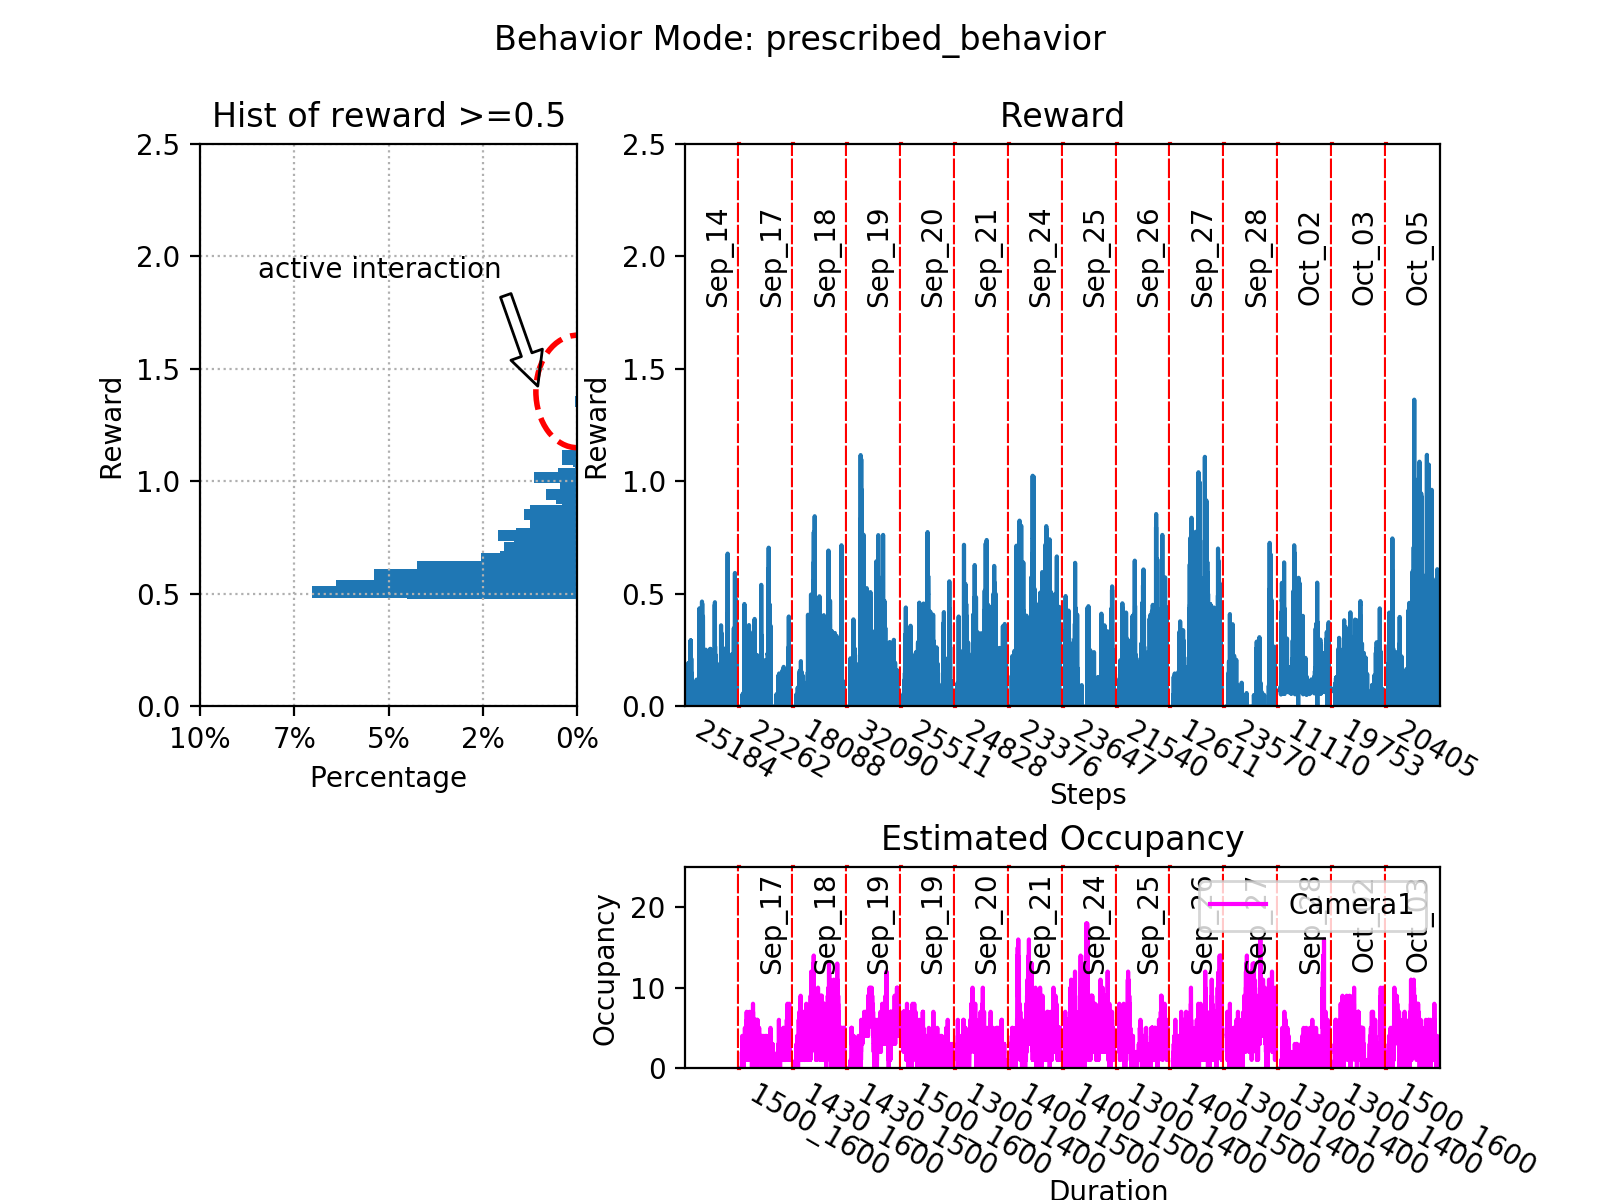

para_learning_agent: 13 segments
grid_h:3, grid_w:23, segment_num:14


<IPython.core.display.Javascript object>


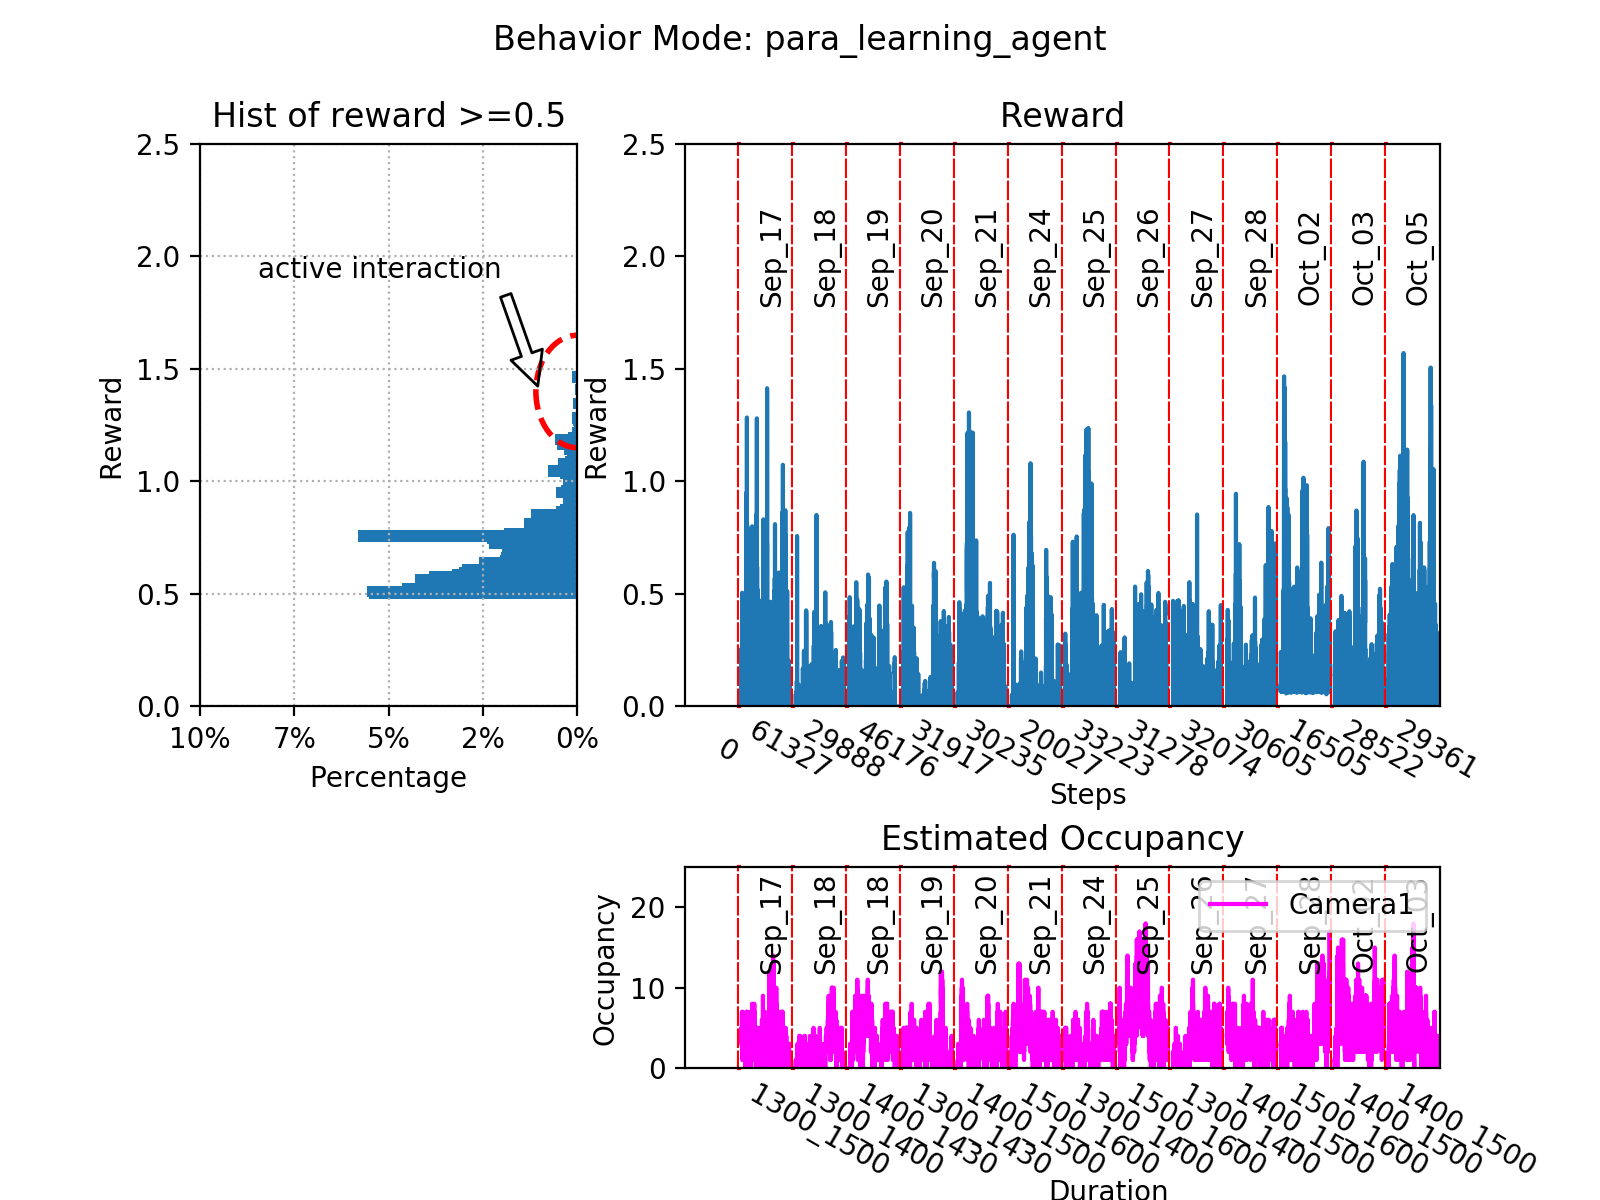

single_agent_raw_act: 4 segments
grid_h:3, grid_w:7, segment_num:4


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


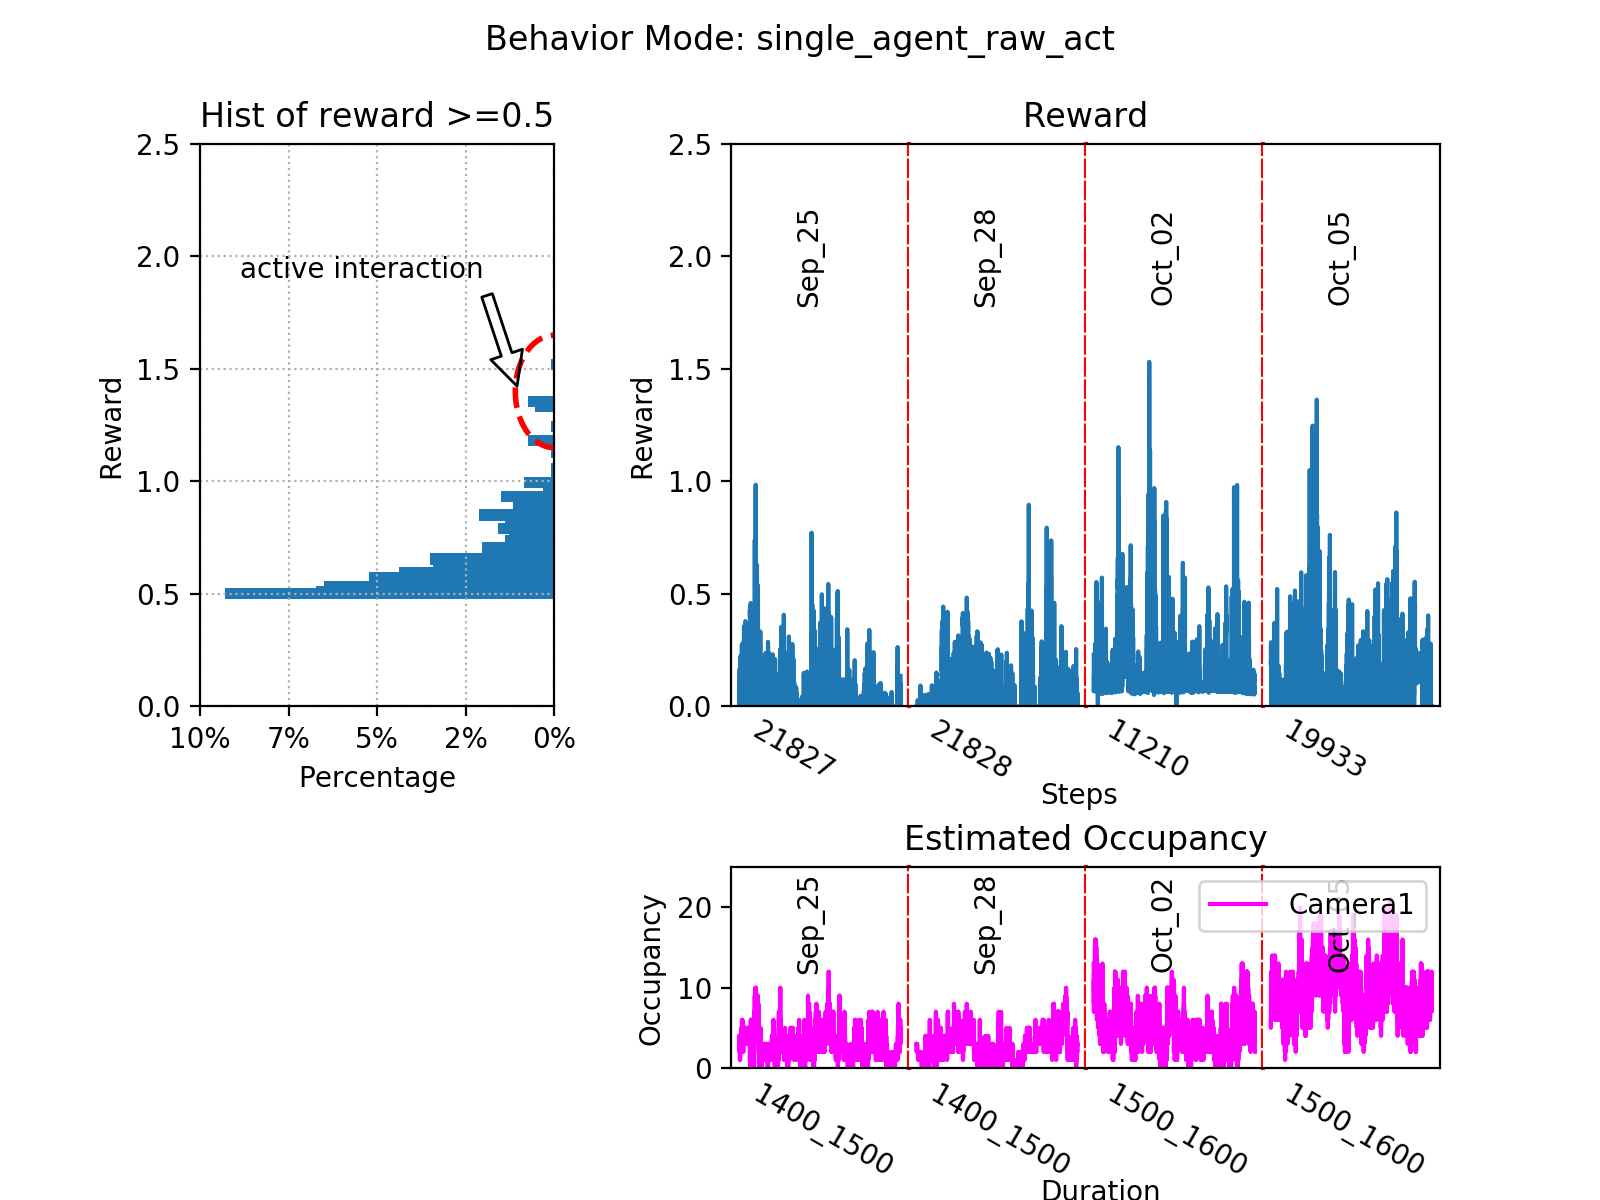

agent_coummunity_raw_act: 4 segments
grid_h:3, grid_w:7, segment_num:4


<IPython.core.display.Javascript object>


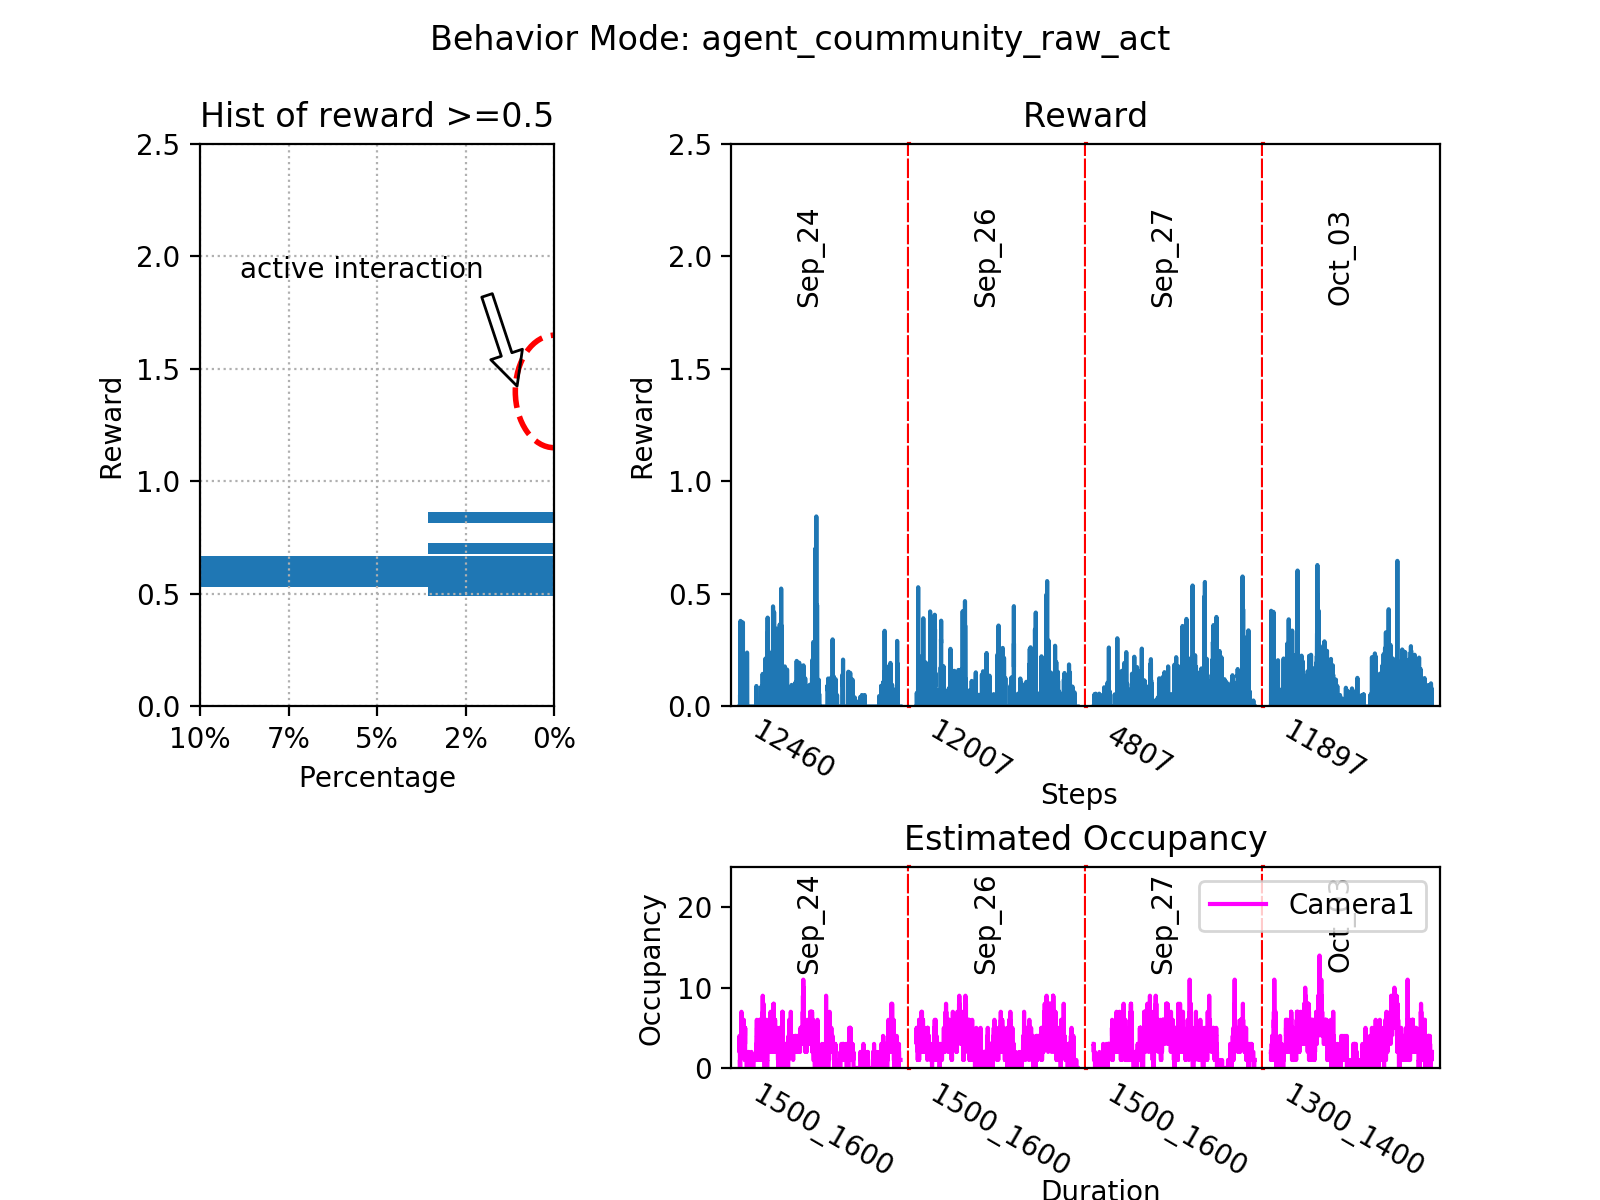

In [13]:
plot_reward_from_one_behavior_mode(prescribed_behavior,
                                   occupancy_camera1_prescribed_behavior,
                                   occupancy_camera2_prescribed_behavior,
                                   'prescribed_behavior')
plot_reward_from_one_behavior_mode(para_learning_agent, 
                                   occupancy_camera1_para_learning_agent,
                                   occupancy_camera2_para_learning_agent,
                                   'para_learning_agent')
plot_reward_from_one_behavior_mode(single_agent_raw_act, 
                                   occupancy_camera1_single_agent_raw_act,
                                   occupancy_camera2_single_agent_raw_act,
                                   'single_agent_raw_act')
plot_reward_from_one_behavior_mode(agent_coummunity_raw_act, 
                                   occupancy_camera1_agent_coummunity_raw_act,
                                   occupancy_camera2_agent_coummunity_raw_act,
                                   'agent_coummunity_raw_act')

## Reward and Occupancy

prescribed_behavior: 14 segments
grid_h:3, grid_w:23, segment_num:14


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


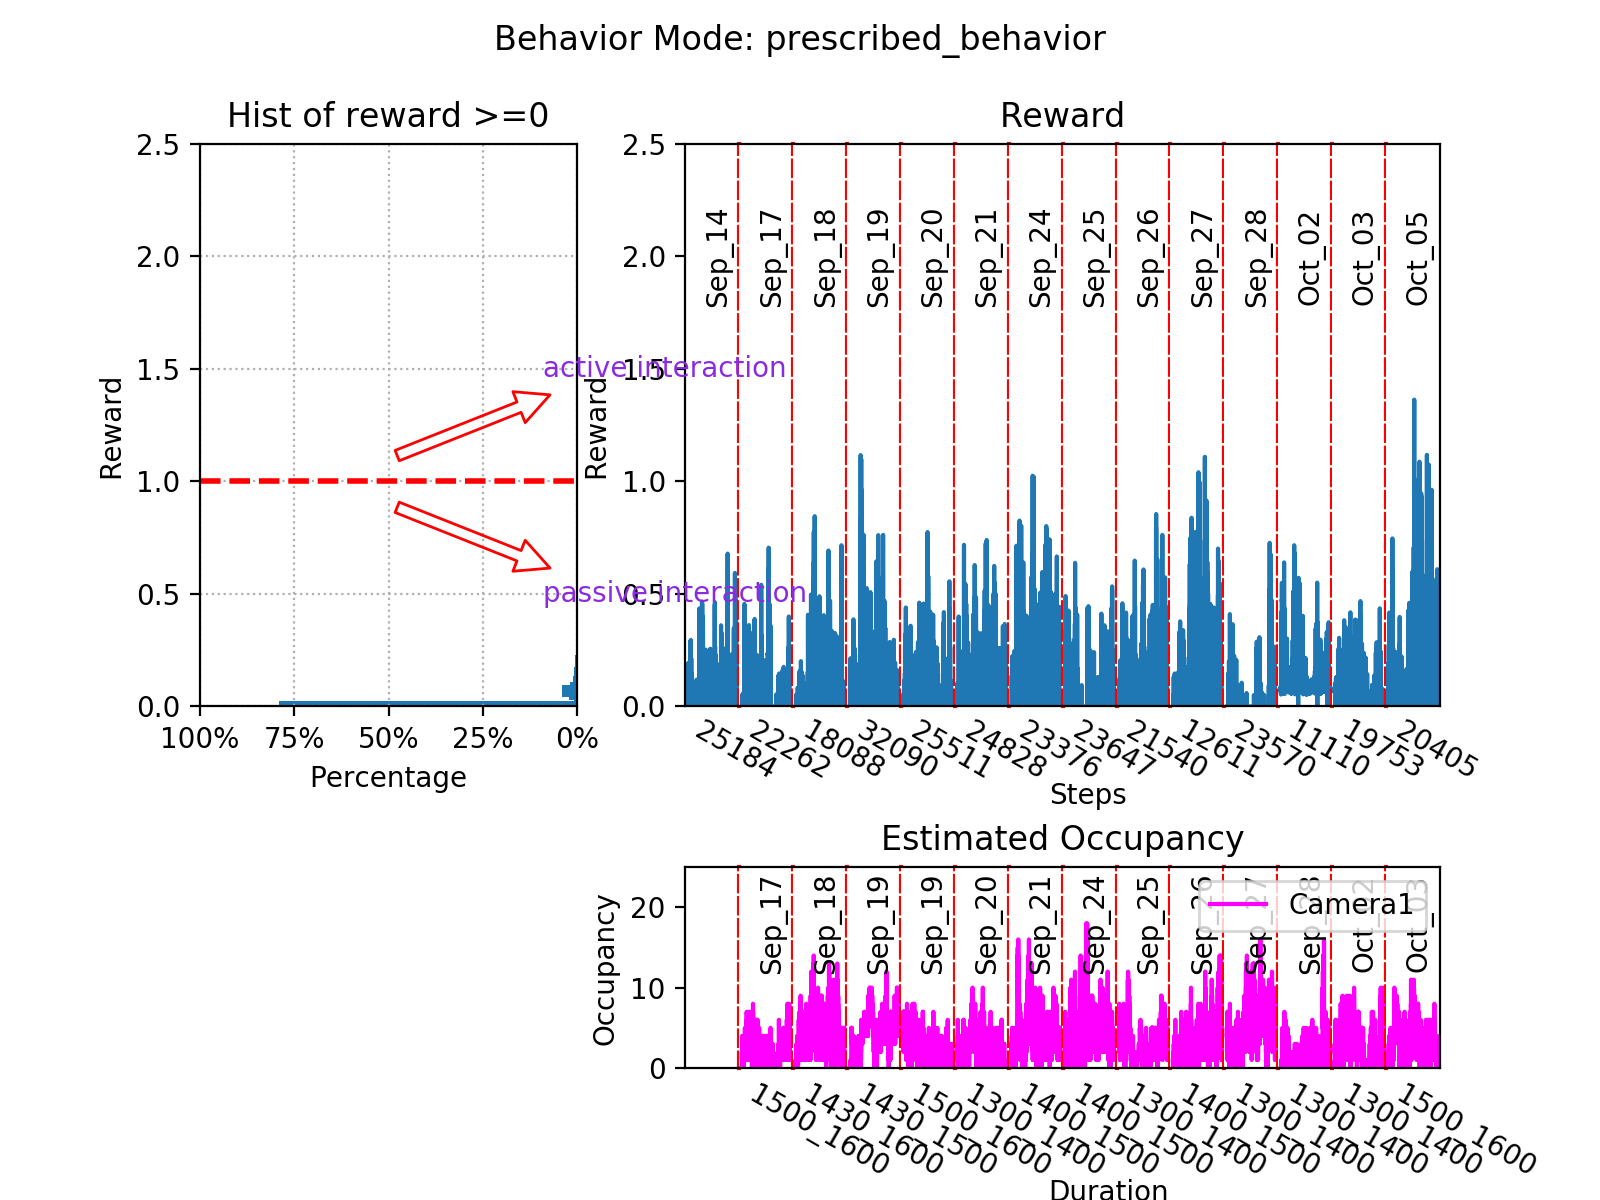

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


para_learning_agent: 13 segments
grid_h:3, grid_w:23, segment_num:14


<IPython.core.display.Javascript object>


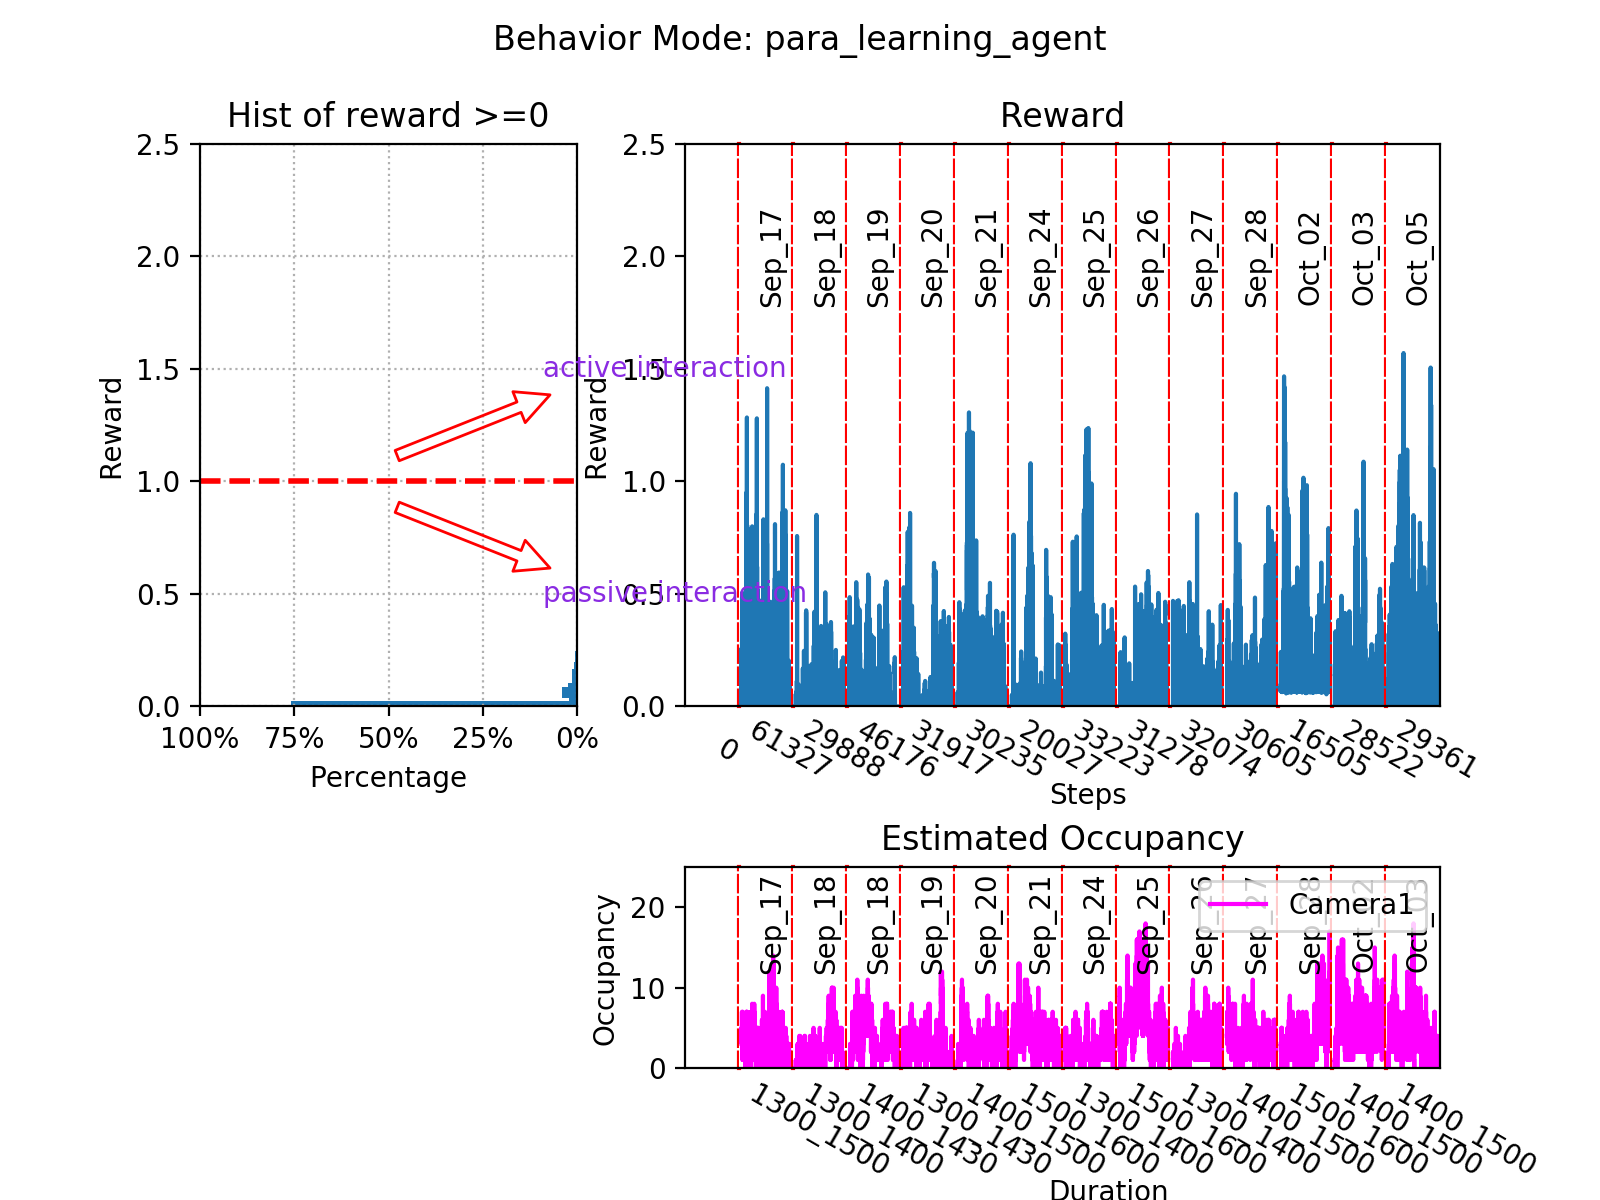

single_agent_raw_act: 4 segments
grid_h:3, grid_w:7, segment_num:4


<IPython.core.display.Javascript object>


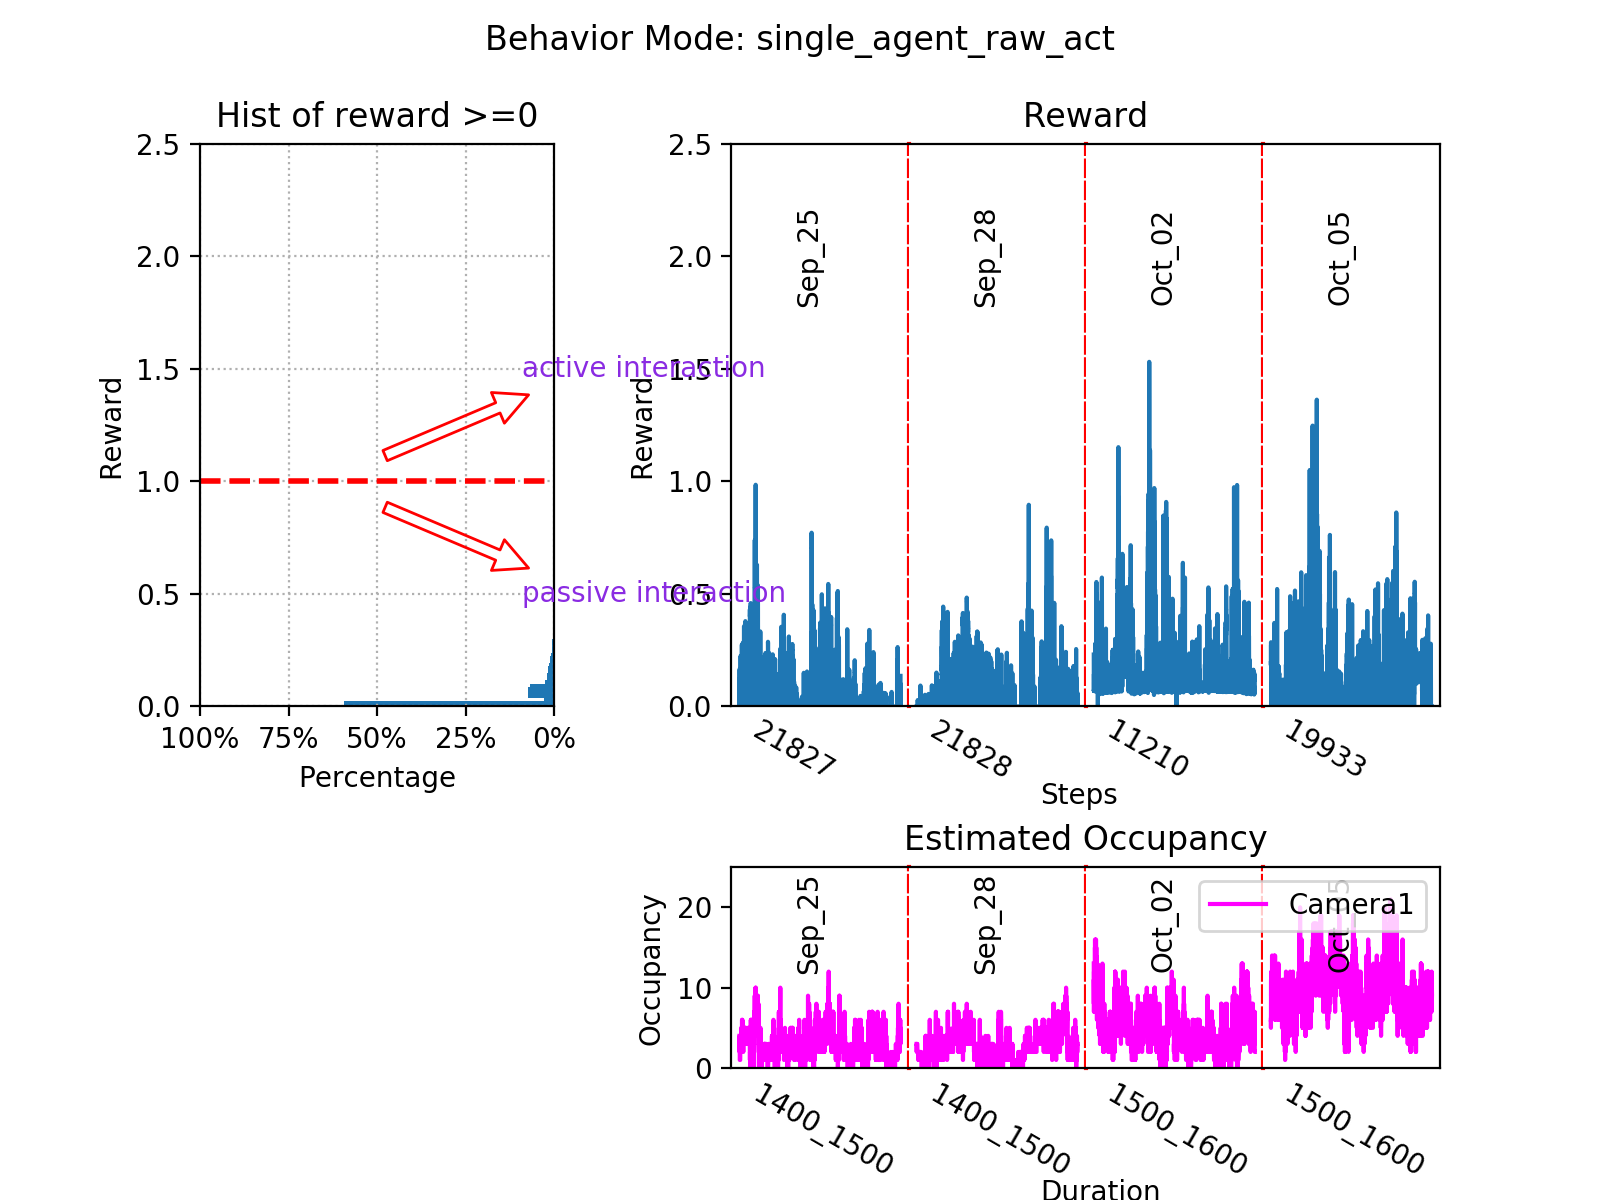

agent_coummunity_raw_act: 4 segments
grid_h:3, grid_w:7, segment_num:4


<IPython.core.display.Javascript object>


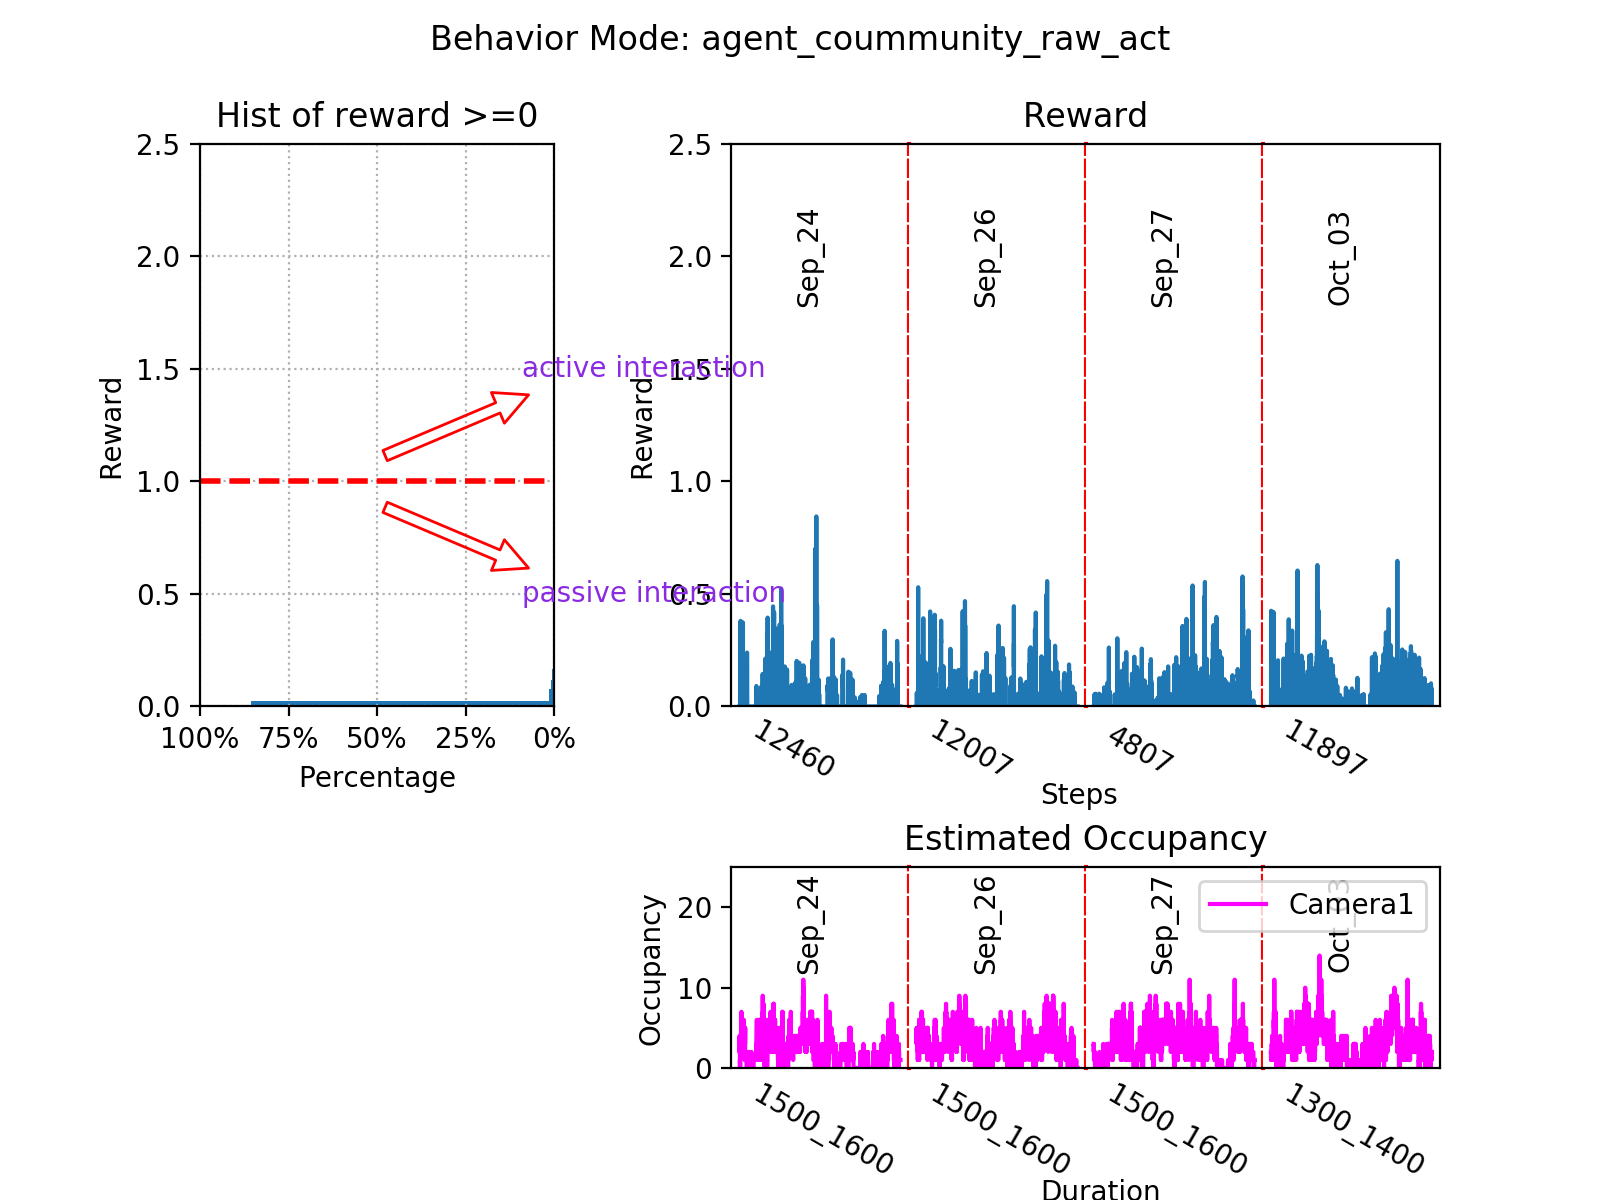

In [14]:
def plot_reward_from_one_behavior_mode(data, occupancy_camera1, occupancy_camera2, behavior_mode):
    """
    Args:
        behavior_mode (string):
            1. 'prescribed_behavior'
            2. 'para_learning_agent'
            3. 'single_agent_raw_act'
            4. 'agent_coummunity_raw_act'
    """
    segment_num = len(data['separate_line'])
    if behavior_mode == 'prescribed_behavior':
        print('prescribed_behavior: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+2
    if behavior_mode == 'para_learning_agent':
        print('para_learning_agent: {} segments'.format(segment_num))
        segment_num = segment_num + 1
        grid_w = int(segment_num*1.5)+2
    if behavior_mode == 'single_agent_raw_act':
        print('single_agent_raw_act: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+1
    if behavior_mode == 'agent_coummunity_raw_act':
        print('agent_coummunity_raw_act: {} segments'.format(segment_num))
        grid_w = int(segment_num*1.5)+1
    grid_h = 3
    print('grid_h:{}, grid_w:{}, segment_num:{}'.format(grid_h, grid_w, segment_num))
    ########################################
    #             Create Axes              #
    ########################################
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle('Behavior Mode: {}'.format(behavior_mode))
    grid = plt.GridSpec(grid_h, grid_w, hspace=0.8, wspace=0)
    # 1. Main ax
    main_ax = []
    for i in range(segment_num):
        if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
            main_ax.append(fig.add_subplot(grid[:int(grid_h*2/3), 2+(int(grid_w/3))+i:2+(int(grid_w/3))+i+1]))
        else:
            main_ax.append(fig.add_subplot(grid[:int(grid_h*2/3), 1+(int(grid_w/3))+i:1+(int(grid_w/3))+i+1]))
    # 2. Reward hist ax
    reward_hist_ax = fig.add_subplot(grid[:int(grid_h*2/3), :(int(grid_w/3))], sharey=main_ax[0])
    # 3. Ocuupancy ax  
    occupancy_ax = []
    for i in range(segment_num):
        if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
            occupancy_ax.append(fig.add_subplot(grid[int(grid_h*2/3):, 2+(int(grid_w/3))+i:2+(int(grid_w/3))+i+1]))
        else:
            occupancy_ax.append(fig.add_subplot(grid[int(grid_h*2/3):, 1+(int(grid_w/3))+i:1+(int(grid_w/3))+i+1]))
    ########################################
    #                 Plot                 #
    ########################################
    # 1. plot reward
    reward_data = data['data']['reward_IR_distance'].astype(float).values
    for i, main_ax_tmp in enumerate(main_ax):
        if behavior_mode != 'para_learning_agent':
            if i != 0:
                y = reward_data[data['separate_line'][i-1]:data['separate_line'][i]]
            else:
                y = reward_data[:data['separate_line'][i]]
            main_ax_tmp.text(len(y)*0.35, 2, data['date'][i], rotation=90, verticalalignment='center')
            
        else:
            if i == 0:
                y = np.zeros(0)
            else:
                temp_i = i-1
                if temp_i != 0:
                    y = reward_data[data['separate_line'][temp_i-1]:data['separate_line'][temp_i]]
                else:
                    y = reward_data[:data['separate_line'][temp_i]]
                main_ax_tmp.text(len(y)*0.35, 2, data['date'][temp_i], rotation=90, verticalalignment='center')
        # plot steps for each day
        steps = len(y)
        main_ax_tmp.text(len(y)*0.05, -0.2, '{}'.format(steps), rotation=-30, verticalalignment='center')
        # plot xlabel in the middle
        if i == int(len(main_ax)/2): 
            main_ax[i].text(-len(y)*(1/3), -0.4, 'Steps', verticalalignment='center')
        
        main_ax_tmp.plot(np.arange(len(y)), y)

        main_ax_tmp.set_ylim(0,2.5,0.25)
        main_ax_tmp.set_xticks(np.arange(0,len(y),5000))
        main_ax_tmp.tick_params(axis='x', rotation=10)
        main_ax_tmp.tick_params(bottom='off', labelbottom='off')
        if i != 0:
            main_ax_tmp.tick_params(left='off', labelleft='off')
            main_ax_tmp.spines['left'].set_visible(False)
        if i != len(main_ax)-1:
            main_ax_tmp.spines['right'].set_linestyle('--')
            main_ax_tmp.spines['right'].set_linewidth(1.5)
            main_ax_tmp.spines['right'].set_color('r')
    main_ax[0].set_ylabel('Reward')
    title_main_ax = int(len(main_ax)/2)
    main_ax[title_main_ax].set_title('Reward',position=(0,1))
    
    #main_ax[title_main_ax].set_xlabel('Steps', position=(0,-0.5))
    
    # 2. plot hist
    hist_reward_threshold = 0#0.5#1.0#0.75
    hist_data = reward_data[reward_data>=hist_reward_threshold]
    results, edges = np.histogram(hist_data, bins = 100)
    percentage = (results / sum(results)) * 100
    binWidth = 0.05
    reward_hist_ax.barh(edges[:-1], percentage, binWidth)
    # draw horizontal line
    active_passive_boundary = 1
    reward_hist_ax.axhline(y = active_passive_boundary, color = 'r', linestyle='--', linewidth=2)
    # annotate
    reward_hist_ax.text(9, 1.5, 'active interaction', verticalalignment='center', color='blueviolet')
    reward_hist_ax.text(9, 0.5, 'passive interaction', verticalalignment='center', color='blueviolet')
    reward_hist_ax.annotate("", xy=(1, 5), xytext=(9, 1.5),
                            arrowprops=dict(arrowstyle="->"))
    reward_hist_ax.annotate('',
                            xy=(5, 1.4), xycoords='data',
                            xytext=(0.5, 0.44), textcoords='axes fraction',
                            arrowprops=dict(facecolor='black', shrink=0.05, fill=False, color='r'),
                            horizontalalignment='right', verticalalignment='top')
    reward_hist_ax.annotate('',
                            xy=(5, 0.6), xycoords='data',
                            xytext=(0.5, 0.36), textcoords='axes fraction',
                            arrowprops=dict(facecolor='black', shrink=0.05, fill=False, color='r'),
                            horizontalalignment='right', verticalalignment='top')
    from matplotlib.ticker import FuncFormatter
    formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
    reward_hist_ax.xaxis.set_major_formatter(formatter)
    reward_hist_ax.set_xlim(0,100)
    reward_hist_ax.set_xlabel('Percentage')
    reward_hist_ax.set_ylabel('Reward')
    reward_hist_ax.invert_xaxis()
    reward_hist_ax.set_title('Hist of reward >={}'.format(hist_reward_threshold))
    reward_hist_ax.grid(True, linestyle=':')
    
    # 3. plot occupancy Camera1
    occupancy_data_camera1 = occupancy_camera1['data']['Occupancy'].astype(float).values
    for i, occupancy_ax_tmp in enumerate(occupancy_ax):
        temp_i = i
        if i == 0 and (behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent'): # lost video on Sep_14
            y = np.zeros(1)
        else:
            if behavior_mode == 'prescribed_behavior' or behavior_mode == 'para_learning_agent':
                temp_i = i-1
            
            if temp_i != 0:
                #print("occupancy_camera1['separate_line']:{}".format(len(occupancy_camera1['separate_line'])))
                y = occupancy_data_camera1[occupancy_camera1['separate_line'][temp_i-1]:occupancy_camera1['separate_line'][temp_i]]
            else:
                y = occupancy_data_camera1[:occupancy_camera1['separate_line'][temp_i]]
            
            if temp_i <= len(occupancy_camera1['date'])-1:
                #print('temp_i:{}, {}'.format(temp_i, occupancy_camera1['date'][temp_i]))
                d = occupancy_camera1['date'][temp_i][:6]
                t = occupancy_camera1['date'][temp_i][7:]
                occupancy_ax_tmp.text(len(y)*0.35, 18, d, rotation=90, verticalalignment='center')
                occupancy_ax_tmp.text(len(y)*0.05, -8, t, rotation=-30, verticalalignment='center')
        # plot xlabel in the middle
        if i == int(len(occupancy_ax)/2): 
            occupancy_ax[i].text(-len(y)*(1/3), -15.5, 'Duration', verticalalignment='center')
        #print('i:{}'.format(i))
        occupancy_ax_tmp.plot(np.arange(len(y)), y, color = 'fuchsia')

        occupancy_ax_tmp.set_ylim(0,25)
        occupancy_ax_tmp.set_xticks(np.arange(0,len(y),5000))
        occupancy_ax_tmp.tick_params(axis='x', rotation=10)
        occupancy_ax_tmp.tick_params(bottom='off',labelbottom='off')
        if i != 0:
            occupancy_ax_tmp.tick_params(left='off', labelleft='off')
            occupancy_ax_tmp.spines['left'].set_visible(False)
        if i != len(main_ax)-1:
            occupancy_ax_tmp.spines['right'].set_linestyle('--')
            occupancy_ax_tmp.spines['right'].set_linewidth(1.5)
            occupancy_ax_tmp.spines['right'].set_color('r')
    occupancy_ax[0].set_ylabel('Occupancy')
    occupancy_ax[-1].legend(['Camera1'])
    title_occupancy_ax = int(len(occupancy_ax)/2)
    occupancy_ax[title_occupancy_ax].set_title('Estimated Occupancy',position=(0,1))        
    plt.savefig('reward_hist_occupancy_{}.png'.format(behavior_mode), dpi=300)

    
plot_reward_from_one_behavior_mode(prescribed_behavior,
                                   occupancy_camera1_prescribed_behavior,
                                   occupancy_camera2_prescribed_behavior,
                                   'prescribed_behavior')
plot_reward_from_one_behavior_mode(para_learning_agent, 
                                   occupancy_camera1_para_learning_agent,
                                   occupancy_camera2_para_learning_agent,
                                   'para_learning_agent')
plot_reward_from_one_behavior_mode(single_agent_raw_act, 
                                   occupancy_camera1_single_agent_raw_act,
                                   occupancy_camera2_single_agent_raw_act,
                                   'single_agent_raw_act')
plot_reward_from_one_behavior_mode(agent_coummunity_raw_act, 
                                   occupancy_camera1_agent_coummunity_raw_act,
                                   occupancy_camera2_agent_coummunity_raw_act,
                                   'agent_coummunity_raw_act')

## Separate reward distribution: not finished

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


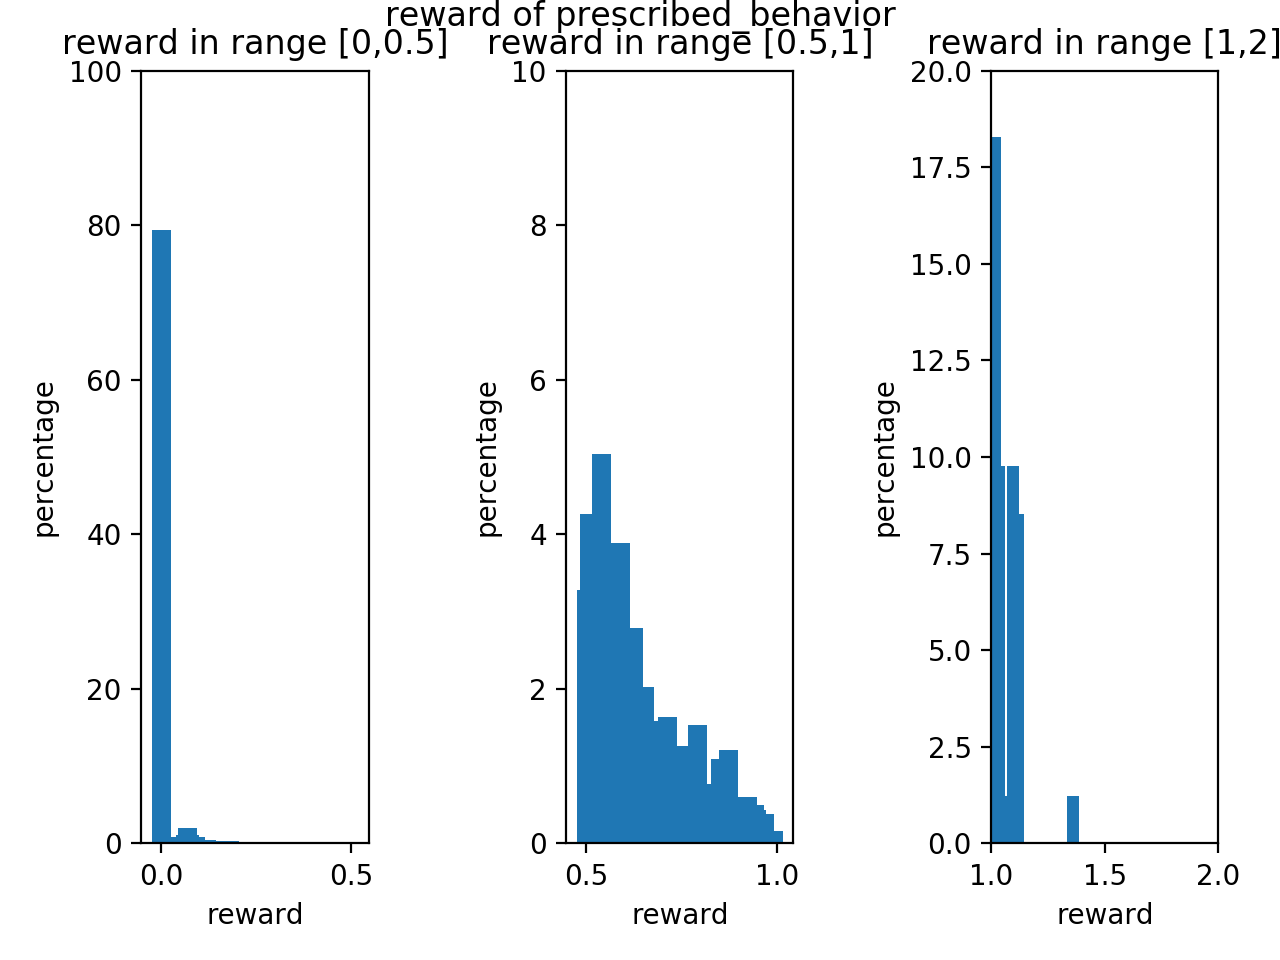

<IPython.core.display.Javascript object>


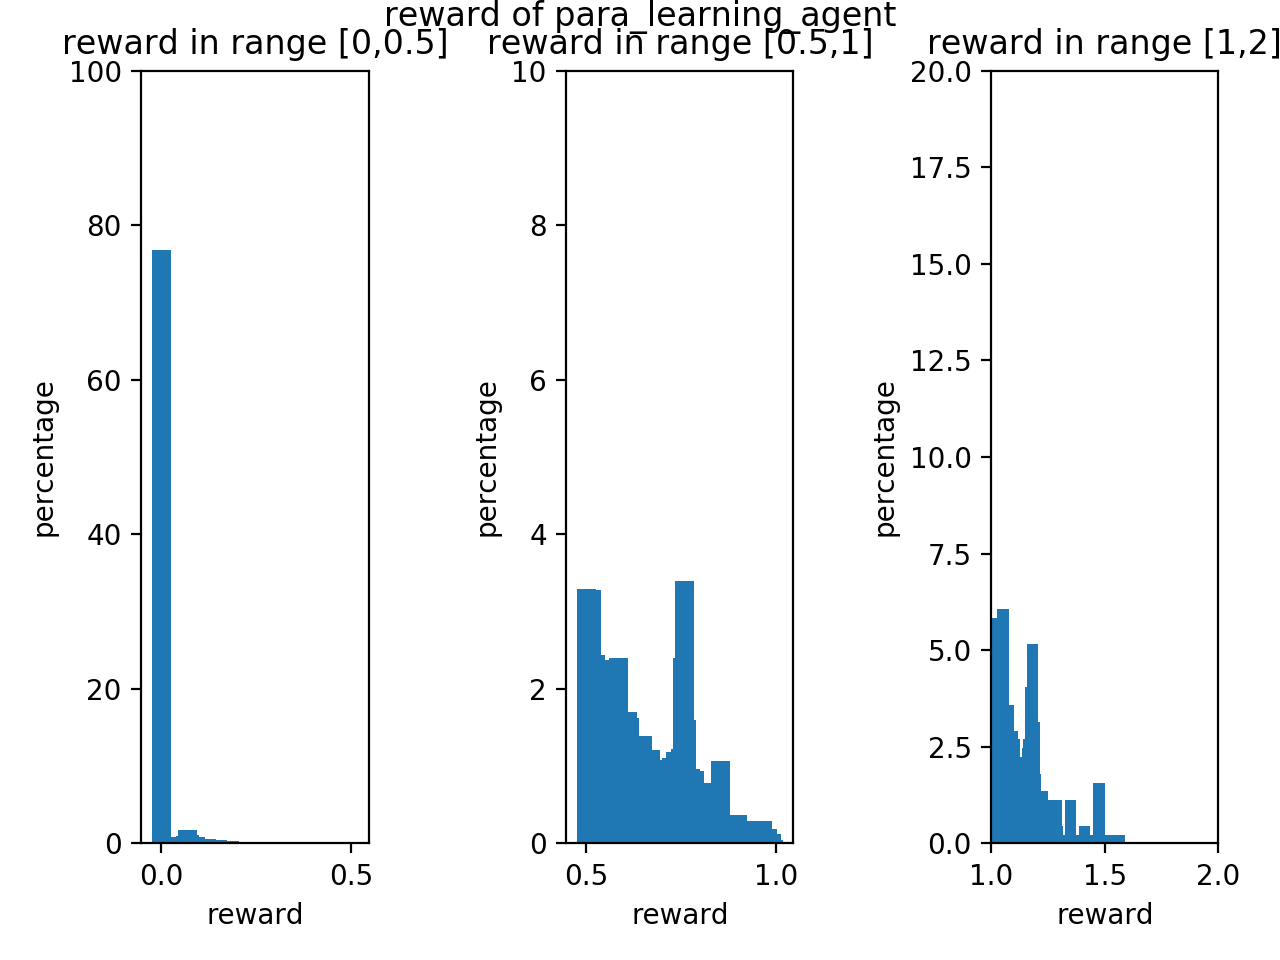

<IPython.core.display.Javascript object>


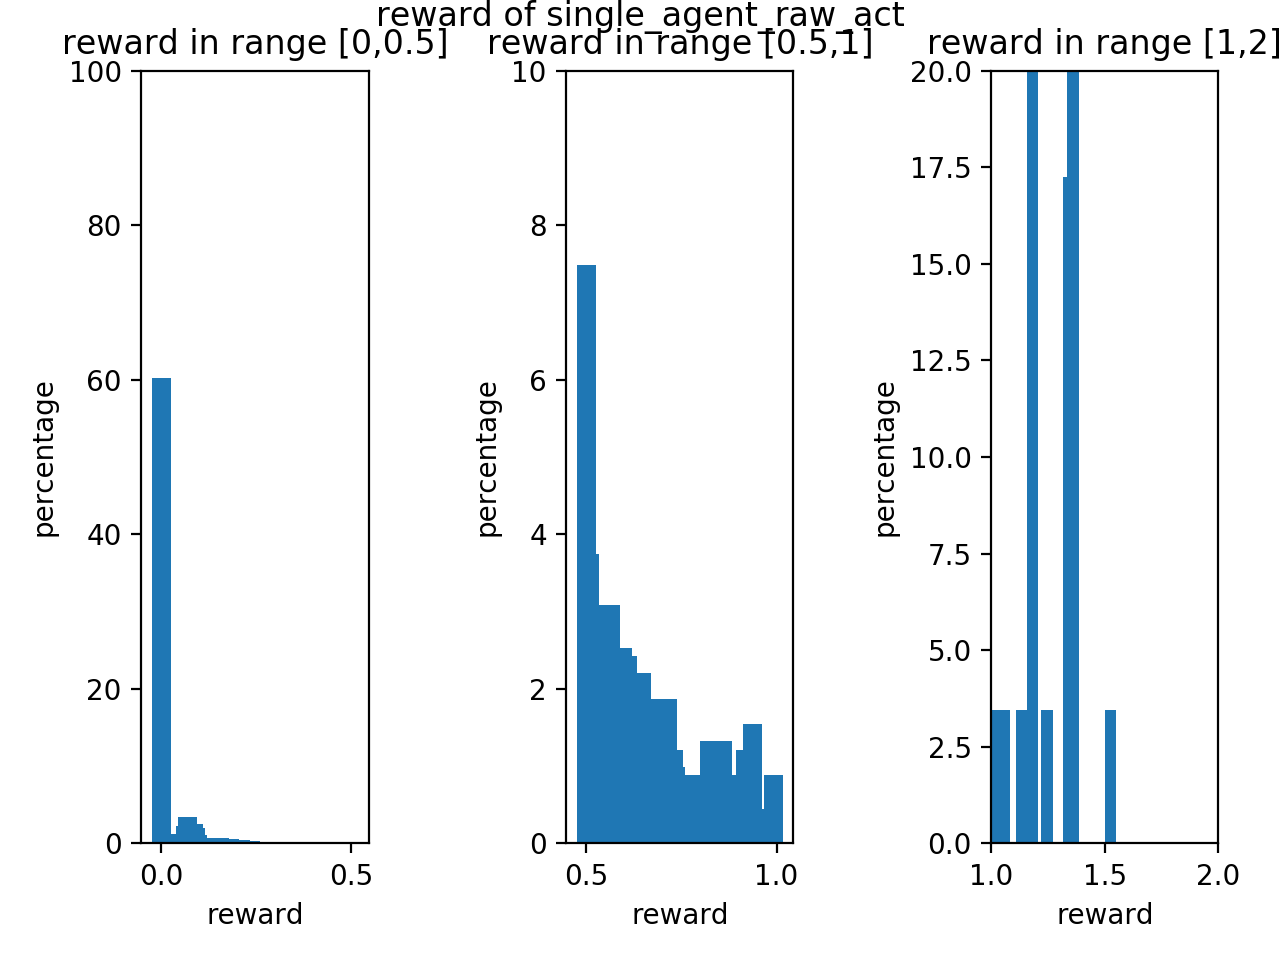

<IPython.core.display.Javascript object>


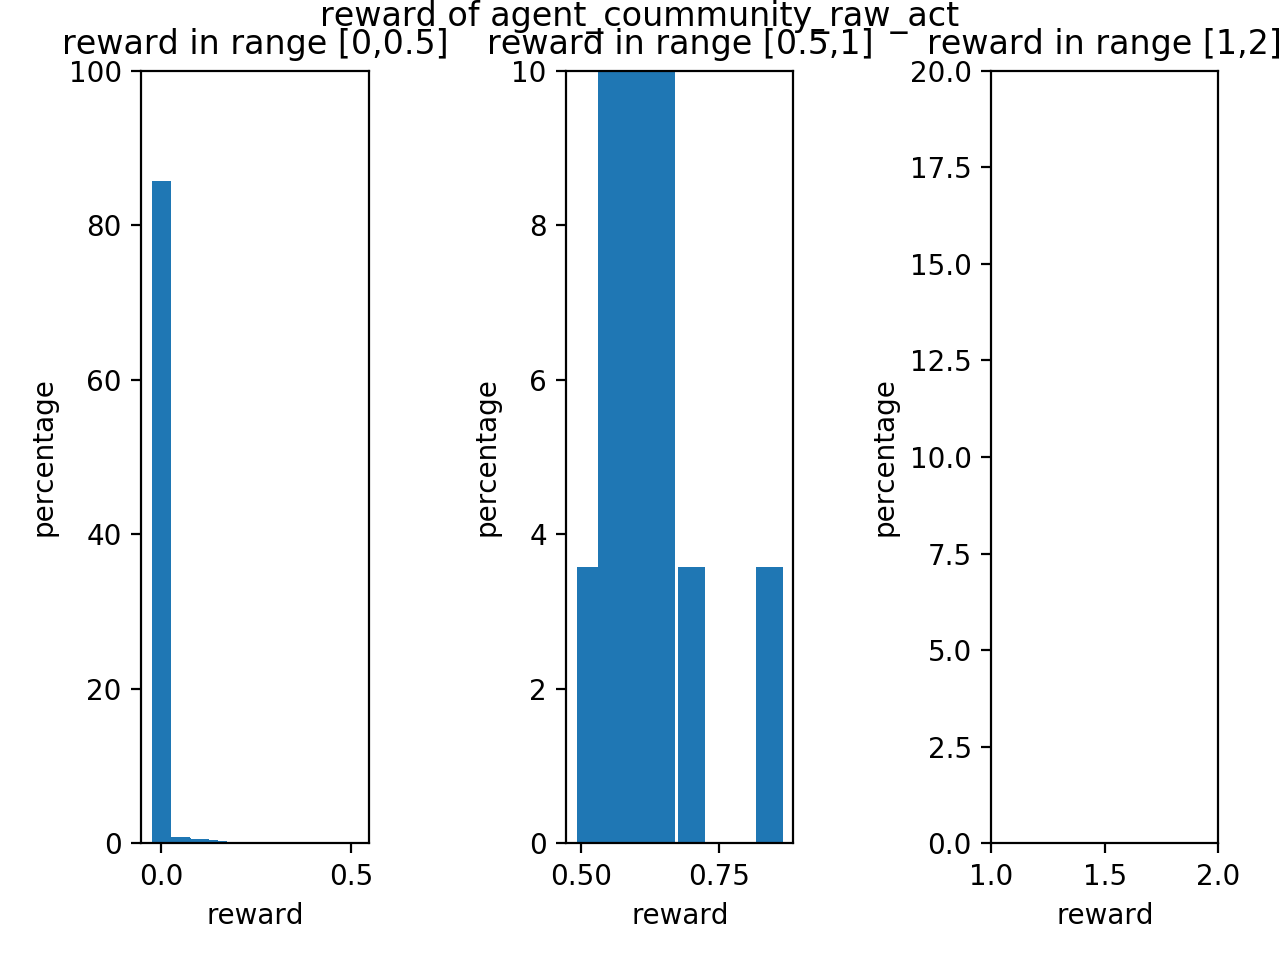

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [15]:
def separeted_reward_hist_of_each_behavior(data, behavior_mode=''):
    reward_data = data['data']['reward_IR_distance'].astype(float).values
    
    fig = plt.figure()
    #fig.suptitle('reward of {}'.format(behavior_mode))
    plt.suptitle('reward of {}'.format(behavior_mode), x=0.5, y=1)
    # 
    ax1 = plt.subplot(1,3,1.2)
    hist_reward_range = [0,0.5]
    hist_data = reward_data[reward_data>=hist_reward_range[0]]
    hist_data = hist_data[hist_data<hist_reward_range[1]]
    results, edges = np.histogram(hist_data, bins = 100)
    percentage = (results / sum(results)) * 100
    binWidth = 0.05
    ax1.bar(edges[:-1], percentage, binWidth)
    ax1.set_xlabel('reward')
    ax1.set_ylabel('percentage')
    ax1.set_ylim(0,100)
    ax1.set_title('reward in range [{},{}]'.format(hist_reward_range[0], hist_reward_range[1]))
    #
    ax2 = plt.subplot(1,3,2)
    hist_reward_range = [0.5,1]
    hist_data = reward_data[reward_data>=hist_reward_range[0]]
    hist_data = hist_data[hist_data<hist_reward_range[1]]
    results, edges = np.histogram(hist_data, bins = 100)
    percentage = (results / sum(results)) * 100
    binWidth = 0.05
    ax2.bar(edges[:-1], percentage, binWidth)
    ax2.set_xlabel('reward')
    ax2.set_ylabel('percentage')
    ax2.set_ylim(0,10)
    ax2.set_title('reward in range [{},{}]'.format(hist_reward_range[0], hist_reward_range[1]))
    #
    ax3 = plt.subplot(1,3,3)
    hist_reward_range = [1,2]
    hist_data = reward_data[reward_data>=hist_reward_range[0]]
    hist_data = hist_data[hist_data<hist_reward_range[1]]
    results, edges = np.histogram(hist_data, bins = 100)
    percentage = (results / sum(results)) * 100
    binWidth = 0.05
    ax3.bar(edges[:-1], percentage, binWidth)
    ax3.set_xlabel('reward')
    ax3.set_xlim(1, 2)
    ax3.set_ylabel('percentage')
    ax3.set_ylim(0,20)
    ax3.set_title('reward in range [{},{}]'.format(hist_reward_range[0], hist_reward_range[1]))
    
    plt.tight_layout()
    
separeted_reward_hist_of_each_behavior(prescribed_behavior, behavior_mode='prescribed_behavior')
separeted_reward_hist_of_each_behavior(para_learning_agent, behavior_mode='para_learning_agent')
separeted_reward_hist_of_each_behavior(single_agent_raw_act, behavior_mode='single_agent_raw_act')
separeted_reward_hist_of_each_behavior(agent_coummunity_raw_act, behavior_mode='agent_coummunity_raw_act')

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


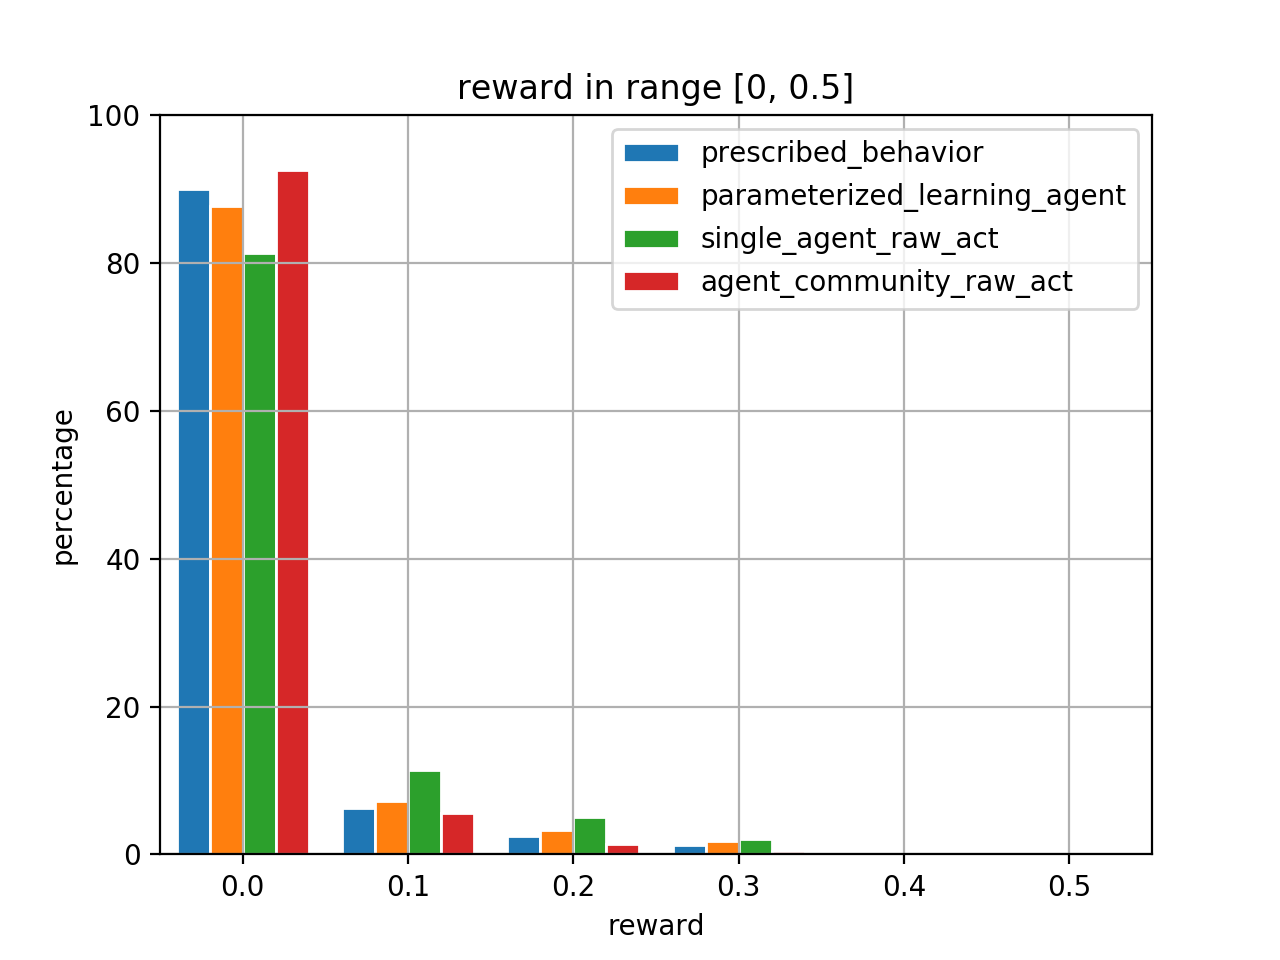

<IPython.core.display.Javascript object>


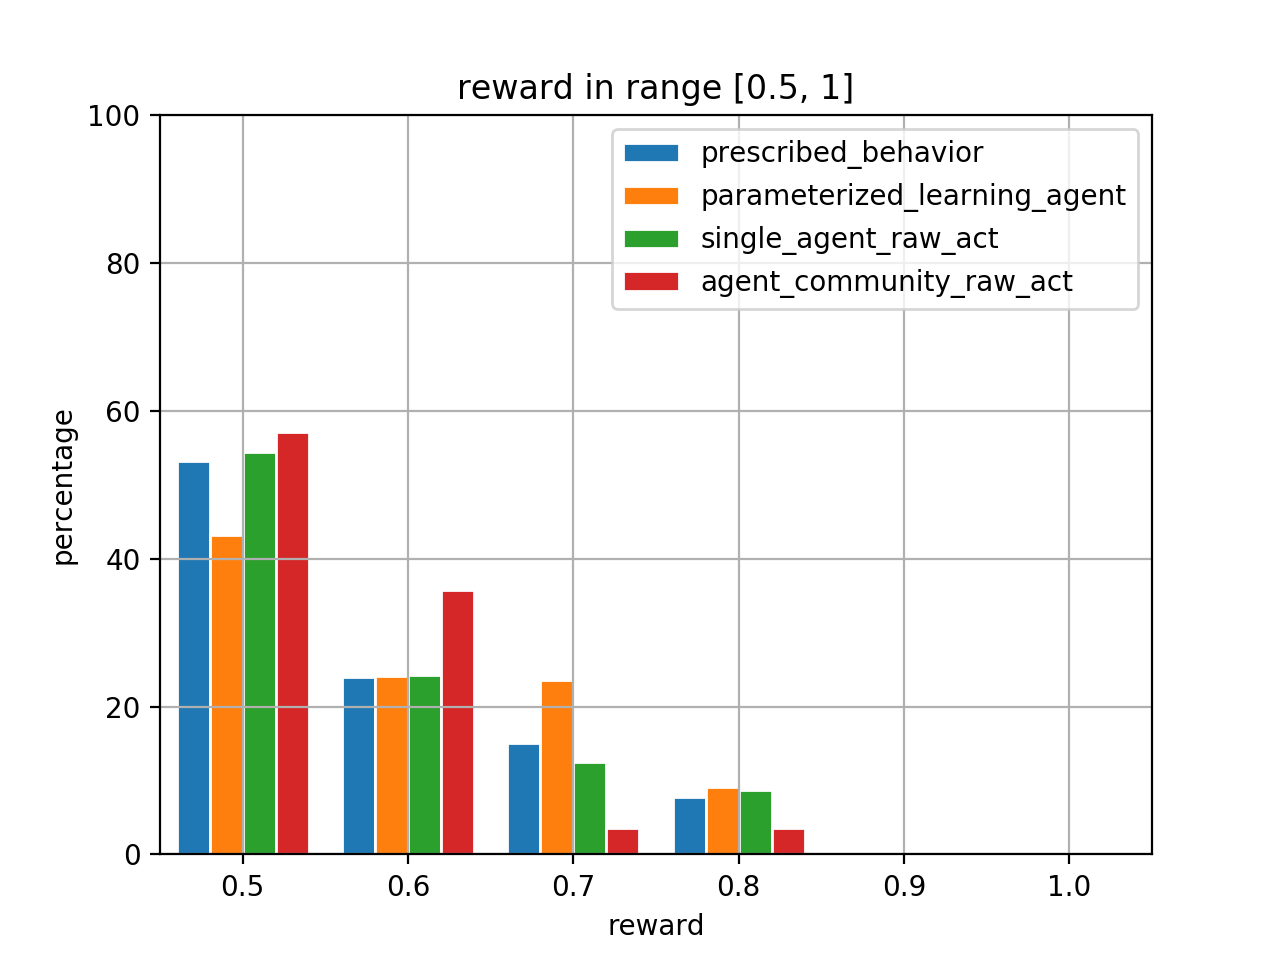

<IPython.core.display.Javascript object>


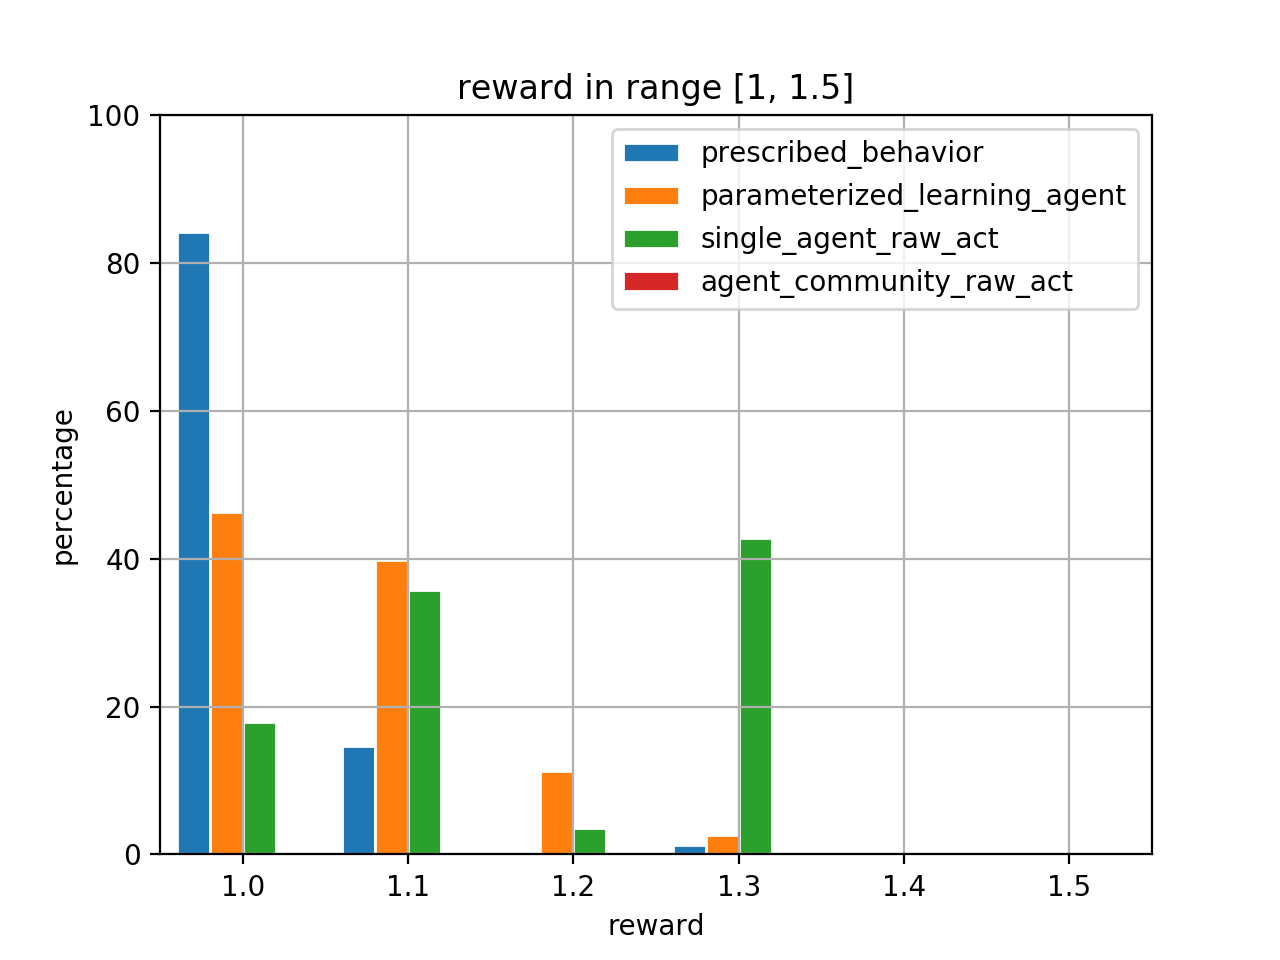

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


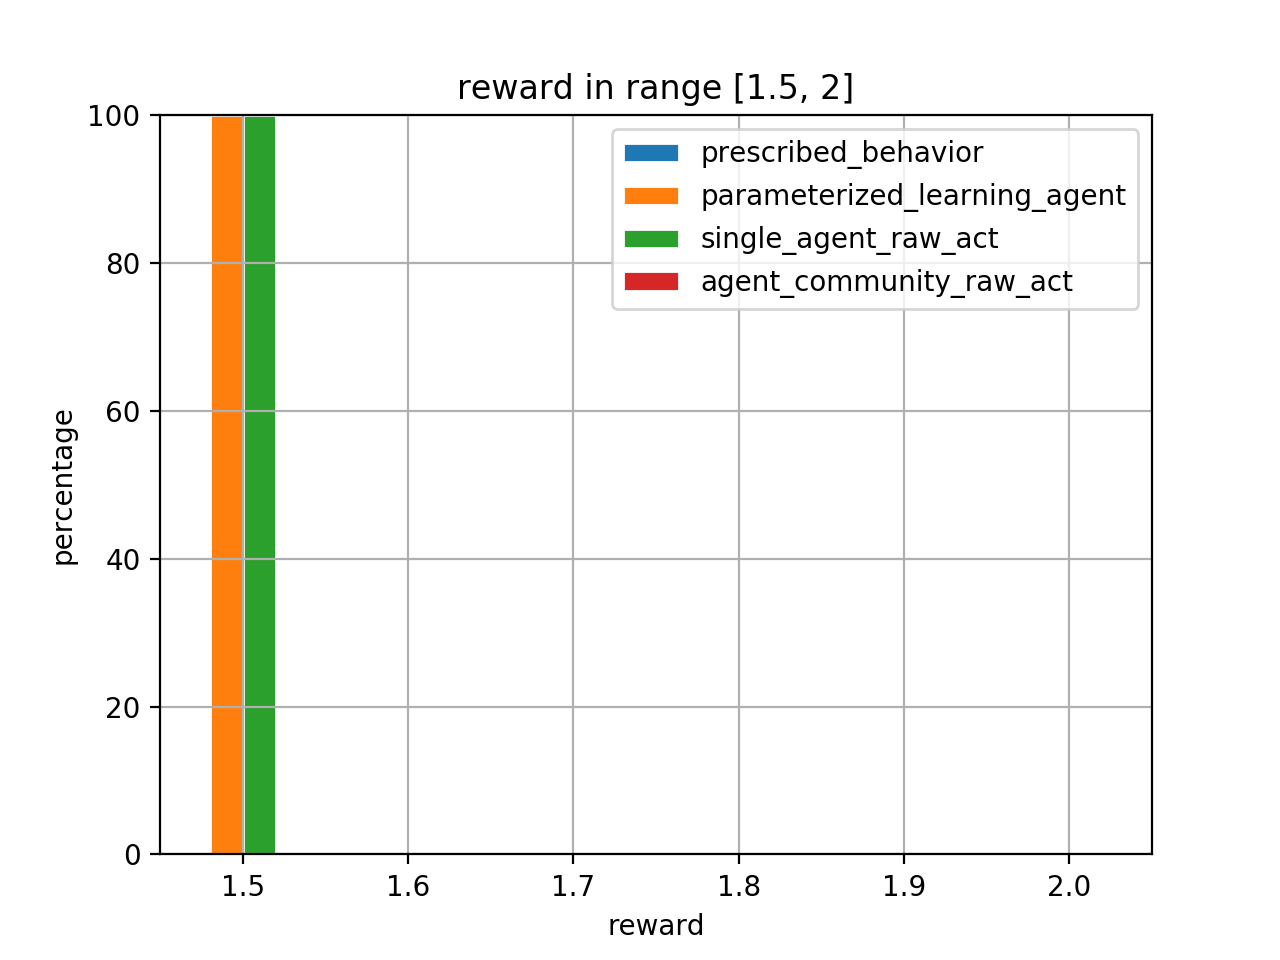

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [16]:
def plot_reward_hist(reward_low, reward_up, 
                     prescribed_behavior, 
                     para_learning_agent, 
                     single_agent_raw_act, 
                     agent_coummunity_raw_act):
    plt.figure()
    ax3 = plt.subplot(1,1,1)
    binWidth = 0.02
    binShift = [-1.5*binWidth, -0.5*binWidth, 0.5*binWidth, 1.5*binWidth]

    bin_low = reward_low
    bin_up = reward_up
    bin_step = 0.1
    bins = np.arange(bin_low, bin_up, bin_step)
    # Prescribed Behavior
    reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
    hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
    hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
    results_pb, edges_pb = np.histogram(hist_data_pb, bins)
    percentage_pb = (results_pb / sum(results_pb)) * 100

    ax3.bar(edges_pb[:-1]+binShift[0], percentage_pb, binWidth, edgecolor='white')

    # Parameterized Learning Agent
    reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
    hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
    hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
    results_pla, edges_pla = np.histogram(hist_data_pla, bins)
    percentage_pla = (results_pla / sum(results_pla)) * 100

    ax3.bar(edges_pla[:-1]+binShift[1], percentage_pla, binWidth, edgecolor='white')

    # Single Learning Agent Raw Act
    reward_data_sara = single_agent_raw_act['data']['reward_IR_distance'].astype(float).values
    hist_data_sara = reward_data_sara[reward_data_sara>=bin_low]
    hist_data_sara = hist_data_sara[hist_data_sara<bin_up]
    results_sara, edges_sara = np.histogram(hist_data_sara, bins)
    percentage_sara = (results_sara / sum(results_sara)) * 100

    ax3.bar(edges_sara[:-1]+binShift[2], percentage_sara, binWidth, edgecolor='white')

    # Agent Community Raw Act
    reward_data_acra = agent_coummunity_raw_act['data']['reward_IR_distance'].astype(float).values
    hist_data_acra = reward_data_acra[reward_data_acra>=bin_low]
    hist_data_acra = hist_data_acra[hist_data_acra<bin_up]
    results_acra, edges_acra = np.histogram(hist_data_acra, bins)
    percentage_acra = (results_acra / sum(results_acra)) * 100

    ax3.bar(edges_acra[:-1]+binShift[3], percentage_acra, binWidth, edgecolor='white')

    ax3.set_xlabel('reward')
    #ax3.set_xticks(bins)
    ax3.set_xlim(reward_low-bin_step*0.5, reward_up+bin_step*0.5)
    ax3.set_ylabel('percentage')
    ax3.set_ylim(0,100)
    ax3.set_title('reward in range [{}, {}]'.format(reward_low, reward_up))
    ax3.legend(['prescribed_behavior','parameterized_learning_agent','single_agent_raw_act','agent_community_raw_act'])
    ax3.grid(True)


# reward in range [0,0.5)
reward_low = 0
reward_up = 0.5
plot_reward_hist(reward_low, reward_up, prescribed_behavior, para_learning_agent, single_agent_raw_act, agent_coummunity_raw_act)

# reward in range [0.5,1)
reward_low = 0.5
reward_up = 1
plot_reward_hist(reward_low, reward_up, prescribed_behavior, para_learning_agent, single_agent_raw_act, agent_coummunity_raw_act)

# reward in range [1,1.5)
reward_low = 1
reward_up = 1.5
plot_reward_hist(reward_low, reward_up, prescribed_behavior, para_learning_agent, single_agent_raw_act, agent_coummunity_raw_act)

# reward in range [1.5,2)
reward_low = 1.5
reward_up = 2
plot_reward_hist(reward_low, reward_up, prescribed_behavior, para_learning_agent, single_agent_raw_act, agent_coummunity_raw_act)


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


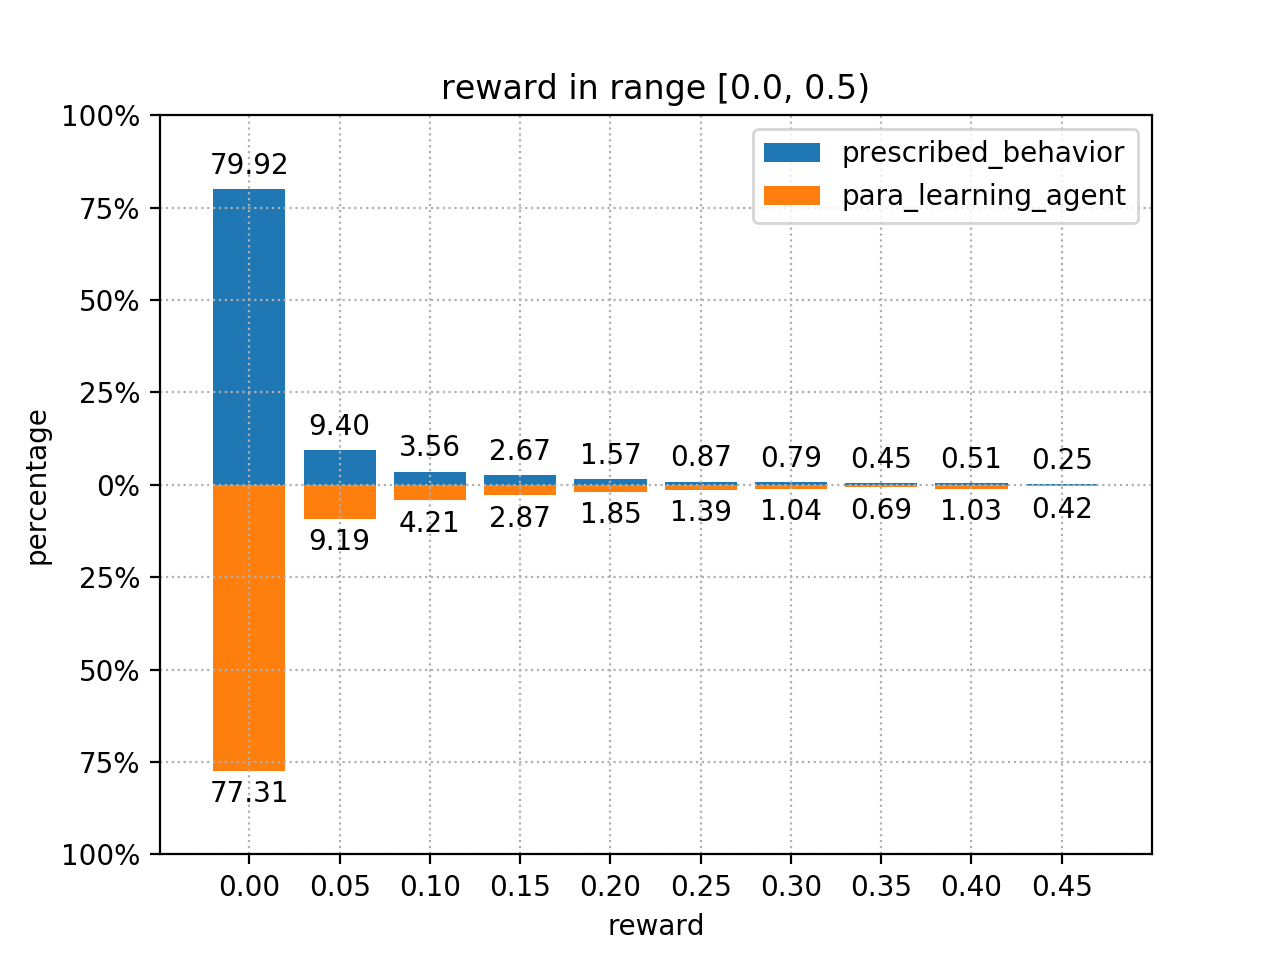

<IPython.core.display.Javascript object>


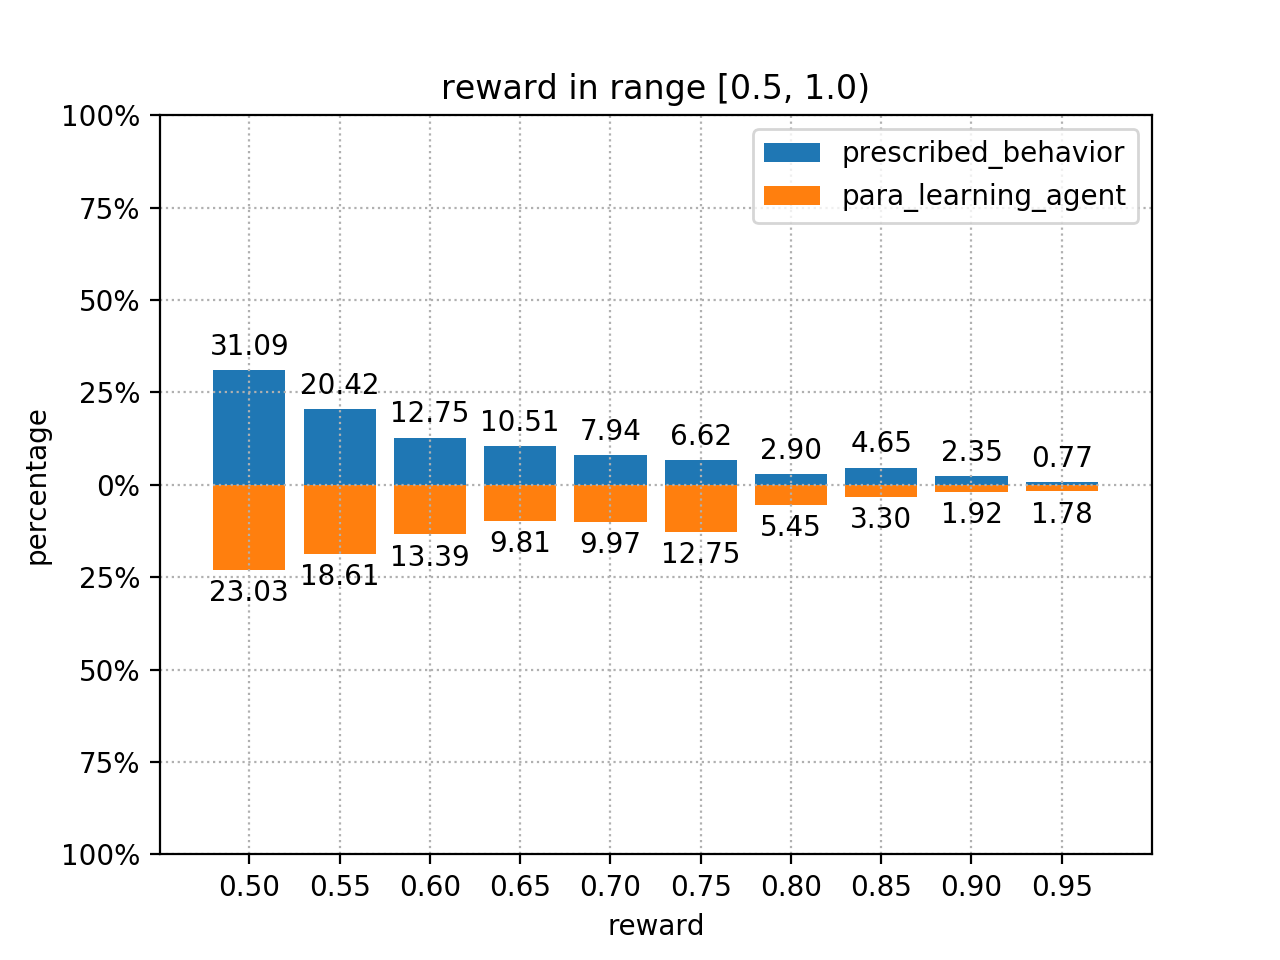

<IPython.core.display.Javascript object>


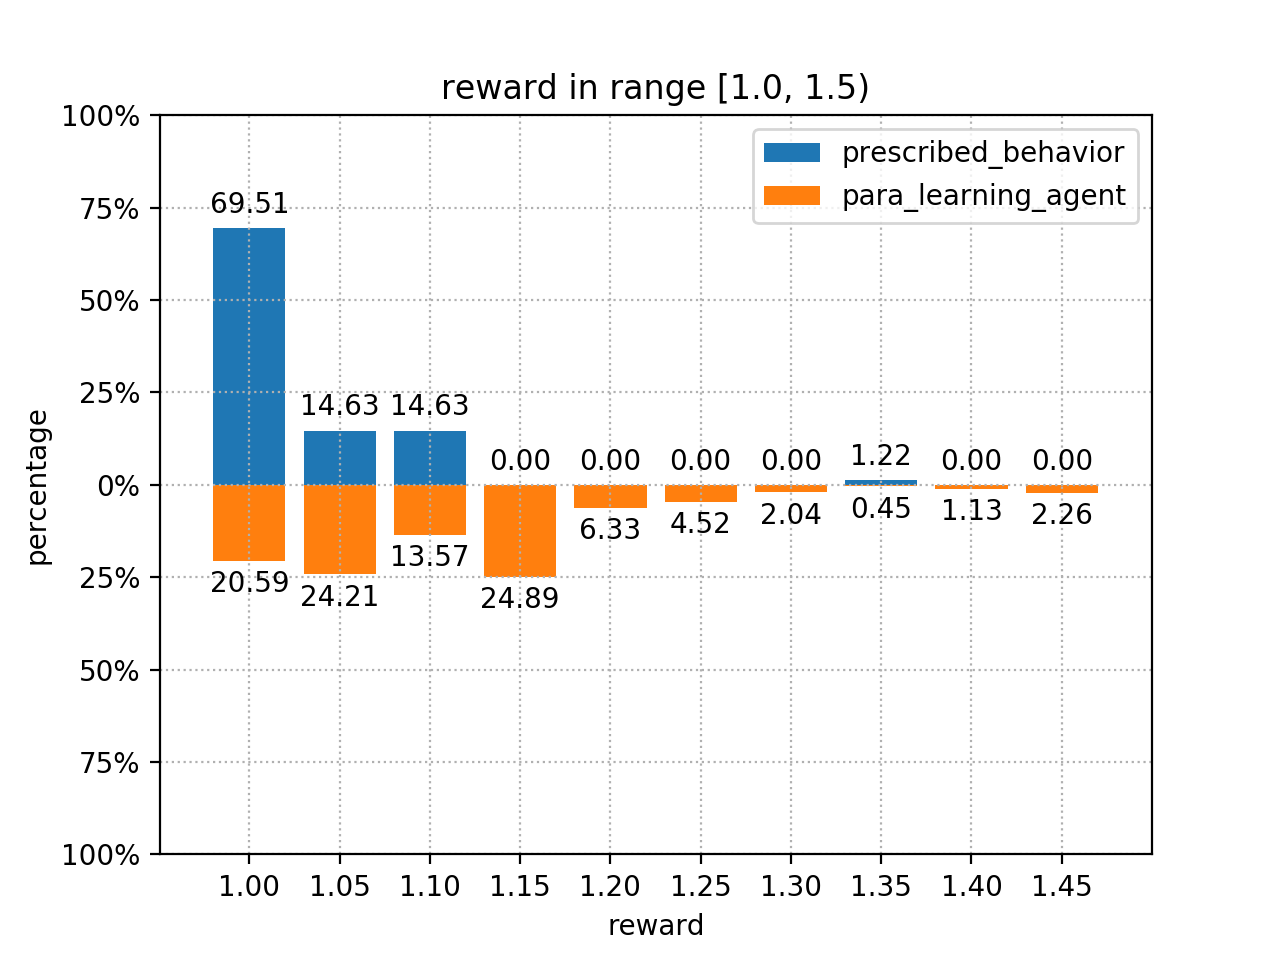

<IPython.core.display.Javascript object>


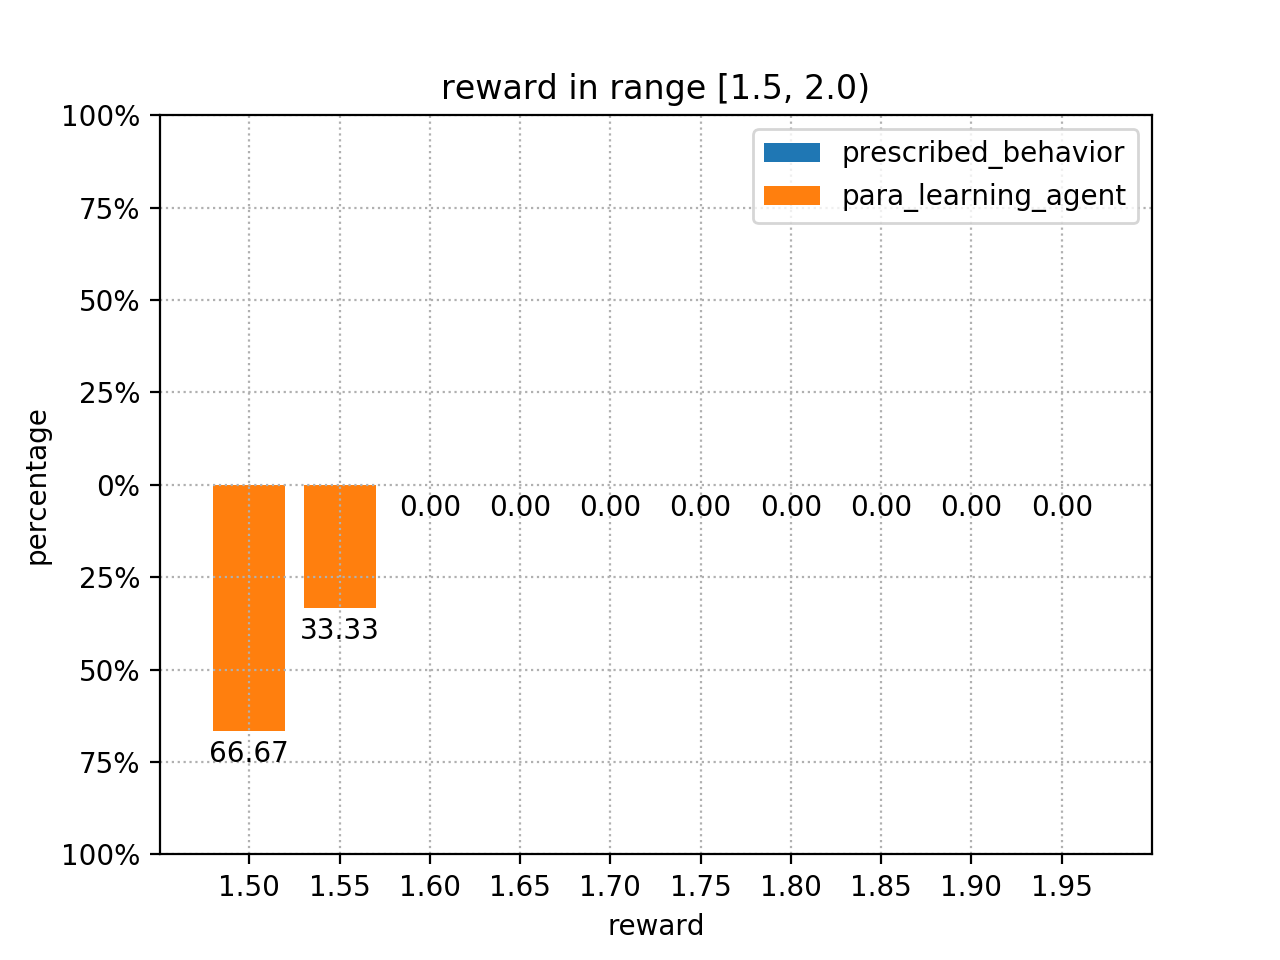

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


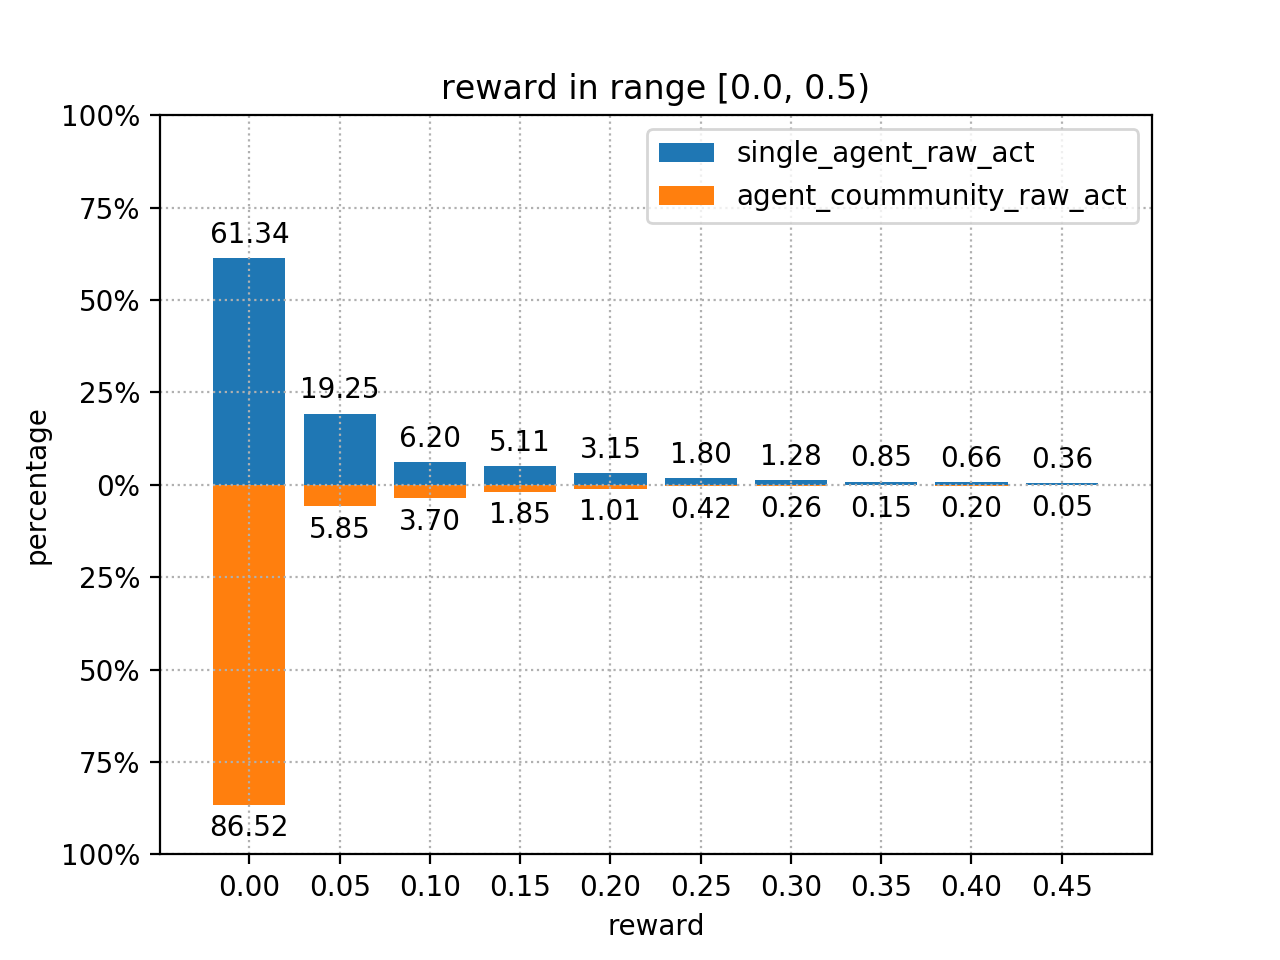

<IPython.core.display.Javascript object>


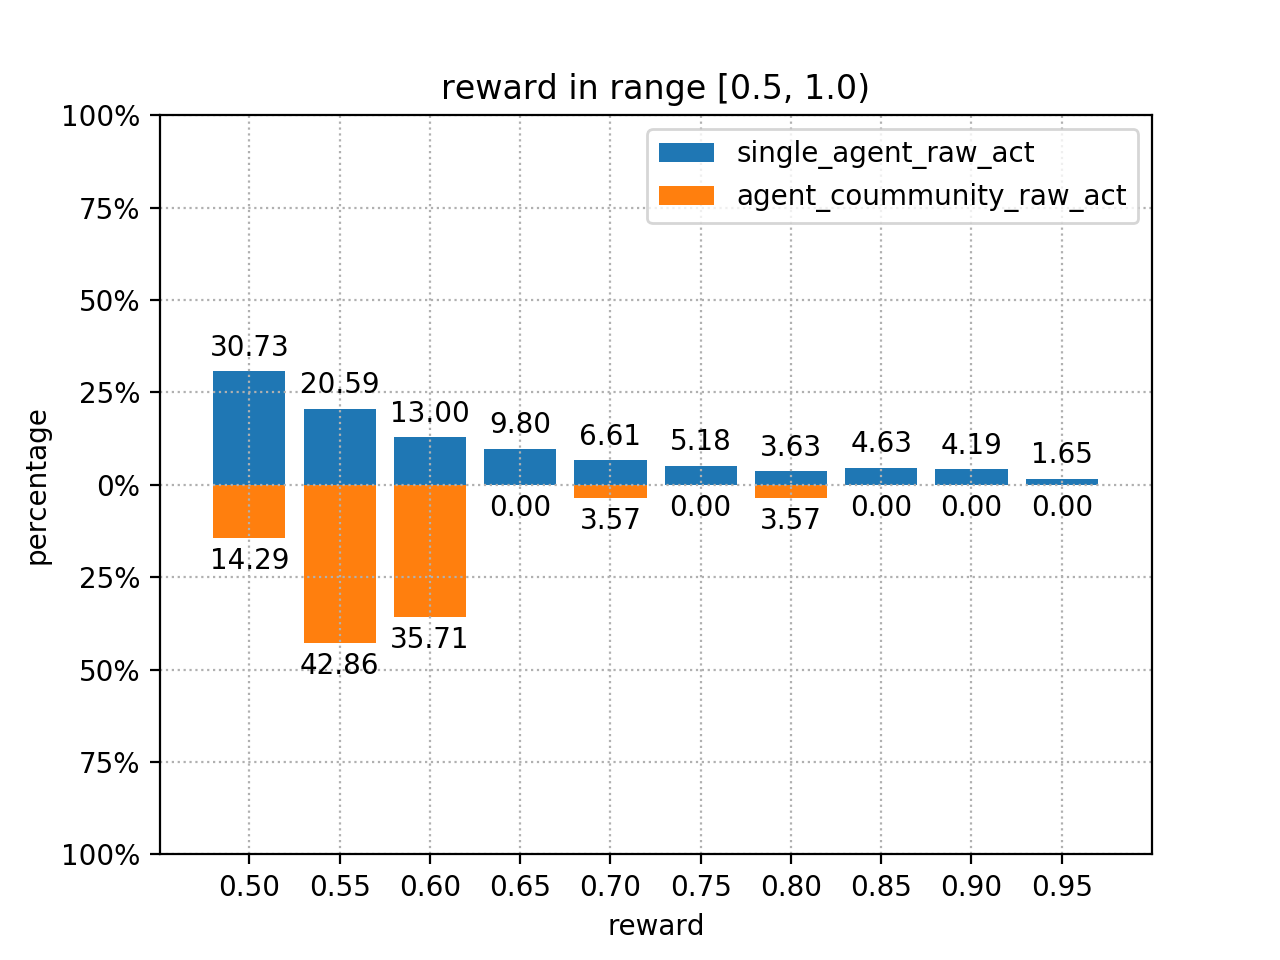

<IPython.core.display.Javascript object>


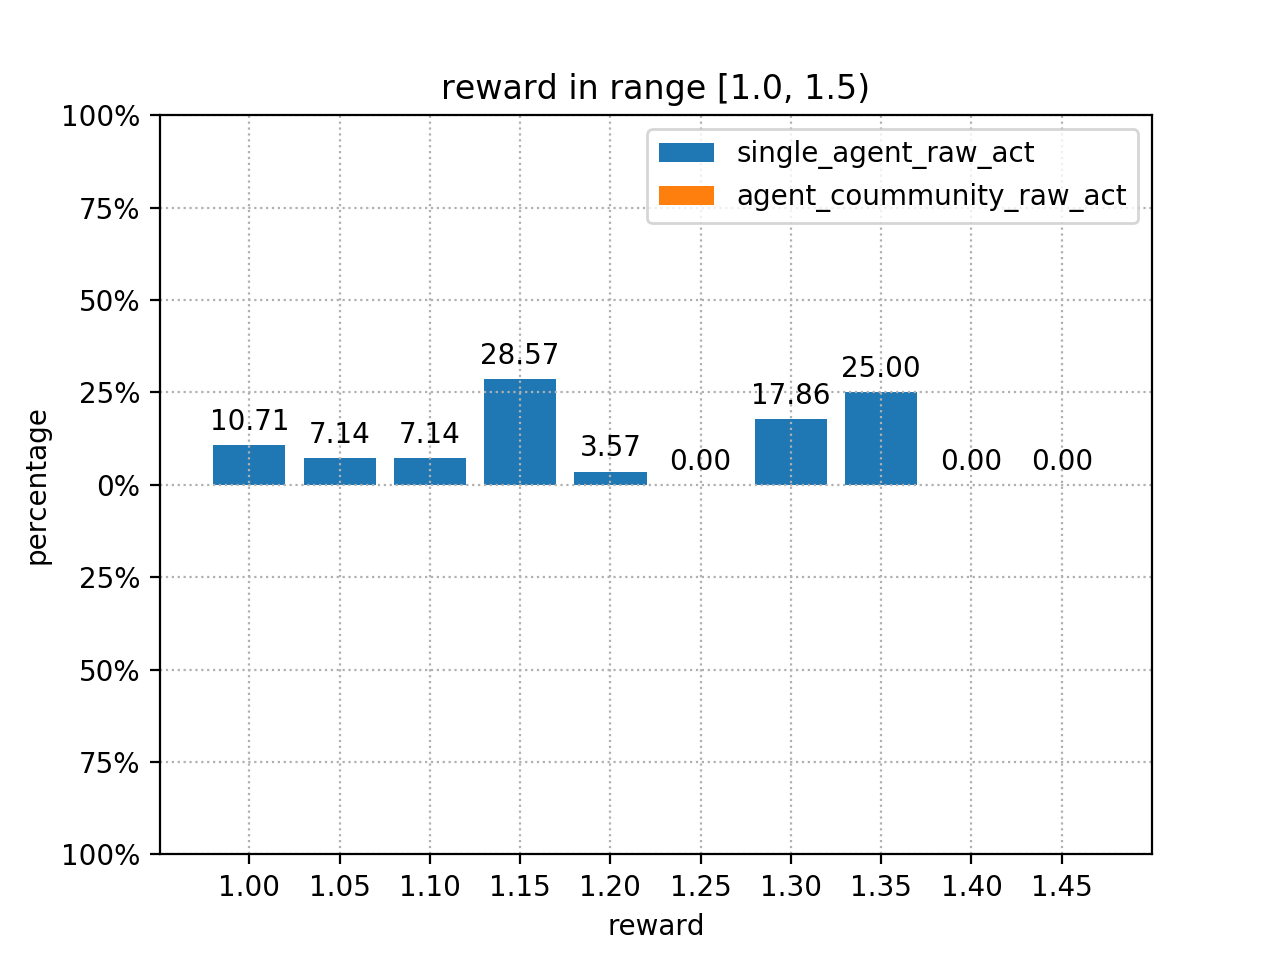

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


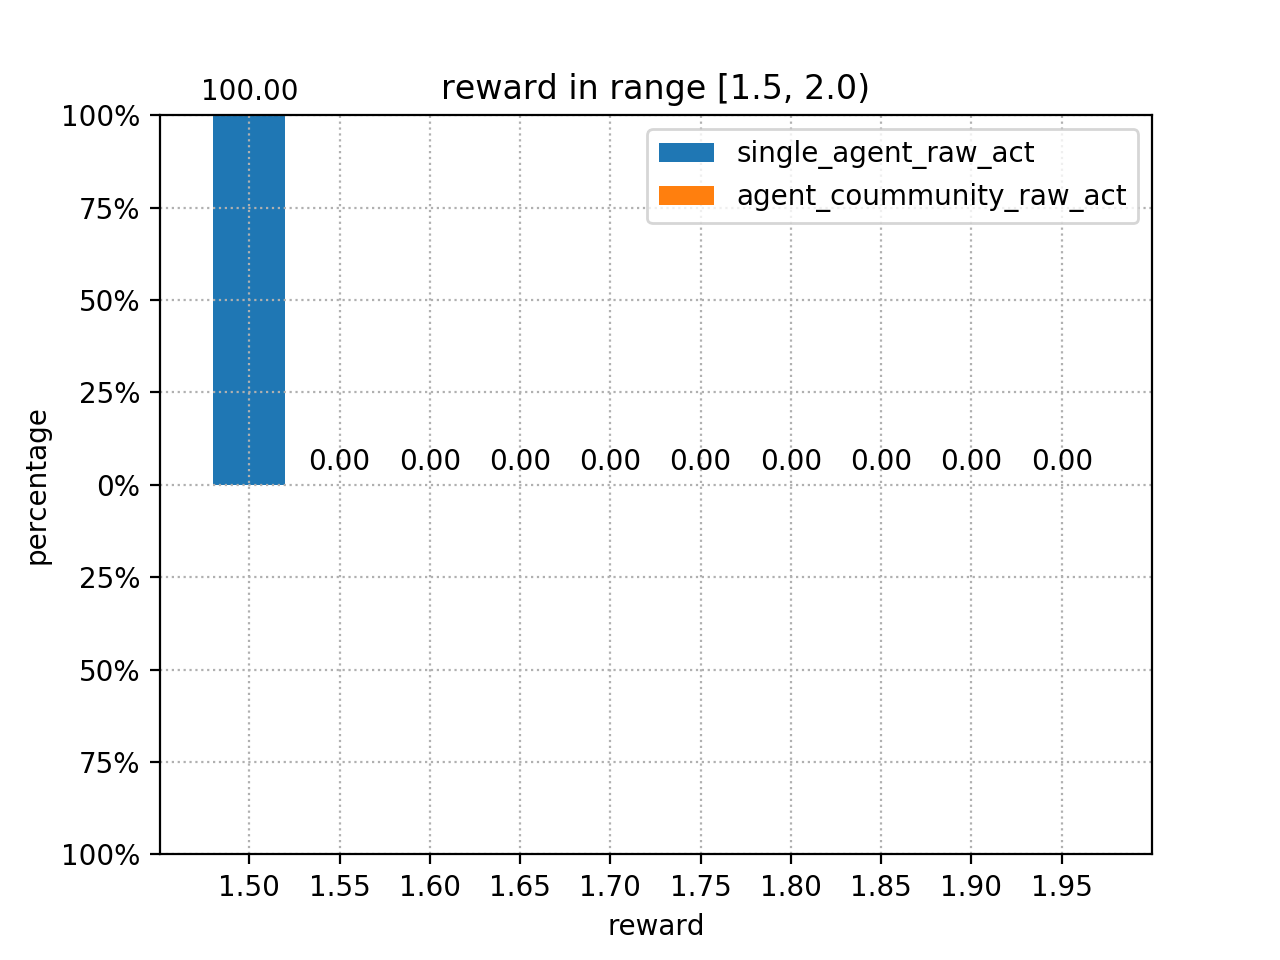

In [17]:
def plot_reward_in_range(reward_low, reward_up, 
                         prescribed_behavior, para_learning_agent, 
                         behavior_name1, behavior_name2):
    """
    Args:
        reward_low (float): lower bound of reward range
        reward_up (float): upper bound of reward range
        prescribed_behavior :
        para_learning_agent :
        behavior_name1 :
        behavior_name2 :
    """
    bin_low = reward_low
    bin_up = reward_up
    bin_step = 0.05
    bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
    binWidth = 0.04

    plt.figure()
    # Prescribed Behavior
    reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
    hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
    hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
    results_pb, edges_pb = np.histogram(hist_data_pb, bins)
    percentage_pb = (results_pb / sum(results_pb)) * 100

    # Parameterized Learning Agent
    reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
    hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
    hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
    results_pla, edges_pla = np.histogram(hist_data_pla, bins)
    percentage_pla = (results_pla / sum(results_pla)) * 100

    plt.bar(edges_pb[:-1], percentage_pb, binWidth)
    plt.bar(edges_pla[:-1], -percentage_pla, binWidth)

    for x, y in zip(edges_pb[:-1], percentage_pb):
        plt.text(x, y + 2.5, '{0:.2f}'.format(y), ha='center', va= 'bottom')

    for x, y in zip(edges_pla[:-1], percentage_pla):
        plt.text(x, -y - 2.5, '{0:.2f}'.format(y), ha='center', va= 'top')

    plt.xlim(reward_low-bin_step*0.99, edges_pb[-1])
    plt.xlabel('reward')
    plt.xticks(edges_pb[:-1])
    plt.ylim(-100, 100)
    plt.ylabel('percentage')
    plt.gca().set_yticklabels(['{:.0f}%'.format(abs(x)) for x in plt.gca().get_yticks()])

    plt.legend([behavior_name1, behavior_name2], loc='upper right')
    plt.title('reward in range [{:.1f}, {:.1f})'.format(reward_low, reward_up))

    plt.grid(True, linestyle=':')
    plt.show()
    plt.savefig('plot_reward_{}_{}_in_range_{}_{}.png'.format(behavior_name1, behavior_name2, str(reward_low).replace('.','_'), str(reward_up).replace('.','_')), dpi=300)
   
# Prescribed behavior and Parameterized Learning Agent
reward_low = 0
reward_up = 0.5
plot_reward_in_range(reward_low, reward_up, 
                     prescribed_behavior, para_learning_agent, 
                     'prescribed_behavior', 'para_learning_agent')

reward_low = 0.5
reward_up = 1
plot_reward_in_range(reward_low, reward_up, 
                     prescribed_behavior, para_learning_agent,
                    'prescribed_behavior', 'para_learning_agent')

reward_low = 1
reward_up = 1.5
plot_reward_in_range(reward_low, reward_up, 
                     prescribed_behavior, para_learning_agent,
                    'prescribed_behavior', 'para_learning_agent')

reward_low = 1.5
reward_up = 2
plot_reward_in_range(reward_low, reward_up, 
                     prescribed_behavior, para_learning_agent,
                    'prescribed_behavior', 'para_learning_agent')

# Single Agent and Agent Community
reward_low = 0
reward_up = 0.5
plot_reward_in_range(reward_low, reward_up, 
                     single_agent_raw_act, agent_coummunity_raw_act,
                    'single_agent_raw_act', 'agent_coummunity_raw_act')

reward_low = 0.5
reward_up = 1
plot_reward_in_range(reward_low, reward_up, 
                     single_agent_raw_act, agent_coummunity_raw_act,
                    'single_agent_raw_act', 'agent_coummunity_raw_act')

reward_low = 1
reward_up = 1.5
plot_reward_in_range(reward_low, reward_up, 
                     single_agent_raw_act, agent_coummunity_raw_act,
                    'single_agent_raw_act', 'agent_coummunity_raw_act')

reward_low = 1.5
reward_up = 2
plot_reward_in_range(reward_low, reward_up, 
                     single_agent_raw_act, agent_coummunity_raw_act,
                    'single_agent_raw_act', 'agent_coummunity_raw_act')
